In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D,Reshape, Dropout, Dense, GlobalAveragePooling2D, \
BatchNormalization, Input, Flatten, MaxPooling2D, UpSampling2D,Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')

In [5]:
display(csv_data.head()), csv_data.shape

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(None, (13570, 16))

In [6]:
train_path = 'shuffled-dataset/TrainingSet/'
train_images = os.listdir(train_path)
len(train_images)
val_path = 'shuffled-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(val_images)

1971

In [7]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

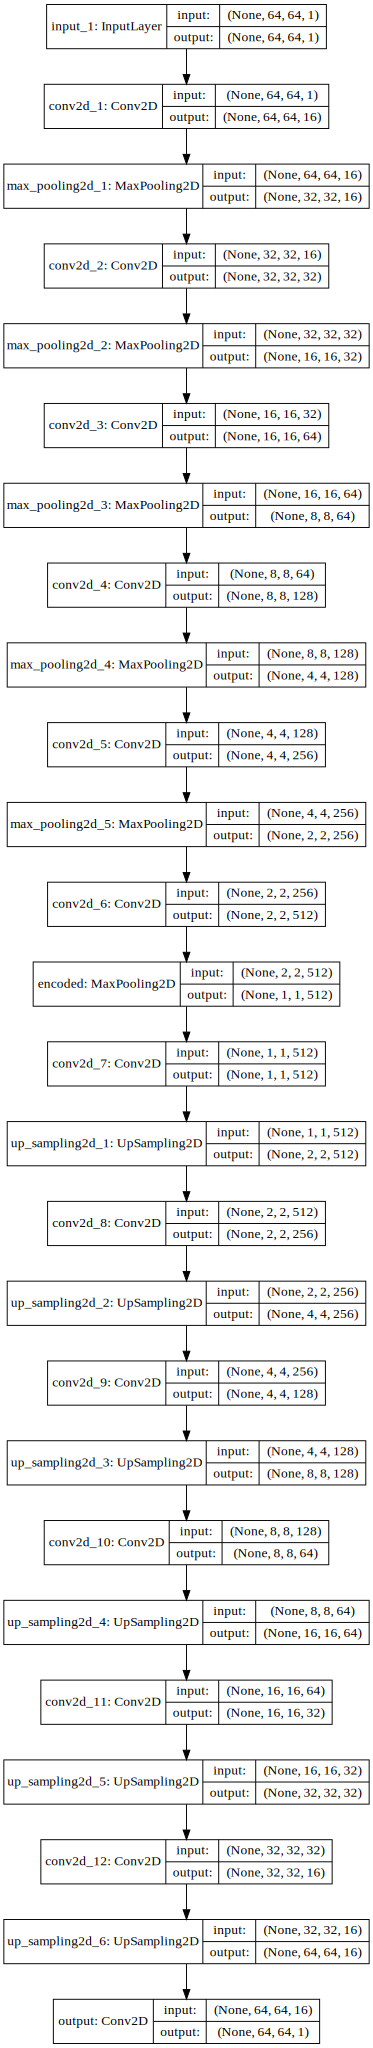

In [8]:

SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [9]:

def datagen(batch_size,image_path,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    
    
    while True:
        counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
#             class_vectors = []
            writer = list_of_writers[writer_index]
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]

    
            loaded_image = cv2.imread(os.path.join(image_path,writer),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
#             loaded_image = np.expand_dims(loaded_image,-1)
#             loaded_image_shifted = np.expand_dims(loaded_image_shifted,-1)
#             print('csv_writer:', csv_writer, ', writer:', writer)
#             display(csv_data[csv_data['ImageId'].str.match(csv_writer)])
#             csv_discreete_features = csv_data[csv_data['ImageId'].str.match(csv_writer)].iloc[0].values[2:]
#             print(csv_writer, writer_samples[writer_sample_index])
#             print(csv_writer,csv_discreete_features)
#             for i in range(1,9):
#                 print(csv_discreete_features[i-1],end=',')
#             f_1_out.append(csv_discreete_features[0])
#             f_2_out.append(csv_discreete_features[1])
#             f_3_out.append(csv_discreete_features[2])
#             f_4_out.append(csv_discreete_features[3])
#             f_5_out.append(csv_discreete_features[4])
#             f_6_out.append(csv_discreete_features[5])
#             f_7_out.append(csv_discreete_features[6])
#             f_8_out.append(csv_discreete_features[7])
#                 class_vectors.append(to_categorical(csv_discreete_features[i-1],num_classes=feature_lengths['f'+str(i)]))
#             print("\n",len(class_vectors))
#             print('\n-----------')
            
#             print("++++++++++++++++++++++[",counter,"]+++++++++++++++++++++++")
        #     imgcounter = 0
        #     for sample in writer_samples:
        #         imagepath = os.path.join(image_path,sample)
        #         raw_img = cv2.imread(imagepath)
        #         imgcounter+=1
        #     imgcounter=0
        #     identitycounter += 1
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer)
            ids.append(writer_index)
            
            counter+=1
#             print('counter:', counter, end='\r')
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0
                    

In [10]:
# # unique_writers_count
# f_count = {}
train_list_of_writers = train_images
val_list_of_writers = val_images
batch_size = 64

tg = datagen(batch_size,train_path,train_list_of_writers, hshift = (-64,64))
vg = datagen(batch_size,val_path,val_list_of_writers, hshift = (-64,64))
# test_g = datagen(4,val_list_of_writers, hshift = (-12,12))

In [11]:
# images
for i in range(10):
    inputs,y = next(tg)
inputs.shape , y.shape#, o[0].shape #, o[1].shape,o[2].shape,o[3].shape,o[4].shape,o[5].shape,o[6].shape,o[7].shape

((64, 64, 64, 1), (64, 64, 64, 1))

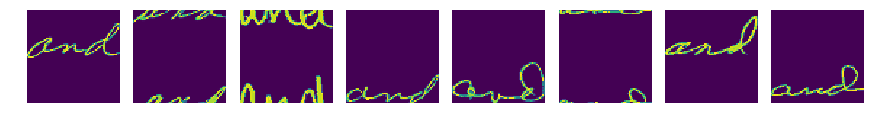

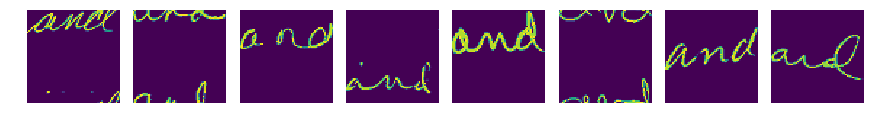

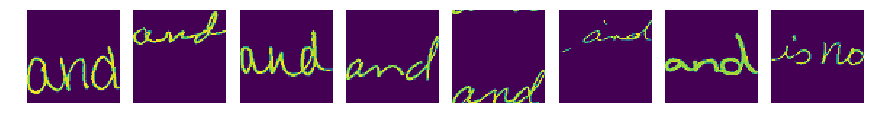

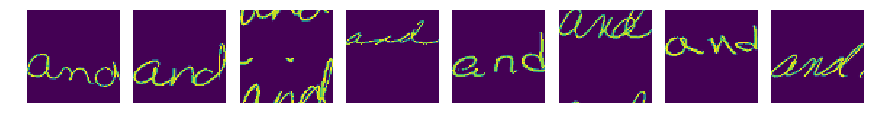

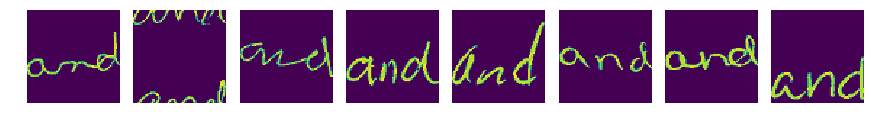

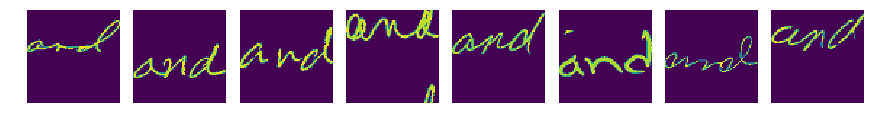

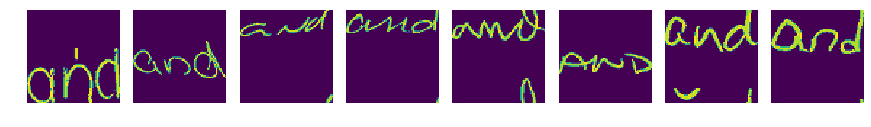

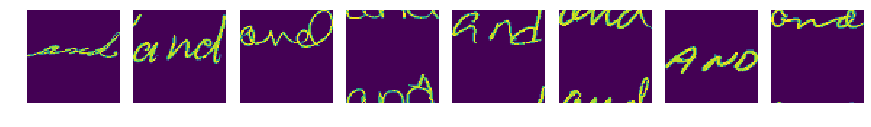

In [12]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [13]:
mc = ModelCheckpoint(filepath='simple_ae_maxpool_Shuffled_weights_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
autoencoder.load_weights('simple_ae_maxpool_less_weights_v3.h5')

In [14]:
EPOCHS = 50000

hist = autoencoder.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/50000

Epoch 00001: val_loss improved from inf to 0.15971, saving model to simple_ae_maxpool_Shuffled_weights_v1.h5
Epoch 2/50000

Epoch 00002: val_loss improved from 0.15971 to 0.15625, saving model to simple_ae_maxpool_Shuffled_weights_v1.h5
Epoch 3/50000

Epoch 00003: val_loss did not improve from 0.15625
Epoch 4/50000

Epoch 00004: val_loss improved from 0.15625 to 0.15165, saving model to simple_ae_maxpool_Shuffled_weights_v1.h5
Epoch 5/50000

Epoch 00005: val_loss did not improve from 0.15165
Epoch 6/50000

Epoch 00006: val_loss did not improve from 0.15165
Epoch 7/50000

Epoch 00007: val_loss improved from 0.15165 to 0.14779, saving model to simple_ae_maxpool_Shuffled_weights_v1.h5
Epoch 8/50000

Epoch 00008: val_loss did not improve from 0.14779
Epoch 9/50000

Epoch 00009: val_loss did not improve from 0.14779
Epoch 10/50000

Epoch 00010: val_loss improved from 0.14779 to 0.14716, saving model to simple_ae_maxpool_Shuffled_weights_v1.h5
Epoch 11/50000

Epoch 00011: val_


Epoch 00116: val_loss did not improve from 0.13957
Epoch 117/50000

Epoch 00117: val_loss did not improve from 0.13957
Epoch 118/50000

Epoch 00118: val_loss did not improve from 0.13957
Epoch 119/50000

Epoch 00119: val_loss did not improve from 0.13957
Epoch 120/50000

Epoch 00120: val_loss did not improve from 0.13957
Epoch 121/50000

Epoch 00121: val_loss did not improve from 0.13957
Epoch 122/50000

Epoch 00122: val_loss did not improve from 0.13957
Epoch 123/50000

Epoch 00123: val_loss did not improve from 0.13957
Epoch 124/50000

Epoch 00124: val_loss did not improve from 0.13957
Epoch 125/50000

Epoch 00125: val_loss did not improve from 0.13957
Epoch 126/50000

Epoch 00126: val_loss did not improve from 0.13957
Epoch 127/50000

Epoch 00127: val_loss did not improve from 0.13957
Epoch 128/50000

Epoch 00128: val_loss did not improve from 0.13957
Epoch 129/50000

Epoch 00129: val_loss did not improve from 0.13957
Epoch 130/50000

Epoch 00130: val_loss did not improve from 0.13


Epoch 00237: val_loss did not improve from 0.13169
Epoch 238/50000

Epoch 00238: val_loss did not improve from 0.13169
Epoch 239/50000

Epoch 00239: val_loss did not improve from 0.13169
Epoch 240/50000

Epoch 00240: val_loss did not improve from 0.13169
Epoch 241/50000

Epoch 00241: val_loss did not improve from 0.13169
Epoch 242/50000

Epoch 00242: val_loss did not improve from 0.13169
Epoch 243/50000

Epoch 00243: val_loss did not improve from 0.13169
Epoch 244/50000

Epoch 00244: val_loss did not improve from 0.13169
Epoch 245/50000

Epoch 00245: val_loss did not improve from 0.13169
Epoch 246/50000

Epoch 00246: val_loss did not improve from 0.13169
Epoch 247/50000

Epoch 00247: val_loss did not improve from 0.13169
Epoch 248/50000

Epoch 00248: val_loss did not improve from 0.13169
Epoch 249/50000

Epoch 00249: val_loss did not improve from 0.13169
Epoch 250/50000

Epoch 00250: val_loss did not improve from 0.13169
Epoch 251/50000

Epoch 00251: val_loss did not improve from 0.13


Epoch 00362: val_loss did not improve from 0.13169
Epoch 363/50000

Epoch 00363: val_loss did not improve from 0.13169
Epoch 364/50000

Epoch 00364: val_loss did not improve from 0.13169
Epoch 365/50000

Epoch 00365: val_loss did not improve from 0.13169
Epoch 366/50000

Epoch 00366: val_loss did not improve from 0.13169
Epoch 367/50000

Epoch 00367: val_loss did not improve from 0.13169
Epoch 368/50000

Epoch 00368: val_loss did not improve from 0.13169
Epoch 369/50000

Epoch 00369: val_loss did not improve from 0.13169
Epoch 370/50000

Epoch 00370: val_loss did not improve from 0.13169
Epoch 371/50000

Epoch 00371: val_loss did not improve from 0.13169
Epoch 372/50000

Epoch 00372: val_loss did not improve from 0.13169
Epoch 373/50000

Epoch 00373: val_loss did not improve from 0.13169
Epoch 374/50000

Epoch 00374: val_loss did not improve from 0.13169
Epoch 375/50000

Epoch 00375: val_loss did not improve from 0.13169
Epoch 376/50000

Epoch 00376: val_loss did not improve from 0.13


Epoch 00487: val_loss did not improve from 0.13169
Epoch 488/50000

Epoch 00488: val_loss did not improve from 0.13169
Epoch 489/50000

Epoch 00489: val_loss did not improve from 0.13169
Epoch 490/50000

Epoch 00490: val_loss did not improve from 0.13169
Epoch 491/50000

Epoch 00491: val_loss did not improve from 0.13169
Epoch 492/50000

Epoch 00492: val_loss did not improve from 0.13169
Epoch 493/50000

Epoch 00493: val_loss did not improve from 0.13169
Epoch 494/50000

Epoch 00494: val_loss did not improve from 0.13169
Epoch 495/50000

Epoch 00495: val_loss did not improve from 0.13169
Epoch 496/50000

Epoch 00496: val_loss did not improve from 0.13169
Epoch 497/50000

Epoch 00497: val_loss did not improve from 0.13169
Epoch 498/50000

Epoch 00498: val_loss did not improve from 0.13169
Epoch 499/50000

Epoch 00499: val_loss did not improve from 0.13169
Epoch 500/50000

Epoch 00500: val_loss did not improve from 0.13169
Epoch 501/50000

Epoch 00501: val_loss did not improve from 0.13


Epoch 00613: val_loss did not improve from 0.13169
Epoch 614/50000

Epoch 00614: val_loss did not improve from 0.13169
Epoch 615/50000

Epoch 00615: val_loss did not improve from 0.13169
Epoch 616/50000

Epoch 00616: val_loss did not improve from 0.13169
Epoch 617/50000

Epoch 00617: val_loss did not improve from 0.13169
Epoch 618/50000

Epoch 00618: val_loss did not improve from 0.13169
Epoch 619/50000

Epoch 00619: val_loss did not improve from 0.13169
Epoch 620/50000

Epoch 00620: val_loss did not improve from 0.13169
Epoch 621/50000

Epoch 00621: val_loss did not improve from 0.13169
Epoch 622/50000

Epoch 00622: val_loss did not improve from 0.13169
Epoch 623/50000

Epoch 00623: val_loss did not improve from 0.13169
Epoch 624/50000

Epoch 00624: val_loss did not improve from 0.13169
Epoch 625/50000

Epoch 00625: val_loss did not improve from 0.13169
Epoch 626/50000

Epoch 00626: val_loss did not improve from 0.13169
Epoch 627/50000

Epoch 00627: val_loss did not improve from 0.13


Epoch 00739: val_loss did not improve from 0.13169
Epoch 740/50000

Epoch 00740: val_loss did not improve from 0.13169
Epoch 741/50000

Epoch 00741: val_loss did not improve from 0.13169
Epoch 742/50000

Epoch 00742: val_loss did not improve from 0.13169
Epoch 743/50000

Epoch 00743: val_loss did not improve from 0.13169
Epoch 744/50000

Epoch 00744: val_loss did not improve from 0.13169
Epoch 745/50000

Epoch 00745: val_loss did not improve from 0.13169
Epoch 746/50000

Epoch 00746: val_loss did not improve from 0.13169
Epoch 747/50000

Epoch 00747: val_loss did not improve from 0.13169
Epoch 748/50000

Epoch 00748: val_loss did not improve from 0.13169
Epoch 749/50000

Epoch 00749: val_loss did not improve from 0.13169
Epoch 750/50000

Epoch 00750: val_loss did not improve from 0.13169
Epoch 751/50000

Epoch 00751: val_loss did not improve from 0.13169
Epoch 752/50000

Epoch 00752: val_loss did not improve from 0.13169
Epoch 753/50000

Epoch 00753: val_loss did not improve from 0.13


Epoch 00865: val_loss did not improve from 0.13169
Epoch 866/50000

Epoch 00866: val_loss did not improve from 0.13169
Epoch 867/50000

Epoch 00867: val_loss did not improve from 0.13169
Epoch 868/50000

Epoch 00868: val_loss did not improve from 0.13169
Epoch 869/50000

Epoch 00869: val_loss did not improve from 0.13169
Epoch 870/50000

Epoch 00870: val_loss did not improve from 0.13169
Epoch 871/50000

Epoch 00871: val_loss did not improve from 0.13169
Epoch 872/50000

Epoch 00872: val_loss did not improve from 0.13169
Epoch 873/50000

Epoch 00873: val_loss did not improve from 0.13169
Epoch 874/50000

Epoch 00874: val_loss did not improve from 0.13169
Epoch 875/50000

Epoch 00875: val_loss did not improve from 0.13169
Epoch 876/50000

Epoch 00876: val_loss did not improve from 0.13169
Epoch 877/50000

Epoch 00877: val_loss did not improve from 0.13169
Epoch 878/50000

Epoch 00878: val_loss did not improve from 0.13169
Epoch 879/50000

Epoch 00879: val_loss did not improve from 0.13


Epoch 00985: val_loss did not improve from 0.13124
Epoch 986/50000

Epoch 00986: val_loss did not improve from 0.13124
Epoch 987/50000

Epoch 00987: val_loss did not improve from 0.13124
Epoch 988/50000

Epoch 00988: val_loss did not improve from 0.13124
Epoch 989/50000

Epoch 00989: val_loss did not improve from 0.13124
Epoch 990/50000

Epoch 00990: val_loss did not improve from 0.13124
Epoch 991/50000

Epoch 00991: val_loss did not improve from 0.13124
Epoch 992/50000

Epoch 00992: val_loss did not improve from 0.13124
Epoch 993/50000

Epoch 00993: val_loss did not improve from 0.13124
Epoch 994/50000

Epoch 00994: val_loss did not improve from 0.13124
Epoch 995/50000

Epoch 00995: val_loss did not improve from 0.13124
Epoch 996/50000

Epoch 00996: val_loss did not improve from 0.13124
Epoch 997/50000

Epoch 00997: val_loss did not improve from 0.13124
Epoch 998/50000

Epoch 00998: val_loss did not improve from 0.13124
Epoch 999/50000

Epoch 00999: val_loss did not improve from 0.13


Epoch 01110: val_loss did not improve from 0.13124
Epoch 1111/50000

Epoch 01111: val_loss did not improve from 0.13124
Epoch 1112/50000

Epoch 01112: val_loss did not improve from 0.13124
Epoch 1113/50000

Epoch 01113: val_loss did not improve from 0.13124
Epoch 1114/50000

Epoch 01114: val_loss did not improve from 0.13124
Epoch 1115/50000

Epoch 01115: val_loss did not improve from 0.13124
Epoch 1116/50000

Epoch 01116: val_loss did not improve from 0.13124
Epoch 1117/50000

Epoch 01117: val_loss did not improve from 0.13124
Epoch 1118/50000

Epoch 01118: val_loss did not improve from 0.13124
Epoch 1119/50000

Epoch 01119: val_loss did not improve from 0.13124
Epoch 1120/50000

Epoch 01120: val_loss did not improve from 0.13124
Epoch 1121/50000

Epoch 01121: val_loss did not improve from 0.13124
Epoch 1122/50000

Epoch 01122: val_loss did not improve from 0.13124
Epoch 1123/50000

Epoch 01123: val_loss did not improve from 0.13124
Epoch 1124/50000

Epoch 01124: val_loss did not imp


Epoch 01235: val_loss did not improve from 0.13124
Epoch 1236/50000

Epoch 01236: val_loss did not improve from 0.13124
Epoch 1237/50000

Epoch 01237: val_loss did not improve from 0.13124
Epoch 1238/50000

Epoch 01238: val_loss did not improve from 0.13124
Epoch 1239/50000

Epoch 01239: val_loss did not improve from 0.13124
Epoch 1240/50000

Epoch 01240: val_loss did not improve from 0.13124
Epoch 1241/50000

Epoch 01241: val_loss did not improve from 0.13124
Epoch 1242/50000

Epoch 01242: val_loss did not improve from 0.13124
Epoch 1243/50000

Epoch 01243: val_loss did not improve from 0.13124
Epoch 1244/50000

Epoch 01244: val_loss did not improve from 0.13124
Epoch 1245/50000

Epoch 01245: val_loss did not improve from 0.13124
Epoch 1246/50000

Epoch 01246: val_loss did not improve from 0.13124
Epoch 1247/50000

Epoch 01247: val_loss did not improve from 0.13124
Epoch 1248/50000

Epoch 01248: val_loss did not improve from 0.13124
Epoch 1249/50000

Epoch 01249: val_loss did not imp


Epoch 01361: val_loss did not improve from 0.13124
Epoch 1362/50000

Epoch 01362: val_loss did not improve from 0.13124
Epoch 1363/50000

Epoch 01363: val_loss did not improve from 0.13124
Epoch 1364/50000

Epoch 01364: val_loss did not improve from 0.13124
Epoch 1365/50000

Epoch 01365: val_loss did not improve from 0.13124
Epoch 1366/50000

Epoch 01366: val_loss did not improve from 0.13124
Epoch 1367/50000

Epoch 01367: val_loss did not improve from 0.13124
Epoch 1368/50000

Epoch 01368: val_loss did not improve from 0.13124
Epoch 1369/50000

Epoch 01369: val_loss did not improve from 0.13124
Epoch 1370/50000

Epoch 01370: val_loss did not improve from 0.13124
Epoch 1371/50000

Epoch 01371: val_loss did not improve from 0.13124
Epoch 1372/50000

Epoch 01372: val_loss did not improve from 0.13124
Epoch 1373/50000

Epoch 01373: val_loss did not improve from 0.13124
Epoch 1374/50000

Epoch 01374: val_loss did not improve from 0.13124
Epoch 1375/50000

Epoch 01375: val_loss did not imp


Epoch 01483: val_loss did not improve from 0.13026
Epoch 1484/50000

Epoch 01484: val_loss did not improve from 0.13026
Epoch 1485/50000

Epoch 01485: val_loss did not improve from 0.13026
Epoch 1486/50000

Epoch 01486: val_loss did not improve from 0.13026
Epoch 1487/50000

Epoch 01487: val_loss did not improve from 0.13026
Epoch 1488/50000

Epoch 01488: val_loss did not improve from 0.13026
Epoch 1489/50000

Epoch 01489: val_loss did not improve from 0.13026
Epoch 1490/50000

Epoch 01490: val_loss did not improve from 0.13026
Epoch 1491/50000

Epoch 01491: val_loss did not improve from 0.13026
Epoch 1492/50000

Epoch 01492: val_loss did not improve from 0.13026
Epoch 1493/50000

Epoch 01493: val_loss did not improve from 0.13026
Epoch 1494/50000

Epoch 01494: val_loss did not improve from 0.13026
Epoch 1495/50000

Epoch 01495: val_loss did not improve from 0.13026
Epoch 1496/50000

Epoch 01496: val_loss did not improve from 0.13026
Epoch 1497/50000

Epoch 01497: val_loss did not imp


Epoch 01606: val_loss did not improve from 0.12952
Epoch 1607/50000

Epoch 01607: val_loss did not improve from 0.12952
Epoch 1608/50000

Epoch 01608: val_loss did not improve from 0.12952
Epoch 1609/50000

Epoch 01609: val_loss did not improve from 0.12952
Epoch 1610/50000

Epoch 01610: val_loss did not improve from 0.12952
Epoch 1611/50000

Epoch 01611: val_loss did not improve from 0.12952
Epoch 1612/50000

Epoch 01612: val_loss did not improve from 0.12952
Epoch 1613/50000

Epoch 01613: val_loss did not improve from 0.12952
Epoch 1614/50000

Epoch 01614: val_loss did not improve from 0.12952
Epoch 1615/50000

Epoch 01615: val_loss did not improve from 0.12952
Epoch 1616/50000

Epoch 01616: val_loss did not improve from 0.12952
Epoch 1617/50000

Epoch 01617: val_loss did not improve from 0.12952
Epoch 1618/50000

Epoch 01618: val_loss did not improve from 0.12952
Epoch 1619/50000

Epoch 01619: val_loss did not improve from 0.12952
Epoch 1620/50000

Epoch 01620: val_loss did not imp


Epoch 01728: val_loss did not improve from 0.12944
Epoch 1729/50000

Epoch 01729: val_loss did not improve from 0.12944
Epoch 1730/50000

Epoch 01730: val_loss did not improve from 0.12944
Epoch 1731/50000

Epoch 01731: val_loss did not improve from 0.12944
Epoch 1732/50000

Epoch 01732: val_loss did not improve from 0.12944
Epoch 1733/50000

Epoch 01733: val_loss did not improve from 0.12944
Epoch 1734/50000

Epoch 01734: val_loss did not improve from 0.12944
Epoch 1735/50000

Epoch 01735: val_loss did not improve from 0.12944
Epoch 1736/50000

Epoch 01736: val_loss did not improve from 0.12944
Epoch 1737/50000

Epoch 01737: val_loss did not improve from 0.12944
Epoch 1738/50000

Epoch 01738: val_loss did not improve from 0.12944
Epoch 1739/50000

Epoch 01739: val_loss did not improve from 0.12944
Epoch 1740/50000

Epoch 01740: val_loss did not improve from 0.12944
Epoch 1741/50000

Epoch 01741: val_loss did not improve from 0.12944
Epoch 1742/50000

Epoch 01742: val_loss did not imp


Epoch 01854: val_loss did not improve from 0.12944
Epoch 1855/50000

Epoch 01855: val_loss did not improve from 0.12944
Epoch 1856/50000

Epoch 01856: val_loss did not improve from 0.12944
Epoch 1857/50000

Epoch 01857: val_loss did not improve from 0.12944
Epoch 1858/50000

Epoch 01858: val_loss did not improve from 0.12944
Epoch 1859/50000

Epoch 01859: val_loss did not improve from 0.12944
Epoch 1860/50000

Epoch 01860: val_loss did not improve from 0.12944
Epoch 1861/50000

Epoch 01861: val_loss did not improve from 0.12944
Epoch 1862/50000

Epoch 01862: val_loss did not improve from 0.12944
Epoch 1863/50000

Epoch 01863: val_loss did not improve from 0.12944
Epoch 1864/50000

Epoch 01864: val_loss did not improve from 0.12944
Epoch 1865/50000

Epoch 01865: val_loss did not improve from 0.12944
Epoch 1866/50000

Epoch 01866: val_loss did not improve from 0.12944
Epoch 1867/50000

Epoch 01867: val_loss did not improve from 0.12944
Epoch 1868/50000

Epoch 01868: val_loss did not imp


Epoch 01977: val_loss did not improve from 0.12927
Epoch 1978/50000

Epoch 01978: val_loss did not improve from 0.12927
Epoch 1979/50000

Epoch 01979: val_loss did not improve from 0.12927
Epoch 1980/50000

Epoch 01980: val_loss did not improve from 0.12927
Epoch 1981/50000

Epoch 01981: val_loss did not improve from 0.12927
Epoch 1982/50000

Epoch 01982: val_loss did not improve from 0.12927
Epoch 1983/50000

Epoch 01983: val_loss did not improve from 0.12927
Epoch 1984/50000

Epoch 01984: val_loss did not improve from 0.12927
Epoch 1985/50000

Epoch 01985: val_loss improved from 0.12927 to 0.12854, saving model to simple_ae_maxpool_Shuffled_weights_v1.h5
Epoch 1986/50000

Epoch 01986: val_loss did not improve from 0.12854
Epoch 1987/50000

Epoch 01987: val_loss did not improve from 0.12854
Epoch 1988/50000

Epoch 01988: val_loss did not improve from 0.12854
Epoch 1989/50000

Epoch 01989: val_loss did not improve from 0.12854
Epoch 1990/50000

Epoch 01990: val_loss did not improve fr


Epoch 02102: val_loss did not improve from 0.12854
Epoch 2103/50000

Epoch 02103: val_loss did not improve from 0.12854
Epoch 2104/50000

Epoch 02104: val_loss did not improve from 0.12854
Epoch 2105/50000

Epoch 02105: val_loss did not improve from 0.12854
Epoch 2106/50000

Epoch 02106: val_loss did not improve from 0.12854
Epoch 2107/50000

Epoch 02107: val_loss did not improve from 0.12854
Epoch 2108/50000

Epoch 02108: val_loss did not improve from 0.12854
Epoch 2109/50000

Epoch 02109: val_loss did not improve from 0.12854
Epoch 2110/50000

Epoch 02110: val_loss did not improve from 0.12854
Epoch 2111/50000

Epoch 02111: val_loss did not improve from 0.12854
Epoch 2112/50000

Epoch 02112: val_loss did not improve from 0.12854
Epoch 2113/50000

Epoch 02113: val_loss did not improve from 0.12854
Epoch 2114/50000

Epoch 02114: val_loss did not improve from 0.12854
Epoch 2115/50000

Epoch 02115: val_loss did not improve from 0.12854
Epoch 2116/50000

Epoch 02116: val_loss did not imp

Epoch 02220: val_loss did not improve from 0.12762
Epoch 2221/50000

Epoch 02221: val_loss did not improve from 0.12762
Epoch 2222/50000

Epoch 02222: val_loss did not improve from 0.12762
Epoch 2223/50000

Epoch 02223: val_loss did not improve from 0.12762
Epoch 2224/50000

Epoch 02224: val_loss did not improve from 0.12762
Epoch 2225/50000

Epoch 02225: val_loss did not improve from 0.12762
Epoch 2226/50000

Epoch 02226: val_loss did not improve from 0.12762
Epoch 2227/50000

Epoch 02227: val_loss did not improve from 0.12762
Epoch 2228/50000

Epoch 02228: val_loss did not improve from 0.12762
Epoch 2229/50000

Epoch 02229: val_loss did not improve from 0.12762
Epoch 2230/50000

Epoch 02230: val_loss did not improve from 0.12762
Epoch 2231/50000

Epoch 02231: val_loss did not improve from 0.12762
Epoch 2232/50000

Epoch 02232: val_loss did not improve from 0.12762
Epoch 2233/50000

Epoch 02233: val_loss did not improve from 0.12762
Epoch 2234/50000

Epoch 02234: val_loss did not impr


Epoch 02346: val_loss did not improve from 0.12762
Epoch 2347/50000

Epoch 02347: val_loss did not improve from 0.12762
Epoch 2348/50000

Epoch 02348: val_loss did not improve from 0.12762
Epoch 2349/50000

Epoch 02349: val_loss did not improve from 0.12762
Epoch 2350/50000

Epoch 02350: val_loss did not improve from 0.12762
Epoch 2351/50000

Epoch 02351: val_loss did not improve from 0.12762
Epoch 2352/50000

Epoch 02352: val_loss did not improve from 0.12762
Epoch 2353/50000

Epoch 02353: val_loss did not improve from 0.12762
Epoch 2354/50000

Epoch 02354: val_loss did not improve from 0.12762
Epoch 2355/50000

Epoch 02355: val_loss did not improve from 0.12762
Epoch 2356/50000

Epoch 02356: val_loss did not improve from 0.12762
Epoch 2357/50000

Epoch 02357: val_loss did not improve from 0.12762
Epoch 2358/50000

Epoch 02358: val_loss did not improve from 0.12762
Epoch 2359/50000

Epoch 02359: val_loss did not improve from 0.12762
Epoch 2360/50000

Epoch 02360: val_loss did not imp


Epoch 02472: val_loss did not improve from 0.12762
Epoch 2473/50000

Epoch 02473: val_loss did not improve from 0.12762
Epoch 2474/50000

Epoch 02474: val_loss did not improve from 0.12762
Epoch 2475/50000

Epoch 02475: val_loss did not improve from 0.12762
Epoch 2476/50000

Epoch 02476: val_loss did not improve from 0.12762
Epoch 2477/50000

Epoch 02477: val_loss did not improve from 0.12762
Epoch 2478/50000

Epoch 02478: val_loss did not improve from 0.12762
Epoch 2479/50000

Epoch 02479: val_loss did not improve from 0.12762
Epoch 2480/50000

Epoch 02480: val_loss did not improve from 0.12762
Epoch 2481/50000

Epoch 02481: val_loss did not improve from 0.12762
Epoch 2482/50000

Epoch 02482: val_loss did not improve from 0.12762
Epoch 2483/50000

Epoch 02483: val_loss did not improve from 0.12762
Epoch 2484/50000

Epoch 02484: val_loss did not improve from 0.12762
Epoch 2485/50000

Epoch 02485: val_loss did not improve from 0.12762
Epoch 2486/50000

Epoch 02486: val_loss did not imp


Epoch 02598: val_loss did not improve from 0.12762
Epoch 2599/50000

Epoch 02599: val_loss did not improve from 0.12762
Epoch 2600/50000

Epoch 02600: val_loss did not improve from 0.12762
Epoch 2601/50000

Epoch 02601: val_loss did not improve from 0.12762
Epoch 2602/50000

Epoch 02602: val_loss did not improve from 0.12762
Epoch 2603/50000

Epoch 02603: val_loss did not improve from 0.12762
Epoch 2604/50000

Epoch 02604: val_loss did not improve from 0.12762
Epoch 2605/50000

Epoch 02605: val_loss did not improve from 0.12762
Epoch 2606/50000

Epoch 02606: val_loss did not improve from 0.12762
Epoch 2607/50000

Epoch 02607: val_loss did not improve from 0.12762
Epoch 2608/50000

Epoch 02608: val_loss did not improve from 0.12762
Epoch 2609/50000

Epoch 02609: val_loss did not improve from 0.12762
Epoch 2610/50000

Epoch 02610: val_loss did not improve from 0.12762
Epoch 2611/50000

Epoch 02611: val_loss did not improve from 0.12762
Epoch 2612/50000

Epoch 02612: val_loss did not imp


Epoch 02724: val_loss did not improve from 0.12762
Epoch 2725/50000

Epoch 02725: val_loss did not improve from 0.12762
Epoch 2726/50000

Epoch 02726: val_loss did not improve from 0.12762
Epoch 2727/50000

Epoch 02727: val_loss did not improve from 0.12762
Epoch 2728/50000

Epoch 02728: val_loss did not improve from 0.12762
Epoch 2729/50000

Epoch 02729: val_loss did not improve from 0.12762
Epoch 2730/50000

Epoch 02730: val_loss did not improve from 0.12762
Epoch 2731/50000

Epoch 02731: val_loss did not improve from 0.12762
Epoch 2732/50000

Epoch 02732: val_loss did not improve from 0.12762
Epoch 2733/50000

Epoch 02733: val_loss did not improve from 0.12762
Epoch 2734/50000

Epoch 02734: val_loss did not improve from 0.12762
Epoch 2735/50000

Epoch 02735: val_loss did not improve from 0.12762
Epoch 2736/50000

Epoch 02736: val_loss did not improve from 0.12762
Epoch 2737/50000

Epoch 02737: val_loss did not improve from 0.12762
Epoch 2738/50000

Epoch 02738: val_loss did not imp


Epoch 02848: val_loss did not improve from 0.12720
Epoch 2849/50000

Epoch 02849: val_loss did not improve from 0.12720
Epoch 2850/50000

Epoch 02850: val_loss did not improve from 0.12720
Epoch 2851/50000

Epoch 02851: val_loss did not improve from 0.12720
Epoch 2852/50000

Epoch 02852: val_loss did not improve from 0.12720
Epoch 2853/50000

Epoch 02853: val_loss did not improve from 0.12720
Epoch 2854/50000

Epoch 02854: val_loss did not improve from 0.12720
Epoch 2855/50000

Epoch 02855: val_loss did not improve from 0.12720
Epoch 2856/50000

Epoch 02856: val_loss did not improve from 0.12720
Epoch 2857/50000

Epoch 02857: val_loss did not improve from 0.12720
Epoch 2858/50000

Epoch 02858: val_loss did not improve from 0.12720
Epoch 2859/50000

Epoch 02859: val_loss did not improve from 0.12720
Epoch 2860/50000

Epoch 02860: val_loss did not improve from 0.12720
Epoch 2861/50000

Epoch 02861: val_loss did not improve from 0.12720
Epoch 2862/50000

Epoch 02862: val_loss did not imp


Epoch 02971: val_loss did not improve from 0.12668
Epoch 2972/50000

Epoch 02972: val_loss did not improve from 0.12668
Epoch 2973/50000

Epoch 02973: val_loss did not improve from 0.12668
Epoch 2974/50000

Epoch 02974: val_loss did not improve from 0.12668
Epoch 2975/50000

Epoch 02975: val_loss did not improve from 0.12668
Epoch 2976/50000

Epoch 02976: val_loss did not improve from 0.12668
Epoch 2977/50000

Epoch 02977: val_loss did not improve from 0.12668
Epoch 2978/50000

Epoch 02978: val_loss did not improve from 0.12668
Epoch 2979/50000

Epoch 02979: val_loss did not improve from 0.12668
Epoch 2980/50000

Epoch 02980: val_loss did not improve from 0.12668
Epoch 2981/50000

Epoch 02981: val_loss did not improve from 0.12668
Epoch 2982/50000

Epoch 02982: val_loss did not improve from 0.12668
Epoch 2983/50000

Epoch 02983: val_loss did not improve from 0.12668
Epoch 2984/50000

Epoch 02984: val_loss did not improve from 0.12668
Epoch 2985/50000

Epoch 02985: val_loss did not imp


Epoch 03096: val_loss did not improve from 0.12668
Epoch 3097/50000

Epoch 03097: val_loss did not improve from 0.12668
Epoch 3098/50000

Epoch 03098: val_loss did not improve from 0.12668
Epoch 3099/50000

Epoch 03099: val_loss did not improve from 0.12668
Epoch 3100/50000

Epoch 03100: val_loss did not improve from 0.12668
Epoch 3101/50000

Epoch 03101: val_loss did not improve from 0.12668
Epoch 3102/50000

Epoch 03102: val_loss did not improve from 0.12668
Epoch 3103/50000

Epoch 03103: val_loss did not improve from 0.12668
Epoch 3104/50000

Epoch 03104: val_loss did not improve from 0.12668
Epoch 3105/50000

Epoch 03105: val_loss did not improve from 0.12668
Epoch 3106/50000

Epoch 03106: val_loss did not improve from 0.12668
Epoch 3107/50000

Epoch 03107: val_loss did not improve from 0.12668
Epoch 3108/50000

Epoch 03108: val_loss did not improve from 0.12668
Epoch 3109/50000

Epoch 03109: val_loss did not improve from 0.12668
Epoch 3110/50000

Epoch 03110: val_loss did not imp


Epoch 03222: val_loss did not improve from 0.12668
Epoch 3223/50000

Epoch 03223: val_loss did not improve from 0.12668
Epoch 3224/50000

Epoch 03224: val_loss did not improve from 0.12668
Epoch 3225/50000

Epoch 03225: val_loss did not improve from 0.12668
Epoch 3226/50000

Epoch 03226: val_loss did not improve from 0.12668
Epoch 3227/50000

Epoch 03227: val_loss did not improve from 0.12668
Epoch 3228/50000

Epoch 03228: val_loss did not improve from 0.12668
Epoch 3229/50000

Epoch 03229: val_loss did not improve from 0.12668
Epoch 3230/50000

Epoch 03230: val_loss did not improve from 0.12668
Epoch 3231/50000

Epoch 03231: val_loss did not improve from 0.12668
Epoch 3232/50000

Epoch 03232: val_loss did not improve from 0.12668
Epoch 3233/50000

Epoch 03233: val_loss did not improve from 0.12668
Epoch 3234/50000

Epoch 03234: val_loss did not improve from 0.12668
Epoch 3235/50000

Epoch 03235: val_loss did not improve from 0.12668
Epoch 3236/50000

Epoch 03236: val_loss did not imp


Epoch 03348: val_loss did not improve from 0.12668
Epoch 3349/50000

Epoch 03349: val_loss did not improve from 0.12668
Epoch 3350/50000

Epoch 03350: val_loss did not improve from 0.12668
Epoch 3351/50000

Epoch 03351: val_loss did not improve from 0.12668
Epoch 3352/50000

Epoch 03352: val_loss did not improve from 0.12668
Epoch 3353/50000

Epoch 03353: val_loss did not improve from 0.12668
Epoch 3354/50000

Epoch 03354: val_loss did not improve from 0.12668
Epoch 3355/50000

Epoch 03355: val_loss did not improve from 0.12668
Epoch 3356/50000

Epoch 03356: val_loss did not improve from 0.12668
Epoch 3357/50000

Epoch 03357: val_loss did not improve from 0.12668
Epoch 3358/50000

Epoch 03358: val_loss did not improve from 0.12668
Epoch 3359/50000

Epoch 03359: val_loss did not improve from 0.12668
Epoch 3360/50000

Epoch 03360: val_loss did not improve from 0.12668
Epoch 3361/50000

Epoch 03361: val_loss did not improve from 0.12668
Epoch 3362/50000

Epoch 03362: val_loss did not imp


Epoch 03474: val_loss did not improve from 0.12668
Epoch 3475/50000

Epoch 03475: val_loss did not improve from 0.12668
Epoch 3476/50000

Epoch 03476: val_loss did not improve from 0.12668
Epoch 3477/50000

Epoch 03477: val_loss did not improve from 0.12668
Epoch 3478/50000

Epoch 03478: val_loss did not improve from 0.12668
Epoch 3479/50000

Epoch 03479: val_loss did not improve from 0.12668
Epoch 3480/50000

Epoch 03480: val_loss did not improve from 0.12668
Epoch 3481/50000

Epoch 03481: val_loss did not improve from 0.12668
Epoch 3482/50000

Epoch 03482: val_loss did not improve from 0.12668
Epoch 3483/50000

Epoch 03483: val_loss did not improve from 0.12668
Epoch 3484/50000

Epoch 03484: val_loss did not improve from 0.12668
Epoch 3485/50000

Epoch 03485: val_loss did not improve from 0.12668
Epoch 3486/50000

Epoch 03486: val_loss did not improve from 0.12668
Epoch 3487/50000

Epoch 03487: val_loss did not improve from 0.12668
Epoch 3488/50000

Epoch 03488: val_loss did not imp

Epoch 3597/50000

Epoch 03597: val_loss did not improve from 0.12656
Epoch 3598/50000

Epoch 03598: val_loss did not improve from 0.12656
Epoch 3599/50000

Epoch 03599: val_loss did not improve from 0.12656
Epoch 3600/50000

Epoch 03600: val_loss did not improve from 0.12656
Epoch 3601/50000

Epoch 03601: val_loss did not improve from 0.12656
Epoch 3602/50000

Epoch 03602: val_loss did not improve from 0.12656
Epoch 3603/50000

Epoch 03603: val_loss did not improve from 0.12656
Epoch 3604/50000

Epoch 03604: val_loss did not improve from 0.12656
Epoch 3605/50000

Epoch 03605: val_loss did not improve from 0.12656
Epoch 3606/50000

Epoch 03606: val_loss did not improve from 0.12656
Epoch 3607/50000

Epoch 03607: val_loss did not improve from 0.12656
Epoch 3608/50000

Epoch 03608: val_loss did not improve from 0.12656
Epoch 3609/50000

Epoch 03609: val_loss did not improve from 0.12656
Epoch 3610/50000

Epoch 03610: val_loss did not improve from 0.12656
Epoch 3611/50000

Epoch 03611: val


Epoch 03719: val_loss did not improve from 0.12440
Epoch 3720/50000

Epoch 03720: val_loss did not improve from 0.12440
Epoch 3721/50000

Epoch 03721: val_loss did not improve from 0.12440
Epoch 3722/50000

Epoch 03722: val_loss did not improve from 0.12440
Epoch 3723/50000

Epoch 03723: val_loss did not improve from 0.12440
Epoch 3724/50000

Epoch 03724: val_loss did not improve from 0.12440
Epoch 3725/50000

Epoch 03725: val_loss did not improve from 0.12440
Epoch 3726/50000

Epoch 03726: val_loss did not improve from 0.12440
Epoch 3727/50000

Epoch 03727: val_loss did not improve from 0.12440
Epoch 3728/50000

Epoch 03728: val_loss did not improve from 0.12440
Epoch 3729/50000

Epoch 03729: val_loss did not improve from 0.12440
Epoch 3730/50000

Epoch 03730: val_loss did not improve from 0.12440
Epoch 3731/50000

Epoch 03731: val_loss did not improve from 0.12440
Epoch 3732/50000

Epoch 03732: val_loss did not improve from 0.12440
Epoch 3733/50000

Epoch 03733: val_loss did not imp


Epoch 03844: val_loss did not improve from 0.12440
Epoch 3845/50000

Epoch 03845: val_loss did not improve from 0.12440
Epoch 3846/50000

Epoch 03846: val_loss did not improve from 0.12440
Epoch 3847/50000

Epoch 03847: val_loss did not improve from 0.12440
Epoch 3848/50000

Epoch 03848: val_loss did not improve from 0.12440
Epoch 3849/50000

Epoch 03849: val_loss did not improve from 0.12440
Epoch 3850/50000

Epoch 03850: val_loss did not improve from 0.12440
Epoch 3851/50000

Epoch 03851: val_loss did not improve from 0.12440
Epoch 3852/50000

Epoch 03852: val_loss did not improve from 0.12440
Epoch 3853/50000

Epoch 03853: val_loss did not improve from 0.12440
Epoch 3854/50000

Epoch 03854: val_loss did not improve from 0.12440
Epoch 3855/50000

Epoch 03855: val_loss did not improve from 0.12440
Epoch 3856/50000

Epoch 03856: val_loss did not improve from 0.12440
Epoch 3857/50000

Epoch 03857: val_loss did not improve from 0.12440
Epoch 3858/50000

Epoch 03858: val_loss did not imp


Epoch 03968: val_loss did not improve from 0.12440
Epoch 3969/50000

Epoch 03969: val_loss did not improve from 0.12440
Epoch 3970/50000

Epoch 03970: val_loss did not improve from 0.12440
Epoch 3971/50000

Epoch 03971: val_loss did not improve from 0.12440
Epoch 3972/50000

Epoch 03972: val_loss did not improve from 0.12440
Epoch 3973/50000

Epoch 03973: val_loss did not improve from 0.12440
Epoch 3974/50000

Epoch 03974: val_loss did not improve from 0.12440
Epoch 3975/50000

Epoch 03975: val_loss did not improve from 0.12440
Epoch 3976/50000

Epoch 03976: val_loss did not improve from 0.12440
Epoch 3977/50000

Epoch 03977: val_loss did not improve from 0.12440
Epoch 3978/50000

Epoch 03978: val_loss did not improve from 0.12440
Epoch 3979/50000

Epoch 03979: val_loss did not improve from 0.12440
Epoch 3980/50000

Epoch 03980: val_loss did not improve from 0.12440
Epoch 3981/50000

Epoch 03981: val_loss did not improve from 0.12440
Epoch 3982/50000

Epoch 03982: val_loss did not imp


Epoch 04092: val_loss did not improve from 0.12283
Epoch 4093/50000

Epoch 04093: val_loss did not improve from 0.12283
Epoch 4094/50000

Epoch 04094: val_loss did not improve from 0.12283
Epoch 4095/50000

Epoch 04095: val_loss did not improve from 0.12283
Epoch 4096/50000

Epoch 04096: val_loss did not improve from 0.12283
Epoch 4097/50000

Epoch 04097: val_loss did not improve from 0.12283
Epoch 4098/50000

Epoch 04098: val_loss did not improve from 0.12283
Epoch 4099/50000

Epoch 04099: val_loss did not improve from 0.12283
Epoch 4100/50000

Epoch 04100: val_loss did not improve from 0.12283
Epoch 4101/50000

Epoch 04101: val_loss did not improve from 0.12283
Epoch 4102/50000

Epoch 04102: val_loss did not improve from 0.12283
Epoch 4103/50000

Epoch 04103: val_loss did not improve from 0.12283
Epoch 4104/50000

Epoch 04104: val_loss did not improve from 0.12283
Epoch 4105/50000

Epoch 04105: val_loss did not improve from 0.12283
Epoch 4106/50000

Epoch 04106: val_loss did not imp


Epoch 04215: val_loss did not improve from 0.12283
Epoch 4216/50000

Epoch 04216: val_loss did not improve from 0.12283
Epoch 4217/50000

Epoch 04217: val_loss did not improve from 0.12283
Epoch 4218/50000

Epoch 04218: val_loss did not improve from 0.12283
Epoch 4219/50000

Epoch 04219: val_loss did not improve from 0.12283
Epoch 4220/50000

Epoch 04220: val_loss did not improve from 0.12283
Epoch 4221/50000

Epoch 04221: val_loss did not improve from 0.12283
Epoch 4222/50000

Epoch 04222: val_loss did not improve from 0.12283
Epoch 4223/50000

Epoch 04223: val_loss did not improve from 0.12283
Epoch 4224/50000

Epoch 04224: val_loss did not improve from 0.12283
Epoch 4225/50000

Epoch 04225: val_loss did not improve from 0.12283
Epoch 4226/50000

Epoch 04226: val_loss did not improve from 0.12283
Epoch 4227/50000

Epoch 04227: val_loss did not improve from 0.12283
Epoch 4228/50000

Epoch 04228: val_loss did not improve from 0.12283
Epoch 4229/50000

Epoch 04229: val_loss did not imp


Epoch 04337: val_loss did not improve from 0.12283
Epoch 4338/50000

Epoch 04338: val_loss did not improve from 0.12283
Epoch 4339/50000

Epoch 04339: val_loss did not improve from 0.12283
Epoch 4340/50000

Epoch 04340: val_loss did not improve from 0.12283
Epoch 4341/50000

Epoch 04341: val_loss did not improve from 0.12283
Epoch 4342/50000

Epoch 04342: val_loss did not improve from 0.12283
Epoch 4343/50000

Epoch 04343: val_loss did not improve from 0.12283
Epoch 4344/50000

Epoch 04344: val_loss did not improve from 0.12283
Epoch 4345/50000

Epoch 04345: val_loss did not improve from 0.12283
Epoch 4346/50000

Epoch 04346: val_loss did not improve from 0.12283
Epoch 4347/50000

Epoch 04347: val_loss did not improve from 0.12283
Epoch 4348/50000

Epoch 04348: val_loss did not improve from 0.12283
Epoch 4349/50000

Epoch 04349: val_loss did not improve from 0.12283
Epoch 4350/50000

Epoch 04350: val_loss did not improve from 0.12283
Epoch 4351/50000

Epoch 04351: val_loss did not imp


Epoch 04458: val_loss did not improve from 0.12283
Epoch 4459/50000

Epoch 04459: val_loss did not improve from 0.12283
Epoch 4460/50000

Epoch 04460: val_loss did not improve from 0.12283
Epoch 4461/50000

Epoch 04461: val_loss did not improve from 0.12283
Epoch 4462/50000

Epoch 04462: val_loss did not improve from 0.12283
Epoch 4463/50000

Epoch 04463: val_loss did not improve from 0.12283
Epoch 4464/50000

Epoch 04464: val_loss did not improve from 0.12283
Epoch 4465/50000

Epoch 04465: val_loss did not improve from 0.12283
Epoch 4466/50000

Epoch 04466: val_loss did not improve from 0.12283
Epoch 4467/50000

Epoch 04467: val_loss did not improve from 0.12283
Epoch 4468/50000

Epoch 04468: val_loss did not improve from 0.12283
Epoch 4469/50000

Epoch 04469: val_loss did not improve from 0.12283
Epoch 4470/50000

Epoch 04470: val_loss did not improve from 0.12283
Epoch 4471/50000

Epoch 04471: val_loss did not improve from 0.12283
Epoch 4472/50000

Epoch 04472: val_loss did not imp


Epoch 04580: val_loss did not improve from 0.12283
Epoch 4581/50000

Epoch 04581: val_loss did not improve from 0.12283
Epoch 4582/50000

Epoch 04582: val_loss did not improve from 0.12283
Epoch 4583/50000

Epoch 04583: val_loss did not improve from 0.12283
Epoch 4584/50000

Epoch 04584: val_loss did not improve from 0.12283
Epoch 4585/50000

Epoch 04585: val_loss did not improve from 0.12283
Epoch 4586/50000

Epoch 04586: val_loss did not improve from 0.12283
Epoch 4587/50000

Epoch 04587: val_loss did not improve from 0.12283
Epoch 4588/50000

Epoch 04588: val_loss did not improve from 0.12283
Epoch 4589/50000

Epoch 04589: val_loss did not improve from 0.12283
Epoch 4590/50000

Epoch 04590: val_loss did not improve from 0.12283
Epoch 4591/50000

Epoch 04591: val_loss did not improve from 0.12283
Epoch 4592/50000

Epoch 04592: val_loss did not improve from 0.12283
Epoch 4593/50000

Epoch 04593: val_loss did not improve from 0.12283
Epoch 4594/50000

Epoch 04594: val_loss did not imp


Epoch 04702: val_loss did not improve from 0.12283
Epoch 4703/50000

Epoch 04703: val_loss did not improve from 0.12283
Epoch 4704/50000

Epoch 04704: val_loss did not improve from 0.12283
Epoch 4705/50000

Epoch 04705: val_loss did not improve from 0.12283
Epoch 4706/50000

Epoch 04706: val_loss did not improve from 0.12283
Epoch 4707/50000

Epoch 04707: val_loss did not improve from 0.12283
Epoch 4708/50000

Epoch 04708: val_loss did not improve from 0.12283
Epoch 4709/50000

Epoch 04709: val_loss did not improve from 0.12283
Epoch 4710/50000

Epoch 04710: val_loss did not improve from 0.12283
Epoch 4711/50000

Epoch 04711: val_loss did not improve from 0.12283
Epoch 4712/50000

Epoch 04712: val_loss did not improve from 0.12283
Epoch 4713/50000

Epoch 04713: val_loss did not improve from 0.12283
Epoch 4714/50000

Epoch 04714: val_loss did not improve from 0.12283
Epoch 4715/50000

Epoch 04715: val_loss did not improve from 0.12283
Epoch 4716/50000

Epoch 04716: val_loss did not imp


Epoch 04824: val_loss did not improve from 0.12283
Epoch 4825/50000

Epoch 04825: val_loss did not improve from 0.12283
Epoch 4826/50000

Epoch 04826: val_loss did not improve from 0.12283
Epoch 4827/50000

Epoch 04827: val_loss did not improve from 0.12283
Epoch 4828/50000

Epoch 04828: val_loss did not improve from 0.12283
Epoch 4829/50000

Epoch 04829: val_loss did not improve from 0.12283
Epoch 4830/50000

Epoch 04830: val_loss did not improve from 0.12283
Epoch 4831/50000

Epoch 04831: val_loss did not improve from 0.12283
Epoch 4832/50000

Epoch 04832: val_loss did not improve from 0.12283
Epoch 4833/50000

Epoch 04833: val_loss did not improve from 0.12283
Epoch 4834/50000

Epoch 04834: val_loss did not improve from 0.12283
Epoch 4835/50000

Epoch 04835: val_loss did not improve from 0.12283
Epoch 4836/50000

Epoch 04836: val_loss did not improve from 0.12283
Epoch 4837/50000

Epoch 04837: val_loss did not improve from 0.12283
Epoch 4838/50000

Epoch 04838: val_loss did not imp


Epoch 04947: val_loss did not improve from 0.12283
Epoch 4948/50000

Epoch 04948: val_loss did not improve from 0.12283
Epoch 4949/50000

Epoch 04949: val_loss did not improve from 0.12283
Epoch 4950/50000

Epoch 04950: val_loss did not improve from 0.12283
Epoch 4951/50000

Epoch 04951: val_loss did not improve from 0.12283
Epoch 4952/50000

Epoch 04952: val_loss did not improve from 0.12283
Epoch 4953/50000

Epoch 04953: val_loss did not improve from 0.12283
Epoch 4954/50000

Epoch 04954: val_loss did not improve from 0.12283
Epoch 4955/50000

Epoch 04955: val_loss did not improve from 0.12283
Epoch 4956/50000

Epoch 04956: val_loss did not improve from 0.12283
Epoch 4957/50000

Epoch 04957: val_loss did not improve from 0.12283
Epoch 4958/50000

Epoch 04958: val_loss did not improve from 0.12283
Epoch 4959/50000

Epoch 04959: val_loss did not improve from 0.12283
Epoch 4960/50000

Epoch 04960: val_loss did not improve from 0.12283
Epoch 4961/50000

Epoch 04961: val_loss did not imp


Epoch 05069: val_loss did not improve from 0.12283
Epoch 5070/50000

Epoch 05070: val_loss did not improve from 0.12283
Epoch 5071/50000

Epoch 05071: val_loss did not improve from 0.12283
Epoch 5072/50000

Epoch 05072: val_loss did not improve from 0.12283
Epoch 5073/50000

Epoch 05073: val_loss did not improve from 0.12283
Epoch 5074/50000

Epoch 05074: val_loss did not improve from 0.12283
Epoch 5075/50000

Epoch 05075: val_loss did not improve from 0.12283
Epoch 5076/50000

Epoch 05076: val_loss did not improve from 0.12283
Epoch 5077/50000

Epoch 05077: val_loss did not improve from 0.12283
Epoch 5078/50000

Epoch 05078: val_loss did not improve from 0.12283
Epoch 5079/50000

Epoch 05079: val_loss did not improve from 0.12283
Epoch 5080/50000

Epoch 05080: val_loss did not improve from 0.12283
Epoch 5081/50000

Epoch 05081: val_loss did not improve from 0.12283
Epoch 5082/50000

Epoch 05082: val_loss did not improve from 0.12283
Epoch 5083/50000

Epoch 05083: val_loss did not imp


Epoch 05191: val_loss did not improve from 0.12283
Epoch 5192/50000

Epoch 05192: val_loss did not improve from 0.12283
Epoch 5193/50000

Epoch 05193: val_loss did not improve from 0.12283
Epoch 5194/50000

Epoch 05194: val_loss did not improve from 0.12283
Epoch 5195/50000

Epoch 05195: val_loss did not improve from 0.12283
Epoch 5196/50000

Epoch 05196: val_loss did not improve from 0.12283
Epoch 5197/50000

Epoch 05197: val_loss did not improve from 0.12283
Epoch 5198/50000

Epoch 05198: val_loss did not improve from 0.12283
Epoch 5199/50000

Epoch 05199: val_loss did not improve from 0.12283
Epoch 5200/50000

Epoch 05200: val_loss did not improve from 0.12283
Epoch 5201/50000

Epoch 05201: val_loss did not improve from 0.12283
Epoch 5202/50000

Epoch 05202: val_loss did not improve from 0.12283
Epoch 5203/50000

Epoch 05203: val_loss did not improve from 0.12283
Epoch 5204/50000

Epoch 05204: val_loss did not improve from 0.12283
Epoch 5205/50000

Epoch 05205: val_loss did not imp


Epoch 05315: val_loss did not improve from 0.12217
Epoch 5316/50000

Epoch 05316: val_loss did not improve from 0.12217
Epoch 5317/50000

Epoch 05317: val_loss did not improve from 0.12217
Epoch 5318/50000

Epoch 05318: val_loss did not improve from 0.12217
Epoch 5319/50000

Epoch 05319: val_loss did not improve from 0.12217
Epoch 5320/50000

Epoch 05320: val_loss did not improve from 0.12217
Epoch 5321/50000

Epoch 05321: val_loss did not improve from 0.12217
Epoch 5322/50000

Epoch 05322: val_loss did not improve from 0.12217
Epoch 5323/50000

Epoch 05323: val_loss did not improve from 0.12217
Epoch 5324/50000

Epoch 05324: val_loss did not improve from 0.12217
Epoch 5325/50000

Epoch 05325: val_loss did not improve from 0.12217
Epoch 5326/50000

Epoch 05326: val_loss did not improve from 0.12217
Epoch 5327/50000

Epoch 05327: val_loss did not improve from 0.12217
Epoch 5328/50000

Epoch 05328: val_loss did not improve from 0.12217
Epoch 5329/50000

Epoch 05329: val_loss did not imp


Epoch 05436: val_loss did not improve from 0.12217
Epoch 5437/50000

Epoch 05437: val_loss did not improve from 0.12217
Epoch 5438/50000

Epoch 05438: val_loss did not improve from 0.12217
Epoch 5439/50000

Epoch 05439: val_loss did not improve from 0.12217
Epoch 5440/50000

Epoch 05440: val_loss did not improve from 0.12217
Epoch 5441/50000

Epoch 05441: val_loss did not improve from 0.12217
Epoch 5442/50000

Epoch 05442: val_loss did not improve from 0.12217
Epoch 5443/50000

Epoch 05443: val_loss did not improve from 0.12217
Epoch 5444/50000

Epoch 05444: val_loss did not improve from 0.12217
Epoch 5445/50000

Epoch 05445: val_loss did not improve from 0.12217
Epoch 5446/50000

Epoch 05446: val_loss did not improve from 0.12217
Epoch 5447/50000

Epoch 05447: val_loss did not improve from 0.12217
Epoch 5448/50000

Epoch 05448: val_loss did not improve from 0.12217
Epoch 5449/50000

Epoch 05449: val_loss did not improve from 0.12217
Epoch 5450/50000

Epoch 05450: val_loss did not imp


Epoch 05559: val_loss did not improve from 0.12217
Epoch 5560/50000

Epoch 05560: val_loss did not improve from 0.12217
Epoch 5561/50000

Epoch 05561: val_loss did not improve from 0.12217
Epoch 5562/50000

Epoch 05562: val_loss did not improve from 0.12217
Epoch 5563/50000

Epoch 05563: val_loss did not improve from 0.12217
Epoch 5564/50000

Epoch 05564: val_loss did not improve from 0.12217
Epoch 5565/50000

Epoch 05565: val_loss did not improve from 0.12217
Epoch 5566/50000

Epoch 05566: val_loss did not improve from 0.12217
Epoch 5567/50000

Epoch 05567: val_loss did not improve from 0.12217
Epoch 5568/50000

Epoch 05568: val_loss did not improve from 0.12217
Epoch 5569/50000

Epoch 05569: val_loss did not improve from 0.12217
Epoch 5570/50000

Epoch 05570: val_loss did not improve from 0.12217
Epoch 5571/50000

Epoch 05571: val_loss did not improve from 0.12217
Epoch 5572/50000

Epoch 05572: val_loss did not improve from 0.12217
Epoch 5573/50000

Epoch 05573: val_loss did not imp


Epoch 05678: val_loss did not improve from 0.12217
Epoch 5679/50000

Epoch 05679: val_loss did not improve from 0.12217
Epoch 5680/50000

Epoch 05680: val_loss did not improve from 0.12217
Epoch 5681/50000

Epoch 05681: val_loss did not improve from 0.12217
Epoch 5682/50000

Epoch 05682: val_loss did not improve from 0.12217
Epoch 5683/50000

Epoch 05683: val_loss did not improve from 0.12217
Epoch 5684/50000

Epoch 05684: val_loss did not improve from 0.12217
Epoch 5685/50000

Epoch 05685: val_loss did not improve from 0.12217
Epoch 5686/50000

Epoch 05686: val_loss did not improve from 0.12217
Epoch 5687/50000

Epoch 05687: val_loss did not improve from 0.12217
Epoch 5688/50000

Epoch 05688: val_loss did not improve from 0.12217
Epoch 5689/50000

Epoch 05689: val_loss did not improve from 0.12217
Epoch 5690/50000

Epoch 05690: val_loss did not improve from 0.12217
Epoch 5691/50000

Epoch 05691: val_loss did not improve from 0.12217
Epoch 5692/50000

Epoch 05692: val_loss did not imp


Epoch 05797: val_loss did not improve from 0.12117
Epoch 5798/50000

Epoch 05798: val_loss did not improve from 0.12117
Epoch 5799/50000

Epoch 05799: val_loss did not improve from 0.12117
Epoch 5800/50000

Epoch 05800: val_loss did not improve from 0.12117
Epoch 5801/50000

Epoch 05801: val_loss did not improve from 0.12117
Epoch 5802/50000

Epoch 05802: val_loss did not improve from 0.12117
Epoch 5803/50000

Epoch 05803: val_loss did not improve from 0.12117
Epoch 5804/50000

Epoch 05804: val_loss did not improve from 0.12117
Epoch 5805/50000

Epoch 05805: val_loss did not improve from 0.12117
Epoch 5806/50000

Epoch 05806: val_loss did not improve from 0.12117
Epoch 5807/50000

Epoch 05807: val_loss did not improve from 0.12117
Epoch 5808/50000

Epoch 05808: val_loss did not improve from 0.12117
Epoch 5809/50000

Epoch 05809: val_loss did not improve from 0.12117
Epoch 5810/50000

Epoch 05810: val_loss did not improve from 0.12117
Epoch 5811/50000

Epoch 05811: val_loss did not imp


Epoch 05916: val_loss did not improve from 0.12117
Epoch 5917/50000

Epoch 05917: val_loss did not improve from 0.12117
Epoch 5918/50000

Epoch 05918: val_loss did not improve from 0.12117
Epoch 5919/50000

Epoch 05919: val_loss did not improve from 0.12117
Epoch 5920/50000

Epoch 05920: val_loss did not improve from 0.12117
Epoch 5921/50000

Epoch 05921: val_loss did not improve from 0.12117
Epoch 5922/50000

Epoch 05922: val_loss did not improve from 0.12117
Epoch 5923/50000

Epoch 05923: val_loss did not improve from 0.12117
Epoch 5924/50000

Epoch 05924: val_loss did not improve from 0.12117
Epoch 5925/50000

Epoch 05925: val_loss did not improve from 0.12117
Epoch 5926/50000

Epoch 05926: val_loss did not improve from 0.12117
Epoch 5927/50000

Epoch 05927: val_loss did not improve from 0.12117
Epoch 5928/50000

Epoch 05928: val_loss did not improve from 0.12117
Epoch 5929/50000

Epoch 05929: val_loss did not improve from 0.12117
Epoch 5930/50000

Epoch 05930: val_loss did not imp


Epoch 06038: val_loss did not improve from 0.12117
Epoch 6039/50000

Epoch 06039: val_loss did not improve from 0.12117
Epoch 6040/50000

Epoch 06040: val_loss did not improve from 0.12117
Epoch 6041/50000

Epoch 06041: val_loss did not improve from 0.12117
Epoch 6042/50000

Epoch 06042: val_loss did not improve from 0.12117
Epoch 6043/50000

Epoch 06043: val_loss did not improve from 0.12117
Epoch 6044/50000

Epoch 06044: val_loss did not improve from 0.12117
Epoch 6045/50000

Epoch 06045: val_loss did not improve from 0.12117
Epoch 6046/50000

Epoch 06046: val_loss did not improve from 0.12117
Epoch 6047/50000

Epoch 06047: val_loss did not improve from 0.12117
Epoch 6048/50000

Epoch 06048: val_loss did not improve from 0.12117
Epoch 6049/50000

Epoch 06049: val_loss did not improve from 0.12117
Epoch 6050/50000

Epoch 06050: val_loss did not improve from 0.12117
Epoch 6051/50000

Epoch 06051: val_loss did not improve from 0.12117
Epoch 6052/50000

Epoch 06052: val_loss did not imp


Epoch 06161: val_loss did not improve from 0.12117
Epoch 6162/50000

Epoch 06162: val_loss did not improve from 0.12117
Epoch 6163/50000

Epoch 06163: val_loss did not improve from 0.12117
Epoch 6164/50000

Epoch 06164: val_loss did not improve from 0.12117
Epoch 6165/50000

Epoch 06165: val_loss did not improve from 0.12117
Epoch 6166/50000

Epoch 06166: val_loss did not improve from 0.12117
Epoch 6167/50000

Epoch 06167: val_loss did not improve from 0.12117
Epoch 6168/50000

Epoch 06168: val_loss did not improve from 0.12117
Epoch 6169/50000

Epoch 06169: val_loss did not improve from 0.12117
Epoch 6170/50000

Epoch 06170: val_loss did not improve from 0.12117
Epoch 6171/50000

Epoch 06171: val_loss did not improve from 0.12117
Epoch 6172/50000

Epoch 06172: val_loss did not improve from 0.12117
Epoch 6173/50000

Epoch 06173: val_loss did not improve from 0.12117
Epoch 6174/50000

Epoch 06174: val_loss did not improve from 0.12117
Epoch 6175/50000

Epoch 06175: val_loss did not imp


Epoch 06281: val_loss did not improve from 0.12117
Epoch 6282/50000

Epoch 06282: val_loss did not improve from 0.12117
Epoch 6283/50000

Epoch 06283: val_loss did not improve from 0.12117
Epoch 6284/50000

Epoch 06284: val_loss did not improve from 0.12117
Epoch 6285/50000

Epoch 06285: val_loss did not improve from 0.12117
Epoch 6286/50000

Epoch 06286: val_loss did not improve from 0.12117
Epoch 6287/50000

Epoch 06287: val_loss did not improve from 0.12117
Epoch 6288/50000

Epoch 06288: val_loss did not improve from 0.12117
Epoch 6289/50000

Epoch 06289: val_loss did not improve from 0.12117
Epoch 6290/50000

Epoch 06290: val_loss did not improve from 0.12117
Epoch 6291/50000

Epoch 06291: val_loss did not improve from 0.12117
Epoch 6292/50000

Epoch 06292: val_loss did not improve from 0.12117
Epoch 6293/50000

Epoch 06293: val_loss did not improve from 0.12117
Epoch 6294/50000

Epoch 06294: val_loss did not improve from 0.12117
Epoch 6295/50000

Epoch 06295: val_loss did not imp


Epoch 06407: val_loss did not improve from 0.12117
Epoch 6408/50000

Epoch 06408: val_loss did not improve from 0.12117
Epoch 6409/50000

Epoch 06409: val_loss did not improve from 0.12117
Epoch 6410/50000

Epoch 06410: val_loss did not improve from 0.12117
Epoch 6411/50000

Epoch 06411: val_loss did not improve from 0.12117
Epoch 6412/50000

Epoch 06412: val_loss did not improve from 0.12117
Epoch 6413/50000

Epoch 06413: val_loss did not improve from 0.12117
Epoch 6414/50000

Epoch 06414: val_loss did not improve from 0.12117
Epoch 6415/50000

Epoch 06415: val_loss did not improve from 0.12117
Epoch 6416/50000

Epoch 06416: val_loss did not improve from 0.12117
Epoch 6417/50000

Epoch 06417: val_loss did not improve from 0.12117
Epoch 6418/50000

Epoch 06418: val_loss did not improve from 0.12117
Epoch 6419/50000

Epoch 06419: val_loss did not improve from 0.12117
Epoch 6420/50000

Epoch 06420: val_loss did not improve from 0.12117
Epoch 6421/50000

Epoch 06421: val_loss did not imp


Epoch 06532: val_loss did not improve from 0.12117
Epoch 6533/50000

Epoch 06533: val_loss did not improve from 0.12117
Epoch 6534/50000

Epoch 06534: val_loss did not improve from 0.12117
Epoch 6535/50000

Epoch 06535: val_loss did not improve from 0.12117
Epoch 6536/50000

Epoch 06536: val_loss did not improve from 0.12117
Epoch 6537/50000

Epoch 06537: val_loss did not improve from 0.12117
Epoch 6538/50000

Epoch 06538: val_loss did not improve from 0.12117
Epoch 6539/50000

Epoch 06539: val_loss did not improve from 0.12117
Epoch 6540/50000

Epoch 06540: val_loss did not improve from 0.12117
Epoch 6541/50000

Epoch 06541: val_loss did not improve from 0.12117
Epoch 6542/50000

Epoch 06542: val_loss did not improve from 0.12117
Epoch 6543/50000

Epoch 06543: val_loss did not improve from 0.12117
Epoch 6544/50000

Epoch 06544: val_loss did not improve from 0.12117
Epoch 6545/50000

Epoch 06545: val_loss did not improve from 0.12117
Epoch 6546/50000

Epoch 06546: val_loss did not imp


Epoch 06651: val_loss did not improve from 0.12117
Epoch 6652/50000

Epoch 06652: val_loss did not improve from 0.12117
Epoch 6653/50000

Epoch 06653: val_loss did not improve from 0.12117
Epoch 6654/50000

Epoch 06654: val_loss did not improve from 0.12117
Epoch 6655/50000

Epoch 06655: val_loss did not improve from 0.12117
Epoch 6656/50000

Epoch 06656: val_loss did not improve from 0.12117
Epoch 6657/50000

Epoch 06657: val_loss did not improve from 0.12117
Epoch 6658/50000

Epoch 06658: val_loss did not improve from 0.12117
Epoch 6659/50000

Epoch 06659: val_loss did not improve from 0.12117
Epoch 6660/50000

Epoch 06660: val_loss did not improve from 0.12117
Epoch 6661/50000

Epoch 06661: val_loss did not improve from 0.12117
Epoch 6662/50000

Epoch 06662: val_loss did not improve from 0.12117
Epoch 6663/50000

Epoch 06663: val_loss did not improve from 0.12117
Epoch 6664/50000

Epoch 06664: val_loss did not improve from 0.12117
Epoch 6665/50000

Epoch 06665: val_loss did not imp


Epoch 06770: val_loss did not improve from 0.12117
Epoch 6771/50000

Epoch 06771: val_loss did not improve from 0.12117
Epoch 6772/50000

Epoch 06772: val_loss did not improve from 0.12117
Epoch 6773/50000

Epoch 06773: val_loss did not improve from 0.12117
Epoch 6774/50000

Epoch 06774: val_loss did not improve from 0.12117
Epoch 6775/50000

Epoch 06775: val_loss did not improve from 0.12117
Epoch 6776/50000

Epoch 06776: val_loss did not improve from 0.12117
Epoch 6777/50000

Epoch 06777: val_loss did not improve from 0.12117
Epoch 6778/50000

Epoch 06778: val_loss did not improve from 0.12117
Epoch 6779/50000

Epoch 06779: val_loss did not improve from 0.12117
Epoch 6780/50000

Epoch 06780: val_loss did not improve from 0.12117
Epoch 6781/50000

Epoch 06781: val_loss did not improve from 0.12117
Epoch 6782/50000

Epoch 06782: val_loss did not improve from 0.12117
Epoch 6783/50000

Epoch 06783: val_loss did not improve from 0.12117
Epoch 6784/50000

Epoch 06784: val_loss did not imp


Epoch 06890: val_loss did not improve from 0.12117
Epoch 6891/50000

Epoch 06891: val_loss did not improve from 0.12117
Epoch 6892/50000

Epoch 06892: val_loss did not improve from 0.12117
Epoch 6893/50000

Epoch 06893: val_loss did not improve from 0.12117
Epoch 6894/50000

Epoch 06894: val_loss did not improve from 0.12117
Epoch 6895/50000

Epoch 06895: val_loss did not improve from 0.12117
Epoch 6896/50000

Epoch 06896: val_loss did not improve from 0.12117
Epoch 6897/50000

Epoch 06897: val_loss did not improve from 0.12117
Epoch 6898/50000

Epoch 06898: val_loss did not improve from 0.12117
Epoch 6899/50000

Epoch 06899: val_loss did not improve from 0.12117
Epoch 6900/50000

Epoch 06900: val_loss did not improve from 0.12117
Epoch 6901/50000

Epoch 06901: val_loss did not improve from 0.12117
Epoch 6902/50000

Epoch 06902: val_loss did not improve from 0.12117
Epoch 6903/50000

Epoch 06903: val_loss did not improve from 0.12117
Epoch 6904/50000

Epoch 06904: val_loss did not imp


Epoch 07010: val_loss did not improve from 0.12117
Epoch 7011/50000

Epoch 07011: val_loss did not improve from 0.12117
Epoch 7012/50000

Epoch 07012: val_loss did not improve from 0.12117
Epoch 7013/50000

Epoch 07013: val_loss did not improve from 0.12117
Epoch 7014/50000

Epoch 07014: val_loss did not improve from 0.12117
Epoch 7015/50000

Epoch 07015: val_loss did not improve from 0.12117
Epoch 7016/50000

Epoch 07016: val_loss did not improve from 0.12117
Epoch 7017/50000

Epoch 07017: val_loss did not improve from 0.12117
Epoch 7018/50000

Epoch 07018: val_loss did not improve from 0.12117
Epoch 7019/50000

Epoch 07019: val_loss did not improve from 0.12117
Epoch 7020/50000

Epoch 07020: val_loss did not improve from 0.12117
Epoch 7021/50000

Epoch 07021: val_loss did not improve from 0.12117
Epoch 7022/50000

Epoch 07022: val_loss did not improve from 0.12117
Epoch 7023/50000

Epoch 07023: val_loss did not improve from 0.12117
Epoch 7024/50000

Epoch 07024: val_loss did not imp


Epoch 07131: val_loss did not improve from 0.12117
Epoch 7132/50000

Epoch 07132: val_loss did not improve from 0.12117
Epoch 7133/50000

Epoch 07133: val_loss did not improve from 0.12117
Epoch 7134/50000

Epoch 07134: val_loss did not improve from 0.12117
Epoch 7135/50000

Epoch 07135: val_loss did not improve from 0.12117
Epoch 7136/50000

Epoch 07136: val_loss did not improve from 0.12117
Epoch 7137/50000

Epoch 07137: val_loss did not improve from 0.12117
Epoch 7138/50000

Epoch 07138: val_loss did not improve from 0.12117
Epoch 7139/50000

Epoch 07139: val_loss did not improve from 0.12117
Epoch 7140/50000

Epoch 07140: val_loss did not improve from 0.12117
Epoch 7141/50000

Epoch 07141: val_loss did not improve from 0.12117
Epoch 7142/50000

Epoch 07142: val_loss did not improve from 0.12117
Epoch 7143/50000

Epoch 07143: val_loss did not improve from 0.12117
Epoch 7144/50000

Epoch 07144: val_loss did not improve from 0.12117
Epoch 7145/50000

Epoch 07145: val_loss did not imp


Epoch 07254: val_loss did not improve from 0.12117
Epoch 7255/50000

Epoch 07255: val_loss did not improve from 0.12117
Epoch 7256/50000

Epoch 07256: val_loss did not improve from 0.12117
Epoch 7257/50000

Epoch 07257: val_loss did not improve from 0.12117
Epoch 7258/50000

Epoch 07258: val_loss did not improve from 0.12117
Epoch 7259/50000

Epoch 07259: val_loss did not improve from 0.12117
Epoch 7260/50000

Epoch 07260: val_loss did not improve from 0.12117
Epoch 7261/50000

Epoch 07261: val_loss did not improve from 0.12117
Epoch 7262/50000

Epoch 07262: val_loss did not improve from 0.12117
Epoch 7263/50000

Epoch 07263: val_loss did not improve from 0.12117
Epoch 7264/50000

Epoch 07264: val_loss did not improve from 0.12117
Epoch 7265/50000

Epoch 07265: val_loss did not improve from 0.12117
Epoch 7266/50000

Epoch 07266: val_loss did not improve from 0.12117
Epoch 7267/50000

Epoch 07267: val_loss did not improve from 0.12117
Epoch 7268/50000

Epoch 07268: val_loss did not imp


Epoch 07374: val_loss did not improve from 0.12117
Epoch 7375/50000

Epoch 07375: val_loss did not improve from 0.12117
Epoch 7376/50000

Epoch 07376: val_loss did not improve from 0.12117
Epoch 7377/50000

Epoch 07377: val_loss did not improve from 0.12117
Epoch 7378/50000

Epoch 07378: val_loss did not improve from 0.12117
Epoch 7379/50000

Epoch 07379: val_loss did not improve from 0.12117
Epoch 7380/50000

Epoch 07380: val_loss did not improve from 0.12117
Epoch 7381/50000

Epoch 07381: val_loss did not improve from 0.12117
Epoch 7382/50000

Epoch 07382: val_loss did not improve from 0.12117
Epoch 7383/50000

Epoch 07383: val_loss did not improve from 0.12117
Epoch 7384/50000

Epoch 07384: val_loss did not improve from 0.12117
Epoch 7385/50000

Epoch 07385: val_loss did not improve from 0.12117
Epoch 7386/50000

Epoch 07386: val_loss did not improve from 0.12117
Epoch 7387/50000

Epoch 07387: val_loss did not improve from 0.12117
Epoch 7388/50000

Epoch 07388: val_loss did not imp


Epoch 07494: val_loss did not improve from 0.12117
Epoch 7495/50000

Epoch 07495: val_loss did not improve from 0.12117
Epoch 7496/50000

Epoch 07496: val_loss did not improve from 0.12117
Epoch 7497/50000

Epoch 07497: val_loss did not improve from 0.12117
Epoch 7498/50000

Epoch 07498: val_loss did not improve from 0.12117
Epoch 7499/50000

Epoch 07499: val_loss did not improve from 0.12117
Epoch 7500/50000

Epoch 07500: val_loss did not improve from 0.12117
Epoch 7501/50000

Epoch 07501: val_loss did not improve from 0.12117
Epoch 7502/50000

Epoch 07502: val_loss did not improve from 0.12117
Epoch 7503/50000

Epoch 07503: val_loss did not improve from 0.12117
Epoch 7504/50000

Epoch 07504: val_loss did not improve from 0.12117
Epoch 7505/50000

Epoch 07505: val_loss did not improve from 0.12117
Epoch 7506/50000

Epoch 07506: val_loss did not improve from 0.12117
Epoch 7507/50000

Epoch 07507: val_loss did not improve from 0.12117
Epoch 7508/50000

Epoch 07508: val_loss did not imp


Epoch 07619: val_loss did not improve from 0.12117
Epoch 7620/50000

Epoch 07620: val_loss did not improve from 0.12117
Epoch 7621/50000

Epoch 07621: val_loss did not improve from 0.12117
Epoch 7622/50000

Epoch 07622: val_loss did not improve from 0.12117
Epoch 7623/50000

Epoch 07623: val_loss did not improve from 0.12117
Epoch 7624/50000

Epoch 07624: val_loss did not improve from 0.12117
Epoch 7625/50000

Epoch 07625: val_loss did not improve from 0.12117
Epoch 7626/50000

Epoch 07626: val_loss did not improve from 0.12117
Epoch 7627/50000

Epoch 07627: val_loss did not improve from 0.12117
Epoch 7628/50000

Epoch 07628: val_loss did not improve from 0.12117
Epoch 7629/50000

Epoch 07629: val_loss did not improve from 0.12117
Epoch 7630/50000

Epoch 07630: val_loss did not improve from 0.12117
Epoch 7631/50000

Epoch 07631: val_loss did not improve from 0.12117
Epoch 7632/50000

Epoch 07632: val_loss did not improve from 0.12117
Epoch 7633/50000

Epoch 07633: val_loss did not imp


Epoch 07743: val_loss did not improve from 0.12117
Epoch 7744/50000

Epoch 07744: val_loss did not improve from 0.12117
Epoch 7745/50000

Epoch 07745: val_loss did not improve from 0.12117
Epoch 7746/50000

Epoch 07746: val_loss did not improve from 0.12117
Epoch 7747/50000

Epoch 07747: val_loss did not improve from 0.12117
Epoch 7748/50000

Epoch 07748: val_loss did not improve from 0.12117
Epoch 7749/50000

Epoch 07749: val_loss did not improve from 0.12117
Epoch 7750/50000

Epoch 07750: val_loss did not improve from 0.12117
Epoch 7751/50000

Epoch 07751: val_loss did not improve from 0.12117
Epoch 7752/50000

Epoch 07752: val_loss did not improve from 0.12117
Epoch 7753/50000

Epoch 07753: val_loss did not improve from 0.12117
Epoch 7754/50000

Epoch 07754: val_loss did not improve from 0.12117
Epoch 7755/50000

Epoch 07755: val_loss did not improve from 0.12117
Epoch 7756/50000

Epoch 07756: val_loss did not improve from 0.12117
Epoch 7757/50000

Epoch 07757: val_loss did not imp


Epoch 07868: val_loss did not improve from 0.12117
Epoch 7869/50000

Epoch 07869: val_loss did not improve from 0.12117
Epoch 7870/50000

Epoch 07870: val_loss did not improve from 0.12117
Epoch 7871/50000

Epoch 07871: val_loss did not improve from 0.12117
Epoch 7872/50000

Epoch 07872: val_loss did not improve from 0.12117
Epoch 7873/50000

Epoch 07873: val_loss did not improve from 0.12117
Epoch 7874/50000

Epoch 07874: val_loss did not improve from 0.12117
Epoch 7875/50000

Epoch 07875: val_loss did not improve from 0.12117
Epoch 7876/50000

Epoch 07876: val_loss did not improve from 0.12117
Epoch 7877/50000

Epoch 07877: val_loss did not improve from 0.12117
Epoch 7878/50000

Epoch 07878: val_loss did not improve from 0.12117
Epoch 7879/50000

Epoch 07879: val_loss did not improve from 0.12117
Epoch 7880/50000

Epoch 07880: val_loss did not improve from 0.12117
Epoch 7881/50000

Epoch 07881: val_loss did not improve from 0.12117
Epoch 7882/50000

Epoch 07882: val_loss did not imp


Epoch 07990: val_loss did not improve from 0.12117
Epoch 7991/50000

Epoch 07991: val_loss did not improve from 0.12117
Epoch 7992/50000

Epoch 07992: val_loss did not improve from 0.12117
Epoch 7993/50000

Epoch 07993: val_loss did not improve from 0.12117
Epoch 7994/50000

Epoch 07994: val_loss did not improve from 0.12117
Epoch 7995/50000

Epoch 07995: val_loss did not improve from 0.12117
Epoch 7996/50000

Epoch 07996: val_loss did not improve from 0.12117
Epoch 7997/50000

Epoch 07997: val_loss did not improve from 0.12117
Epoch 7998/50000

Epoch 07998: val_loss did not improve from 0.12117
Epoch 7999/50000

Epoch 07999: val_loss did not improve from 0.12117
Epoch 8000/50000

Epoch 08000: val_loss did not improve from 0.12117
Epoch 8001/50000

Epoch 08001: val_loss did not improve from 0.12117
Epoch 8002/50000

Epoch 08002: val_loss did not improve from 0.12117
Epoch 8003/50000

Epoch 08003: val_loss did not improve from 0.12117
Epoch 8004/50000

Epoch 08004: val_loss did not imp


Epoch 08116: val_loss did not improve from 0.12117
Epoch 8117/50000

Epoch 08117: val_loss did not improve from 0.12117
Epoch 8118/50000

Epoch 08118: val_loss did not improve from 0.12117
Epoch 8119/50000

Epoch 08119: val_loss did not improve from 0.12117
Epoch 8120/50000

Epoch 08120: val_loss did not improve from 0.12117
Epoch 8121/50000

Epoch 08121: val_loss did not improve from 0.12117
Epoch 8122/50000

Epoch 08122: val_loss did not improve from 0.12117
Epoch 8123/50000

Epoch 08123: val_loss did not improve from 0.12117
Epoch 8124/50000

Epoch 08124: val_loss did not improve from 0.12117
Epoch 8125/50000

Epoch 08125: val_loss did not improve from 0.12117
Epoch 8126/50000

Epoch 08126: val_loss did not improve from 0.12117
Epoch 8127/50000

Epoch 08127: val_loss did not improve from 0.12117
Epoch 8128/50000

Epoch 08128: val_loss did not improve from 0.12117
Epoch 8129/50000

Epoch 08129: val_loss did not improve from 0.12117
Epoch 8130/50000

Epoch 08130: val_loss did not imp


Epoch 08243: val_loss did not improve from 0.12117
Epoch 8244/50000

Epoch 08244: val_loss did not improve from 0.12117
Epoch 8245/50000

Epoch 08245: val_loss did not improve from 0.12117
Epoch 8246/50000

Epoch 08246: val_loss did not improve from 0.12117
Epoch 8247/50000

Epoch 08247: val_loss did not improve from 0.12117
Epoch 8248/50000

Epoch 08248: val_loss did not improve from 0.12117
Epoch 8249/50000

Epoch 08249: val_loss did not improve from 0.12117
Epoch 8250/50000

Epoch 08250: val_loss did not improve from 0.12117
Epoch 8251/50000

Epoch 08251: val_loss did not improve from 0.12117
Epoch 8252/50000

Epoch 08252: val_loss did not improve from 0.12117
Epoch 8253/50000

Epoch 08253: val_loss did not improve from 0.12117
Epoch 8254/50000

Epoch 08254: val_loss did not improve from 0.12117
Epoch 8255/50000

Epoch 08255: val_loss did not improve from 0.12117
Epoch 8256/50000

Epoch 08256: val_loss did not improve from 0.12117
Epoch 8257/50000

Epoch 08257: val_loss did not imp


Epoch 08368: val_loss did not improve from 0.12117
Epoch 8369/50000

Epoch 08369: val_loss did not improve from 0.12117
Epoch 8370/50000

Epoch 08370: val_loss did not improve from 0.12117
Epoch 8371/50000

Epoch 08371: val_loss did not improve from 0.12117
Epoch 8372/50000

Epoch 08372: val_loss did not improve from 0.12117
Epoch 8373/50000

Epoch 08373: val_loss did not improve from 0.12117
Epoch 8374/50000

Epoch 08374: val_loss did not improve from 0.12117
Epoch 8375/50000

Epoch 08375: val_loss did not improve from 0.12117
Epoch 8376/50000

Epoch 08376: val_loss did not improve from 0.12117
Epoch 8377/50000

Epoch 08377: val_loss did not improve from 0.12117
Epoch 8378/50000

Epoch 08378: val_loss did not improve from 0.12117
Epoch 8379/50000

Epoch 08379: val_loss did not improve from 0.12117
Epoch 8380/50000

Epoch 08380: val_loss did not improve from 0.12117
Epoch 8381/50000

Epoch 08381: val_loss did not improve from 0.12117
Epoch 8382/50000

Epoch 08382: val_loss did not imp


Epoch 08491: val_loss did not improve from 0.12117
Epoch 8492/50000

Epoch 08492: val_loss did not improve from 0.12117
Epoch 8493/50000

Epoch 08493: val_loss did not improve from 0.12117
Epoch 8494/50000

Epoch 08494: val_loss did not improve from 0.12117
Epoch 8495/50000

Epoch 08495: val_loss did not improve from 0.12117
Epoch 8496/50000

Epoch 08496: val_loss did not improve from 0.12117
Epoch 8497/50000

Epoch 08497: val_loss did not improve from 0.12117
Epoch 8498/50000

Epoch 08498: val_loss did not improve from 0.12117
Epoch 8499/50000

Epoch 08499: val_loss did not improve from 0.12117
Epoch 8500/50000

Epoch 08500: val_loss did not improve from 0.12117
Epoch 8501/50000

Epoch 08501: val_loss did not improve from 0.12117
Epoch 8502/50000

Epoch 08502: val_loss did not improve from 0.12117
Epoch 8503/50000

Epoch 08503: val_loss did not improve from 0.12117
Epoch 8504/50000

Epoch 08504: val_loss did not improve from 0.12117
Epoch 8505/50000

Epoch 08505: val_loss did not imp


Epoch 08614: val_loss did not improve from 0.12053
Epoch 8615/50000

Epoch 08615: val_loss did not improve from 0.12053
Epoch 8616/50000

Epoch 08616: val_loss did not improve from 0.12053
Epoch 8617/50000

Epoch 08617: val_loss did not improve from 0.12053
Epoch 8618/50000

Epoch 08618: val_loss did not improve from 0.12053
Epoch 8619/50000

Epoch 08619: val_loss did not improve from 0.12053
Epoch 8620/50000

Epoch 08620: val_loss did not improve from 0.12053
Epoch 8621/50000

Epoch 08621: val_loss did not improve from 0.12053
Epoch 8622/50000

Epoch 08622: val_loss did not improve from 0.12053
Epoch 8623/50000

Epoch 08623: val_loss did not improve from 0.12053
Epoch 8624/50000

Epoch 08624: val_loss did not improve from 0.12053
Epoch 8625/50000

Epoch 08625: val_loss did not improve from 0.12053
Epoch 8626/50000

Epoch 08626: val_loss did not improve from 0.12053
Epoch 8627/50000

Epoch 08627: val_loss did not improve from 0.12053
Epoch 8628/50000

Epoch 08628: val_loss did not imp

Epoch 08738: val_loss did not improve from 0.12053
Epoch 8739/50000

Epoch 08739: val_loss did not improve from 0.12053
Epoch 8740/50000

Epoch 08740: val_loss did not improve from 0.12053
Epoch 8741/50000

Epoch 08741: val_loss did not improve from 0.12053
Epoch 8742/50000

Epoch 08742: val_loss did not improve from 0.12053
Epoch 8743/50000

Epoch 08743: val_loss did not improve from 0.12053
Epoch 8744/50000

Epoch 08744: val_loss did not improve from 0.12053
Epoch 8745/50000

Epoch 08745: val_loss did not improve from 0.12053
Epoch 8746/50000

Epoch 08746: val_loss did not improve from 0.12053
Epoch 8747/50000

Epoch 08747: val_loss did not improve from 0.12053
Epoch 8748/50000

Epoch 08748: val_loss did not improve from 0.12053
Epoch 8749/50000

Epoch 08749: val_loss did not improve from 0.12053
Epoch 8750/50000

Epoch 08750: val_loss did not improve from 0.12053
Epoch 8751/50000

Epoch 08751: val_loss did not improve from 0.12053
Epoch 8752/50000

Epoch 08752: val_loss did not impr


Epoch 08864: val_loss did not improve from 0.12053
Epoch 8865/50000

Epoch 08865: val_loss did not improve from 0.12053
Epoch 8866/50000

Epoch 08866: val_loss did not improve from 0.12053
Epoch 8867/50000

Epoch 08867: val_loss did not improve from 0.12053
Epoch 8868/50000

Epoch 08868: val_loss did not improve from 0.12053
Epoch 8869/50000

Epoch 08869: val_loss did not improve from 0.12053
Epoch 8870/50000

Epoch 08870: val_loss did not improve from 0.12053
Epoch 8871/50000

Epoch 08871: val_loss did not improve from 0.12053
Epoch 8872/50000

Epoch 08872: val_loss did not improve from 0.12053
Epoch 8873/50000

Epoch 08873: val_loss did not improve from 0.12053
Epoch 8874/50000

Epoch 08874: val_loss did not improve from 0.12053
Epoch 8875/50000

Epoch 08875: val_loss did not improve from 0.12053
Epoch 8876/50000

Epoch 08876: val_loss did not improve from 0.12053
Epoch 8877/50000

Epoch 08877: val_loss did not improve from 0.12053
Epoch 8878/50000

Epoch 08878: val_loss did not imp


Epoch 08990: val_loss did not improve from 0.12053
Epoch 8991/50000

Epoch 08991: val_loss did not improve from 0.12053
Epoch 8992/50000

Epoch 08992: val_loss did not improve from 0.12053
Epoch 8993/50000

Epoch 08993: val_loss did not improve from 0.12053
Epoch 8994/50000

Epoch 08994: val_loss did not improve from 0.12053
Epoch 8995/50000

Epoch 08995: val_loss did not improve from 0.12053
Epoch 8996/50000

Epoch 08996: val_loss did not improve from 0.12053
Epoch 8997/50000

Epoch 08997: val_loss did not improve from 0.12053
Epoch 8998/50000

Epoch 08998: val_loss did not improve from 0.12053
Epoch 8999/50000

Epoch 08999: val_loss did not improve from 0.12053
Epoch 9000/50000

Epoch 09000: val_loss did not improve from 0.12053
Epoch 9001/50000

Epoch 09001: val_loss did not improve from 0.12053
Epoch 9002/50000

Epoch 09002: val_loss did not improve from 0.12053
Epoch 9003/50000

Epoch 09003: val_loss did not improve from 0.12053
Epoch 9004/50000

Epoch 09004: val_loss did not imp


Epoch 09115: val_loss did not improve from 0.12053
Epoch 9116/50000

Epoch 09116: val_loss did not improve from 0.12053
Epoch 9117/50000

Epoch 09117: val_loss did not improve from 0.12053
Epoch 9118/50000

Epoch 09118: val_loss did not improve from 0.12053
Epoch 9119/50000

Epoch 09119: val_loss did not improve from 0.12053
Epoch 9120/50000

Epoch 09120: val_loss did not improve from 0.12053
Epoch 9121/50000

Epoch 09121: val_loss did not improve from 0.12053
Epoch 9122/50000

Epoch 09122: val_loss did not improve from 0.12053
Epoch 9123/50000

Epoch 09123: val_loss did not improve from 0.12053
Epoch 9124/50000

Epoch 09124: val_loss did not improve from 0.12053
Epoch 9125/50000

Epoch 09125: val_loss did not improve from 0.12053
Epoch 9126/50000

Epoch 09126: val_loss did not improve from 0.12053
Epoch 9127/50000

Epoch 09127: val_loss did not improve from 0.12053
Epoch 9128/50000

Epoch 09128: val_loss did not improve from 0.12053
Epoch 9129/50000

Epoch 09129: val_loss did not imp


Epoch 09237: val_loss did not improve from 0.12053
Epoch 9238/50000

Epoch 09238: val_loss did not improve from 0.12053
Epoch 9239/50000

Epoch 09239: val_loss did not improve from 0.12053
Epoch 9240/50000

Epoch 09240: val_loss did not improve from 0.12053
Epoch 9241/50000

Epoch 09241: val_loss did not improve from 0.12053
Epoch 9242/50000

Epoch 09242: val_loss did not improve from 0.12053
Epoch 9243/50000

Epoch 09243: val_loss did not improve from 0.12053
Epoch 9244/50000

Epoch 09244: val_loss did not improve from 0.12053
Epoch 9245/50000

Epoch 09245: val_loss did not improve from 0.12053
Epoch 9246/50000

Epoch 09246: val_loss did not improve from 0.12053
Epoch 9247/50000

Epoch 09247: val_loss did not improve from 0.12053
Epoch 9248/50000

Epoch 09248: val_loss did not improve from 0.12053
Epoch 9249/50000

Epoch 09249: val_loss did not improve from 0.12053
Epoch 9250/50000

Epoch 09250: val_loss did not improve from 0.12053
Epoch 9251/50000

Epoch 09251: val_loss did not imp


Epoch 09364: val_loss did not improve from 0.12053
Epoch 9365/50000

Epoch 09365: val_loss did not improve from 0.12053
Epoch 9366/50000

Epoch 09366: val_loss did not improve from 0.12053
Epoch 9367/50000

Epoch 09367: val_loss did not improve from 0.12053
Epoch 9368/50000

Epoch 09368: val_loss did not improve from 0.12053
Epoch 9369/50000

Epoch 09369: val_loss did not improve from 0.12053
Epoch 9370/50000

Epoch 09370: val_loss did not improve from 0.12053
Epoch 9371/50000

Epoch 09371: val_loss did not improve from 0.12053
Epoch 9372/50000

Epoch 09372: val_loss did not improve from 0.12053
Epoch 9373/50000

Epoch 09373: val_loss did not improve from 0.12053
Epoch 9374/50000

Epoch 09374: val_loss did not improve from 0.12053
Epoch 9375/50000

Epoch 09375: val_loss did not improve from 0.12053
Epoch 9376/50000

Epoch 09376: val_loss did not improve from 0.12053
Epoch 9377/50000

Epoch 09377: val_loss did not improve from 0.12053
Epoch 9378/50000

Epoch 09378: val_loss did not imp


Epoch 09487: val_loss did not improve from 0.12053
Epoch 9488/50000

Epoch 09488: val_loss did not improve from 0.12053
Epoch 9489/50000

Epoch 09489: val_loss did not improve from 0.12053
Epoch 9490/50000

Epoch 09490: val_loss did not improve from 0.12053
Epoch 9491/50000

Epoch 09491: val_loss did not improve from 0.12053
Epoch 9492/50000

Epoch 09492: val_loss did not improve from 0.12053
Epoch 9493/50000

Epoch 09493: val_loss did not improve from 0.12053
Epoch 9494/50000

Epoch 09494: val_loss did not improve from 0.12053
Epoch 9495/50000

Epoch 09495: val_loss did not improve from 0.12053
Epoch 9496/50000

Epoch 09496: val_loss did not improve from 0.12053
Epoch 9497/50000

Epoch 09497: val_loss did not improve from 0.12053
Epoch 9498/50000

Epoch 09498: val_loss did not improve from 0.12053
Epoch 9499/50000

Epoch 09499: val_loss did not improve from 0.12053
Epoch 9500/50000

Epoch 09500: val_loss did not improve from 0.12053
Epoch 9501/50000

Epoch 09501: val_loss did not imp


Epoch 09612: val_loss did not improve from 0.12053
Epoch 9613/50000

Epoch 09613: val_loss did not improve from 0.12053
Epoch 9614/50000

Epoch 09614: val_loss did not improve from 0.12053
Epoch 9615/50000

Epoch 09615: val_loss did not improve from 0.12053
Epoch 9616/50000

Epoch 09616: val_loss did not improve from 0.12053
Epoch 9617/50000

Epoch 09617: val_loss did not improve from 0.12053
Epoch 9618/50000

Epoch 09618: val_loss did not improve from 0.12053
Epoch 9619/50000

Epoch 09619: val_loss did not improve from 0.12053
Epoch 9620/50000

Epoch 09620: val_loss did not improve from 0.12053
Epoch 9621/50000

Epoch 09621: val_loss did not improve from 0.12053
Epoch 9622/50000

Epoch 09622: val_loss did not improve from 0.12053
Epoch 9623/50000

Epoch 09623: val_loss did not improve from 0.12053
Epoch 9624/50000

Epoch 09624: val_loss did not improve from 0.12053
Epoch 9625/50000

Epoch 09625: val_loss did not improve from 0.12053
Epoch 9626/50000

Epoch 09626: val_loss did not imp


Epoch 09738: val_loss did not improve from 0.12053
Epoch 9739/50000

Epoch 09739: val_loss did not improve from 0.12053
Epoch 9740/50000

Epoch 09740: val_loss did not improve from 0.12053
Epoch 9741/50000

Epoch 09741: val_loss did not improve from 0.12053
Epoch 9742/50000

Epoch 09742: val_loss did not improve from 0.12053
Epoch 9743/50000

Epoch 09743: val_loss did not improve from 0.12053
Epoch 9744/50000

Epoch 09744: val_loss did not improve from 0.12053
Epoch 9745/50000

Epoch 09745: val_loss did not improve from 0.12053
Epoch 9746/50000

Epoch 09746: val_loss did not improve from 0.12053
Epoch 9747/50000

Epoch 09747: val_loss did not improve from 0.12053
Epoch 9748/50000

Epoch 09748: val_loss did not improve from 0.12053
Epoch 9749/50000

Epoch 09749: val_loss did not improve from 0.12053
Epoch 9750/50000

Epoch 09750: val_loss did not improve from 0.12053
Epoch 9751/50000

Epoch 09751: val_loss did not improve from 0.12053
Epoch 9752/50000

Epoch 09752: val_loss did not imp


Epoch 09861: val_loss did not improve from 0.12053
Epoch 9862/50000

Epoch 09862: val_loss did not improve from 0.12053
Epoch 9863/50000

Epoch 09863: val_loss did not improve from 0.12053
Epoch 9864/50000

Epoch 09864: val_loss did not improve from 0.12053
Epoch 9865/50000

Epoch 09865: val_loss did not improve from 0.12053
Epoch 9866/50000

Epoch 09866: val_loss did not improve from 0.12053
Epoch 9867/50000

Epoch 09867: val_loss did not improve from 0.12053
Epoch 9868/50000

Epoch 09868: val_loss did not improve from 0.12053
Epoch 9869/50000

Epoch 09869: val_loss did not improve from 0.12053
Epoch 9870/50000

Epoch 09870: val_loss did not improve from 0.12053
Epoch 9871/50000

Epoch 09871: val_loss did not improve from 0.12053
Epoch 9872/50000

Epoch 09872: val_loss did not improve from 0.12053
Epoch 9873/50000

Epoch 09873: val_loss did not improve from 0.12053
Epoch 9874/50000

Epoch 09874: val_loss did not improve from 0.12053
Epoch 9875/50000

Epoch 09875: val_loss did not imp


Epoch 09982: val_loss did not improve from 0.12053
Epoch 9983/50000

Epoch 09983: val_loss did not improve from 0.12053
Epoch 9984/50000

Epoch 09984: val_loss did not improve from 0.12053
Epoch 9985/50000

Epoch 09985: val_loss did not improve from 0.12053
Epoch 9986/50000

Epoch 09986: val_loss did not improve from 0.12053
Epoch 9987/50000

Epoch 09987: val_loss did not improve from 0.12053
Epoch 9988/50000

Epoch 09988: val_loss did not improve from 0.12053
Epoch 9989/50000

Epoch 09989: val_loss did not improve from 0.12053
Epoch 9990/50000

Epoch 09990: val_loss did not improve from 0.12053
Epoch 9991/50000

Epoch 09991: val_loss did not improve from 0.12053
Epoch 9992/50000

Epoch 09992: val_loss did not improve from 0.12053
Epoch 9993/50000

Epoch 09993: val_loss did not improve from 0.12053
Epoch 9994/50000

Epoch 09994: val_loss did not improve from 0.12053
Epoch 9995/50000

Epoch 09995: val_loss did not improve from 0.12053
Epoch 9996/50000

Epoch 09996: val_loss did not imp


Epoch 10107: val_loss did not improve from 0.12053
Epoch 10108/50000

Epoch 10108: val_loss did not improve from 0.12053
Epoch 10109/50000

Epoch 10109: val_loss did not improve from 0.12053
Epoch 10110/50000

Epoch 10110: val_loss did not improve from 0.12053
Epoch 10111/50000

Epoch 10111: val_loss did not improve from 0.12053
Epoch 10112/50000

Epoch 10112: val_loss did not improve from 0.12053
Epoch 10113/50000

Epoch 10113: val_loss did not improve from 0.12053
Epoch 10114/50000

Epoch 10114: val_loss did not improve from 0.12053
Epoch 10115/50000

Epoch 10115: val_loss did not improve from 0.12053
Epoch 10116/50000

Epoch 10116: val_loss did not improve from 0.12053
Epoch 10117/50000

Epoch 10117: val_loss did not improve from 0.12053
Epoch 10118/50000

Epoch 10118: val_loss did not improve from 0.12053
Epoch 10119/50000

Epoch 10119: val_loss did not improve from 0.12053
Epoch 10120/50000

Epoch 10120: val_loss did not improve from 0.12053
Epoch 10121/50000

Epoch 10121: val_lo


Epoch 10230: val_loss did not improve from 0.12053
Epoch 10231/50000

Epoch 10231: val_loss did not improve from 0.12053
Epoch 10232/50000

Epoch 10232: val_loss did not improve from 0.12053
Epoch 10233/50000

Epoch 10233: val_loss did not improve from 0.12053
Epoch 10234/50000

Epoch 10234: val_loss did not improve from 0.12053
Epoch 10235/50000

Epoch 10235: val_loss did not improve from 0.12053
Epoch 10236/50000

Epoch 10236: val_loss did not improve from 0.12053
Epoch 10237/50000

Epoch 10237: val_loss did not improve from 0.12053
Epoch 10238/50000

Epoch 10238: val_loss did not improve from 0.12053
Epoch 10239/50000

Epoch 10239: val_loss did not improve from 0.12053
Epoch 10240/50000

Epoch 10240: val_loss did not improve from 0.12053
Epoch 10241/50000

Epoch 10241: val_loss did not improve from 0.12053
Epoch 10242/50000

Epoch 10242: val_loss did not improve from 0.12053
Epoch 10243/50000

Epoch 10243: val_loss did not improve from 0.12053
Epoch 10244/50000

Epoch 10244: val_lo

Epoch 10349: val_loss did not improve from 0.12053
Epoch 10350/50000

Epoch 10350: val_loss did not improve from 0.12053
Epoch 10351/50000

Epoch 10351: val_loss did not improve from 0.12053
Epoch 10352/50000

Epoch 10352: val_loss did not improve from 0.12053
Epoch 10353/50000

Epoch 10353: val_loss did not improve from 0.12053
Epoch 10354/50000

Epoch 10354: val_loss did not improve from 0.12053
Epoch 10355/50000

Epoch 10355: val_loss did not improve from 0.12053
Epoch 10356/50000

Epoch 10356: val_loss did not improve from 0.12053
Epoch 10357/50000

Epoch 10357: val_loss did not improve from 0.12053
Epoch 10358/50000

Epoch 10358: val_loss did not improve from 0.12053
Epoch 10359/50000

Epoch 10359: val_loss did not improve from 0.12053
Epoch 10360/50000

Epoch 10360: val_loss did not improve from 0.12053
Epoch 10361/50000

Epoch 10361: val_loss did not improve from 0.12053
Epoch 10362/50000

Epoch 10362: val_loss did not improve from 0.12053
Epoch 10363/50000

Epoch 10363: val_los


Epoch 10475: val_loss did not improve from 0.12053
Epoch 10476/50000

Epoch 10476: val_loss did not improve from 0.12053
Epoch 10477/50000

Epoch 10477: val_loss did not improve from 0.12053
Epoch 10478/50000

Epoch 10478: val_loss did not improve from 0.12053
Epoch 10479/50000

Epoch 10479: val_loss did not improve from 0.12053
Epoch 10480/50000

Epoch 10480: val_loss did not improve from 0.12053
Epoch 10481/50000

Epoch 10481: val_loss did not improve from 0.12053
Epoch 10482/50000

Epoch 10482: val_loss did not improve from 0.12053
Epoch 10483/50000

Epoch 10483: val_loss did not improve from 0.12053
Epoch 10484/50000

Epoch 10484: val_loss did not improve from 0.12053
Epoch 10485/50000

Epoch 10485: val_loss did not improve from 0.12053
Epoch 10486/50000

Epoch 10486: val_loss did not improve from 0.12053
Epoch 10487/50000

Epoch 10487: val_loss did not improve from 0.12053
Epoch 10488/50000

Epoch 10488: val_loss did not improve from 0.12053
Epoch 10489/50000

Epoch 10489: val_lo


Epoch 10594: val_loss did not improve from 0.12048
Epoch 10595/50000

Epoch 10595: val_loss did not improve from 0.12048
Epoch 10596/50000

Epoch 10596: val_loss did not improve from 0.12048
Epoch 10597/50000

Epoch 10597: val_loss did not improve from 0.12048
Epoch 10598/50000

Epoch 10598: val_loss did not improve from 0.12048
Epoch 10599/50000

Epoch 10599: val_loss did not improve from 0.12048
Epoch 10600/50000

Epoch 10600: val_loss did not improve from 0.12048
Epoch 10601/50000

Epoch 10601: val_loss did not improve from 0.12048
Epoch 10602/50000

Epoch 10602: val_loss did not improve from 0.12048
Epoch 10603/50000

Epoch 10603: val_loss did not improve from 0.12048
Epoch 10604/50000

Epoch 10604: val_loss did not improve from 0.12048
Epoch 10605/50000

Epoch 10605: val_loss did not improve from 0.12048
Epoch 10606/50000

Epoch 10606: val_loss did not improve from 0.12048
Epoch 10607/50000

Epoch 10607: val_loss did not improve from 0.12048
Epoch 10608/50000

Epoch 10608: val_lo


Epoch 10712: val_loss did not improve from 0.12048
Epoch 10713/50000

Epoch 10713: val_loss did not improve from 0.12048
Epoch 10714/50000

Epoch 10714: val_loss did not improve from 0.12048
Epoch 10715/50000

Epoch 10715: val_loss did not improve from 0.12048
Epoch 10716/50000

Epoch 10716: val_loss did not improve from 0.12048
Epoch 10717/50000

Epoch 10717: val_loss did not improve from 0.12048
Epoch 10718/50000

Epoch 10718: val_loss did not improve from 0.12048
Epoch 10719/50000

Epoch 10719: val_loss did not improve from 0.12048
Epoch 10720/50000

Epoch 10720: val_loss did not improve from 0.12048
Epoch 10721/50000

Epoch 10721: val_loss did not improve from 0.12048
Epoch 10722/50000

Epoch 10722: val_loss did not improve from 0.12048
Epoch 10723/50000

Epoch 10723: val_loss did not improve from 0.12048
Epoch 10724/50000

Epoch 10724: val_loss did not improve from 0.12048
Epoch 10725/50000

Epoch 10725: val_loss did not improve from 0.12048
Epoch 10726/50000

Epoch 10726: val_lo


Epoch 10836: val_loss did not improve from 0.12048
Epoch 10837/50000

Epoch 10837: val_loss did not improve from 0.12048
Epoch 10838/50000

Epoch 10838: val_loss did not improve from 0.12048
Epoch 10839/50000

Epoch 10839: val_loss did not improve from 0.12048
Epoch 10840/50000

Epoch 10840: val_loss did not improve from 0.12048
Epoch 10841/50000

Epoch 10841: val_loss did not improve from 0.12048
Epoch 10842/50000

Epoch 10842: val_loss did not improve from 0.12048
Epoch 10843/50000

Epoch 10843: val_loss did not improve from 0.12048
Epoch 10844/50000

Epoch 10844: val_loss did not improve from 0.12048
Epoch 10845/50000

Epoch 10845: val_loss did not improve from 0.12048
Epoch 10846/50000

Epoch 10846: val_loss did not improve from 0.12048
Epoch 10847/50000

Epoch 10847: val_loss did not improve from 0.12048
Epoch 10848/50000

Epoch 10848: val_loss did not improve from 0.12048
Epoch 10849/50000

Epoch 10849: val_loss did not improve from 0.12048
Epoch 10850/50000

Epoch 10850: val_lo


Epoch 10956: val_loss did not improve from 0.12048
Epoch 10957/50000

Epoch 10957: val_loss did not improve from 0.12048
Epoch 10958/50000

Epoch 10958: val_loss did not improve from 0.12048
Epoch 10959/50000

Epoch 10959: val_loss did not improve from 0.12048
Epoch 10960/50000

Epoch 10960: val_loss did not improve from 0.12048
Epoch 10961/50000

Epoch 10961: val_loss did not improve from 0.12048
Epoch 10962/50000

Epoch 10962: val_loss did not improve from 0.12048
Epoch 10963/50000

Epoch 10963: val_loss did not improve from 0.12048
Epoch 10964/50000

Epoch 10964: val_loss did not improve from 0.12048
Epoch 10965/50000

Epoch 10965: val_loss did not improve from 0.12048
Epoch 10966/50000

Epoch 10966: val_loss did not improve from 0.12048
Epoch 10967/50000

Epoch 10967: val_loss did not improve from 0.12048
Epoch 10968/50000

Epoch 10968: val_loss did not improve from 0.12048
Epoch 10969/50000

Epoch 10969: val_loss did not improve from 0.12048
Epoch 10970/50000

Epoch 10970: val_lo


Epoch 11081: val_loss did not improve from 0.12048
Epoch 11082/50000

Epoch 11082: val_loss did not improve from 0.12048
Epoch 11083/50000

Epoch 11083: val_loss did not improve from 0.12048
Epoch 11084/50000

Epoch 11084: val_loss did not improve from 0.12048
Epoch 11085/50000

Epoch 11085: val_loss did not improve from 0.12048
Epoch 11086/50000

Epoch 11086: val_loss did not improve from 0.12048
Epoch 11087/50000

Epoch 11087: val_loss did not improve from 0.12048
Epoch 11088/50000

Epoch 11088: val_loss did not improve from 0.12048
Epoch 11089/50000

Epoch 11089: val_loss did not improve from 0.12048
Epoch 11090/50000

Epoch 11090: val_loss did not improve from 0.12048
Epoch 11091/50000

Epoch 11091: val_loss did not improve from 0.12048
Epoch 11092/50000

Epoch 11092: val_loss did not improve from 0.12048
Epoch 11093/50000

Epoch 11093: val_loss did not improve from 0.12048
Epoch 11094/50000

Epoch 11094: val_loss did not improve from 0.12048
Epoch 11095/50000

Epoch 11095: val_lo


Epoch 11202: val_loss did not improve from 0.12048
Epoch 11203/50000

Epoch 11203: val_loss did not improve from 0.12048
Epoch 11204/50000

Epoch 11204: val_loss did not improve from 0.12048
Epoch 11205/50000

Epoch 11205: val_loss did not improve from 0.12048
Epoch 11206/50000

Epoch 11206: val_loss did not improve from 0.12048
Epoch 11207/50000

Epoch 11207: val_loss did not improve from 0.12048
Epoch 11208/50000

Epoch 11208: val_loss did not improve from 0.12048
Epoch 11209/50000

Epoch 11209: val_loss did not improve from 0.12048
Epoch 11210/50000

Epoch 11210: val_loss did not improve from 0.12048
Epoch 11211/50000

Epoch 11211: val_loss did not improve from 0.12048
Epoch 11212/50000

Epoch 11212: val_loss did not improve from 0.12048
Epoch 11213/50000

Epoch 11213: val_loss did not improve from 0.12048
Epoch 11214/50000

Epoch 11214: val_loss did not improve from 0.12048
Epoch 11215/50000

Epoch 11215: val_loss did not improve from 0.12048
Epoch 11216/50000

Epoch 11216: val_lo


Epoch 11320: val_loss did not improve from 0.12048
Epoch 11321/50000

Epoch 11321: val_loss did not improve from 0.12048
Epoch 11322/50000

Epoch 11322: val_loss did not improve from 0.12048
Epoch 11323/50000

Epoch 11323: val_loss did not improve from 0.12048
Epoch 11324/50000

Epoch 11324: val_loss did not improve from 0.12048
Epoch 11325/50000

Epoch 11325: val_loss did not improve from 0.12048
Epoch 11326/50000

Epoch 11326: val_loss did not improve from 0.12048
Epoch 11327/50000

Epoch 11327: val_loss did not improve from 0.12048
Epoch 11328/50000

Epoch 11328: val_loss did not improve from 0.12048
Epoch 11329/50000

Epoch 11329: val_loss did not improve from 0.12048
Epoch 11330/50000

Epoch 11330: val_loss did not improve from 0.12048
Epoch 11331/50000

Epoch 11331: val_loss did not improve from 0.12048
Epoch 11332/50000

Epoch 11332: val_loss did not improve from 0.12048
Epoch 11333/50000

Epoch 11333: val_loss did not improve from 0.12048
Epoch 11334/50000

Epoch 11334: val_lo


Epoch 11445: val_loss did not improve from 0.11908
Epoch 11446/50000

Epoch 11446: val_loss did not improve from 0.11908
Epoch 11447/50000

Epoch 11447: val_loss did not improve from 0.11908
Epoch 11448/50000

Epoch 11448: val_loss did not improve from 0.11908
Epoch 11449/50000

Epoch 11449: val_loss did not improve from 0.11908
Epoch 11450/50000

Epoch 11450: val_loss did not improve from 0.11908
Epoch 11451/50000

Epoch 11451: val_loss did not improve from 0.11908
Epoch 11452/50000

Epoch 11452: val_loss did not improve from 0.11908
Epoch 11453/50000

Epoch 11453: val_loss did not improve from 0.11908
Epoch 11454/50000

Epoch 11454: val_loss did not improve from 0.11908
Epoch 11455/50000

Epoch 11455: val_loss did not improve from 0.11908
Epoch 11456/50000

Epoch 11456: val_loss did not improve from 0.11908
Epoch 11457/50000

Epoch 11457: val_loss did not improve from 0.11908
Epoch 11458/50000

Epoch 11458: val_loss did not improve from 0.11908
Epoch 11459/50000

Epoch 11459: val_lo


Epoch 11565: val_loss did not improve from 0.11908
Epoch 11566/50000

Epoch 11566: val_loss did not improve from 0.11908
Epoch 11567/50000

Epoch 11567: val_loss did not improve from 0.11908
Epoch 11568/50000

Epoch 11568: val_loss did not improve from 0.11908
Epoch 11569/50000

Epoch 11569: val_loss did not improve from 0.11908
Epoch 11570/50000

Epoch 11570: val_loss did not improve from 0.11908
Epoch 11571/50000

Epoch 11571: val_loss did not improve from 0.11908
Epoch 11572/50000

Epoch 11572: val_loss did not improve from 0.11908
Epoch 11573/50000

Epoch 11573: val_loss did not improve from 0.11908
Epoch 11574/50000

Epoch 11574: val_loss did not improve from 0.11908
Epoch 11575/50000

Epoch 11575: val_loss did not improve from 0.11908
Epoch 11576/50000

Epoch 11576: val_loss did not improve from 0.11908
Epoch 11577/50000

Epoch 11577: val_loss did not improve from 0.11908
Epoch 11578/50000

Epoch 11578: val_loss did not improve from 0.11908
Epoch 11579/50000

Epoch 11579: val_lo


Epoch 11683: val_loss did not improve from 0.11866
Epoch 11684/50000

Epoch 11684: val_loss did not improve from 0.11866
Epoch 11685/50000

Epoch 11685: val_loss did not improve from 0.11866
Epoch 11686/50000

Epoch 11686: val_loss did not improve from 0.11866
Epoch 11687/50000

Epoch 11687: val_loss did not improve from 0.11866
Epoch 11688/50000

Epoch 11688: val_loss did not improve from 0.11866
Epoch 11689/50000

Epoch 11689: val_loss did not improve from 0.11866
Epoch 11690/50000

Epoch 11690: val_loss did not improve from 0.11866
Epoch 11691/50000

Epoch 11691: val_loss did not improve from 0.11866
Epoch 11692/50000

Epoch 11692: val_loss did not improve from 0.11866
Epoch 11693/50000

Epoch 11693: val_loss did not improve from 0.11866
Epoch 11694/50000

Epoch 11694: val_loss did not improve from 0.11866
Epoch 11695/50000

Epoch 11695: val_loss did not improve from 0.11866
Epoch 11696/50000

Epoch 11696: val_loss did not improve from 0.11866
Epoch 11697/50000

Epoch 11697: val_lo


Epoch 11804: val_loss did not improve from 0.11866
Epoch 11805/50000

Epoch 11805: val_loss did not improve from 0.11866
Epoch 11806/50000

Epoch 11806: val_loss did not improve from 0.11866
Epoch 11807/50000

Epoch 11807: val_loss did not improve from 0.11866
Epoch 11808/50000

Epoch 11808: val_loss did not improve from 0.11866
Epoch 11809/50000

Epoch 11809: val_loss did not improve from 0.11866
Epoch 11810/50000

Epoch 11810: val_loss did not improve from 0.11866
Epoch 11811/50000

Epoch 11811: val_loss did not improve from 0.11866
Epoch 11812/50000

Epoch 11812: val_loss did not improve from 0.11866
Epoch 11813/50000

Epoch 11813: val_loss did not improve from 0.11866
Epoch 11814/50000

Epoch 11814: val_loss did not improve from 0.11866
Epoch 11815/50000

Epoch 11815: val_loss did not improve from 0.11866
Epoch 11816/50000

Epoch 11816: val_loss did not improve from 0.11866
Epoch 11817/50000

Epoch 11817: val_loss did not improve from 0.11866
Epoch 11818/50000

Epoch 11818: val_lo


Epoch 11927: val_loss did not improve from 0.11866
Epoch 11928/50000

Epoch 11928: val_loss did not improve from 0.11866
Epoch 11929/50000

Epoch 11929: val_loss did not improve from 0.11866
Epoch 11930/50000

Epoch 11930: val_loss did not improve from 0.11866
Epoch 11931/50000

Epoch 11931: val_loss did not improve from 0.11866
Epoch 11932/50000

Epoch 11932: val_loss did not improve from 0.11866
Epoch 11933/50000

Epoch 11933: val_loss did not improve from 0.11866
Epoch 11934/50000

Epoch 11934: val_loss did not improve from 0.11866
Epoch 11935/50000

Epoch 11935: val_loss did not improve from 0.11866
Epoch 11936/50000

Epoch 11936: val_loss did not improve from 0.11866
Epoch 11937/50000

Epoch 11937: val_loss did not improve from 0.11866
Epoch 11938/50000

Epoch 11938: val_loss did not improve from 0.11866
Epoch 11939/50000

Epoch 11939: val_loss did not improve from 0.11866
Epoch 11940/50000

Epoch 11940: val_loss did not improve from 0.11866
Epoch 11941/50000

Epoch 11941: val_lo


Epoch 12048: val_loss did not improve from 0.11866
Epoch 12049/50000

Epoch 12049: val_loss did not improve from 0.11866
Epoch 12050/50000

Epoch 12050: val_loss did not improve from 0.11866
Epoch 12051/50000

Epoch 12051: val_loss did not improve from 0.11866
Epoch 12052/50000

Epoch 12052: val_loss did not improve from 0.11866
Epoch 12053/50000

Epoch 12053: val_loss did not improve from 0.11866
Epoch 12054/50000

Epoch 12054: val_loss did not improve from 0.11866
Epoch 12055/50000

Epoch 12055: val_loss did not improve from 0.11866
Epoch 12056/50000

Epoch 12056: val_loss did not improve from 0.11866
Epoch 12057/50000

Epoch 12057: val_loss did not improve from 0.11866
Epoch 12058/50000

Epoch 12058: val_loss did not improve from 0.11866
Epoch 12059/50000

Epoch 12059: val_loss did not improve from 0.11866
Epoch 12060/50000

Epoch 12060: val_loss did not improve from 0.11866
Epoch 12061/50000

Epoch 12061: val_loss did not improve from 0.11866
Epoch 12062/50000

Epoch 12062: val_lo


Epoch 12166: val_loss did not improve from 0.11866
Epoch 12167/50000

Epoch 12167: val_loss did not improve from 0.11866
Epoch 12168/50000

Epoch 12168: val_loss did not improve from 0.11866
Epoch 12169/50000

Epoch 12169: val_loss did not improve from 0.11866
Epoch 12170/50000

Epoch 12170: val_loss did not improve from 0.11866
Epoch 12171/50000

Epoch 12171: val_loss did not improve from 0.11866
Epoch 12172/50000

Epoch 12172: val_loss did not improve from 0.11866
Epoch 12173/50000

Epoch 12173: val_loss did not improve from 0.11866
Epoch 12174/50000

Epoch 12174: val_loss did not improve from 0.11866
Epoch 12175/50000

Epoch 12175: val_loss did not improve from 0.11866
Epoch 12176/50000

Epoch 12176: val_loss did not improve from 0.11866
Epoch 12177/50000

Epoch 12177: val_loss did not improve from 0.11866
Epoch 12178/50000

Epoch 12178: val_loss did not improve from 0.11866
Epoch 12179/50000

Epoch 12179: val_loss did not improve from 0.11866
Epoch 12180/50000

Epoch 12180: val_lo


Epoch 12284: val_loss did not improve from 0.11866
Epoch 12285/50000

Epoch 12285: val_loss did not improve from 0.11866
Epoch 12286/50000

Epoch 12286: val_loss did not improve from 0.11866
Epoch 12287/50000

Epoch 12287: val_loss did not improve from 0.11866
Epoch 12288/50000

Epoch 12288: val_loss did not improve from 0.11866
Epoch 12289/50000

Epoch 12289: val_loss did not improve from 0.11866
Epoch 12290/50000

Epoch 12290: val_loss did not improve from 0.11866
Epoch 12291/50000

Epoch 12291: val_loss did not improve from 0.11866
Epoch 12292/50000

Epoch 12292: val_loss did not improve from 0.11866
Epoch 12293/50000

Epoch 12293: val_loss did not improve from 0.11866
Epoch 12294/50000

Epoch 12294: val_loss did not improve from 0.11866
Epoch 12295/50000

Epoch 12295: val_loss did not improve from 0.11866
Epoch 12296/50000

Epoch 12296: val_loss did not improve from 0.11866
Epoch 12297/50000

Epoch 12297: val_loss did not improve from 0.11866
Epoch 12298/50000

Epoch 12298: val_lo


Epoch 12403: val_loss did not improve from 0.11866
Epoch 12404/50000

Epoch 12404: val_loss did not improve from 0.11866
Epoch 12405/50000

Epoch 12405: val_loss did not improve from 0.11866
Epoch 12406/50000

Epoch 12406: val_loss did not improve from 0.11866
Epoch 12407/50000

Epoch 12407: val_loss did not improve from 0.11866
Epoch 12408/50000

Epoch 12408: val_loss did not improve from 0.11866
Epoch 12409/50000

Epoch 12409: val_loss did not improve from 0.11866
Epoch 12410/50000

Epoch 12410: val_loss did not improve from 0.11866
Epoch 12411/50000

Epoch 12411: val_loss did not improve from 0.11866
Epoch 12412/50000

Epoch 12412: val_loss did not improve from 0.11866
Epoch 12413/50000

Epoch 12413: val_loss did not improve from 0.11866
Epoch 12414/50000

Epoch 12414: val_loss did not improve from 0.11866
Epoch 12415/50000

Epoch 12415: val_loss did not improve from 0.11866
Epoch 12416/50000

Epoch 12416: val_loss did not improve from 0.11866
Epoch 12417/50000

Epoch 12417: val_lo


Epoch 12524: val_loss did not improve from 0.11866
Epoch 12525/50000

Epoch 12525: val_loss did not improve from 0.11866
Epoch 12526/50000

Epoch 12526: val_loss did not improve from 0.11866
Epoch 12527/50000

Epoch 12527: val_loss did not improve from 0.11866
Epoch 12528/50000

Epoch 12528: val_loss did not improve from 0.11866
Epoch 12529/50000

Epoch 12529: val_loss did not improve from 0.11866
Epoch 12530/50000

Epoch 12530: val_loss did not improve from 0.11866
Epoch 12531/50000

Epoch 12531: val_loss did not improve from 0.11866
Epoch 12532/50000

Epoch 12532: val_loss did not improve from 0.11866
Epoch 12533/50000

Epoch 12533: val_loss did not improve from 0.11866
Epoch 12534/50000

Epoch 12534: val_loss did not improve from 0.11866
Epoch 12535/50000

Epoch 12535: val_loss did not improve from 0.11866
Epoch 12536/50000

Epoch 12536: val_loss did not improve from 0.11866
Epoch 12537/50000

Epoch 12537: val_loss did not improve from 0.11866
Epoch 12538/50000

Epoch 12538: val_lo

Epoch 12646: val_loss did not improve from 0.11838
Epoch 12647/50000

Epoch 12647: val_loss did not improve from 0.11838
Epoch 12648/50000

Epoch 12648: val_loss did not improve from 0.11838
Epoch 12649/50000

Epoch 12649: val_loss did not improve from 0.11838
Epoch 12650/50000

Epoch 12650: val_loss did not improve from 0.11838
Epoch 12651/50000

Epoch 12651: val_loss did not improve from 0.11838
Epoch 12652/50000

Epoch 12652: val_loss did not improve from 0.11838
Epoch 12653/50000

Epoch 12653: val_loss did not improve from 0.11838
Epoch 12654/50000

Epoch 12654: val_loss did not improve from 0.11838
Epoch 12655/50000

Epoch 12655: val_loss did not improve from 0.11838
Epoch 12656/50000

Epoch 12656: val_loss did not improve from 0.11838
Epoch 12657/50000

Epoch 12657: val_loss did not improve from 0.11838
Epoch 12658/50000

Epoch 12658: val_loss did not improve from 0.11838
Epoch 12659/50000

Epoch 12659: val_loss did not improve from 0.11838
Epoch 12660/50000

Epoch 12660: val_los


Epoch 12770: val_loss did not improve from 0.11838
Epoch 12771/50000

Epoch 12771: val_loss did not improve from 0.11838
Epoch 12772/50000

Epoch 12772: val_loss did not improve from 0.11838
Epoch 12773/50000

Epoch 12773: val_loss did not improve from 0.11838
Epoch 12774/50000

Epoch 12774: val_loss did not improve from 0.11838
Epoch 12775/50000

Epoch 12775: val_loss did not improve from 0.11838
Epoch 12776/50000

Epoch 12776: val_loss did not improve from 0.11838
Epoch 12777/50000

Epoch 12777: val_loss did not improve from 0.11838
Epoch 12778/50000

Epoch 12778: val_loss did not improve from 0.11838
Epoch 12779/50000

Epoch 12779: val_loss did not improve from 0.11838
Epoch 12780/50000

Epoch 12780: val_loss did not improve from 0.11838
Epoch 12781/50000

Epoch 12781: val_loss did not improve from 0.11838
Epoch 12782/50000

Epoch 12782: val_loss did not improve from 0.11838
Epoch 12783/50000

Epoch 12783: val_loss did not improve from 0.11838
Epoch 12784/50000

Epoch 12784: val_lo


Epoch 12889: val_loss did not improve from 0.11838
Epoch 12890/50000

Epoch 12890: val_loss did not improve from 0.11838
Epoch 12891/50000

Epoch 12891: val_loss did not improve from 0.11838
Epoch 12892/50000

Epoch 12892: val_loss did not improve from 0.11838
Epoch 12893/50000

Epoch 12893: val_loss did not improve from 0.11838
Epoch 12894/50000

Epoch 12894: val_loss did not improve from 0.11838
Epoch 12895/50000

Epoch 12895: val_loss did not improve from 0.11838
Epoch 12896/50000

Epoch 12896: val_loss did not improve from 0.11838
Epoch 12897/50000

Epoch 12897: val_loss did not improve from 0.11838
Epoch 12898/50000

Epoch 12898: val_loss did not improve from 0.11838
Epoch 12899/50000

Epoch 12899: val_loss did not improve from 0.11838
Epoch 12900/50000

Epoch 12900: val_loss did not improve from 0.11838
Epoch 12901/50000

Epoch 12901: val_loss did not improve from 0.11838
Epoch 12902/50000

Epoch 12902: val_loss did not improve from 0.11838
Epoch 12903/50000

Epoch 12903: val_lo


Epoch 13014: val_loss did not improve from 0.11838
Epoch 13015/50000

Epoch 13015: val_loss did not improve from 0.11838
Epoch 13016/50000

Epoch 13016: val_loss did not improve from 0.11838
Epoch 13017/50000

Epoch 13017: val_loss did not improve from 0.11838
Epoch 13018/50000

Epoch 13018: val_loss did not improve from 0.11838
Epoch 13019/50000

Epoch 13019: val_loss did not improve from 0.11838
Epoch 13020/50000

Epoch 13020: val_loss did not improve from 0.11838
Epoch 13021/50000

Epoch 13021: val_loss did not improve from 0.11838
Epoch 13022/50000

Epoch 13022: val_loss did not improve from 0.11838
Epoch 13023/50000

Epoch 13023: val_loss did not improve from 0.11838
Epoch 13024/50000

Epoch 13024: val_loss did not improve from 0.11838
Epoch 13025/50000

Epoch 13025: val_loss did not improve from 0.11838
Epoch 13026/50000

Epoch 13026: val_loss did not improve from 0.11838
Epoch 13027/50000

Epoch 13027: val_loss did not improve from 0.11838
Epoch 13028/50000

Epoch 13028: val_lo


Epoch 13134: val_loss did not improve from 0.11838
Epoch 13135/50000

Epoch 13135: val_loss did not improve from 0.11838
Epoch 13136/50000

Epoch 13136: val_loss did not improve from 0.11838
Epoch 13137/50000

Epoch 13137: val_loss did not improve from 0.11838
Epoch 13138/50000

Epoch 13138: val_loss did not improve from 0.11838
Epoch 13139/50000

Epoch 13139: val_loss did not improve from 0.11838
Epoch 13140/50000

Epoch 13140: val_loss did not improve from 0.11838
Epoch 13141/50000

Epoch 13141: val_loss did not improve from 0.11838
Epoch 13142/50000

Epoch 13142: val_loss did not improve from 0.11838
Epoch 13143/50000

Epoch 13143: val_loss did not improve from 0.11838
Epoch 13144/50000

Epoch 13144: val_loss did not improve from 0.11838
Epoch 13145/50000

Epoch 13145: val_loss did not improve from 0.11838
Epoch 13146/50000

Epoch 13146: val_loss did not improve from 0.11838
Epoch 13147/50000

Epoch 13147: val_loss did not improve from 0.11838
Epoch 13148/50000

Epoch 13148: val_lo


Epoch 13253: val_loss did not improve from 0.11838
Epoch 13254/50000

Epoch 13254: val_loss did not improve from 0.11838
Epoch 13255/50000

Epoch 13255: val_loss did not improve from 0.11838
Epoch 13256/50000

Epoch 13256: val_loss did not improve from 0.11838
Epoch 13257/50000

Epoch 13257: val_loss did not improve from 0.11838
Epoch 13258/50000

Epoch 13258: val_loss did not improve from 0.11838
Epoch 13259/50000

Epoch 13259: val_loss did not improve from 0.11838
Epoch 13260/50000

Epoch 13260: val_loss did not improve from 0.11838
Epoch 13261/50000

Epoch 13261: val_loss did not improve from 0.11838
Epoch 13262/50000

Epoch 13262: val_loss did not improve from 0.11838
Epoch 13263/50000

Epoch 13263: val_loss did not improve from 0.11838
Epoch 13264/50000

Epoch 13264: val_loss did not improve from 0.11838
Epoch 13265/50000

Epoch 13265: val_loss did not improve from 0.11838
Epoch 13266/50000

Epoch 13266: val_loss did not improve from 0.11838
Epoch 13267/50000

Epoch 13267: val_lo

Epoch 13371/50000

Epoch 13371: val_loss did not improve from 0.11804
Epoch 13372/50000

Epoch 13372: val_loss did not improve from 0.11804
Epoch 13373/50000

Epoch 13373: val_loss did not improve from 0.11804
Epoch 13374/50000

Epoch 13374: val_loss did not improve from 0.11804
Epoch 13375/50000

Epoch 13375: val_loss did not improve from 0.11804
Epoch 13376/50000

Epoch 13376: val_loss did not improve from 0.11804
Epoch 13377/50000

Epoch 13377: val_loss did not improve from 0.11804
Epoch 13378/50000

Epoch 13378: val_loss did not improve from 0.11804
Epoch 13379/50000

Epoch 13379: val_loss did not improve from 0.11804
Epoch 13380/50000

Epoch 13380: val_loss did not improve from 0.11804
Epoch 13381/50000

Epoch 13381: val_loss did not improve from 0.11804
Epoch 13382/50000

Epoch 13382: val_loss did not improve from 0.11804
Epoch 13383/50000

Epoch 13383: val_loss did not improve from 0.11804
Epoch 13384/50000

Epoch 13384: val_loss did not improve from 0.11804
Epoch 13385/50000

E


Epoch 13490: val_loss did not improve from 0.11804
Epoch 13491/50000

Epoch 13491: val_loss did not improve from 0.11804
Epoch 13492/50000

Epoch 13492: val_loss did not improve from 0.11804
Epoch 13493/50000

Epoch 13493: val_loss did not improve from 0.11804
Epoch 13494/50000

Epoch 13494: val_loss did not improve from 0.11804
Epoch 13495/50000

Epoch 13495: val_loss did not improve from 0.11804
Epoch 13496/50000

Epoch 13496: val_loss did not improve from 0.11804
Epoch 13497/50000

Epoch 13497: val_loss did not improve from 0.11804
Epoch 13498/50000

Epoch 13498: val_loss did not improve from 0.11804
Epoch 13499/50000

Epoch 13499: val_loss did not improve from 0.11804
Epoch 13500/50000

Epoch 13500: val_loss did not improve from 0.11804
Epoch 13501/50000

Epoch 13501: val_loss did not improve from 0.11804
Epoch 13502/50000

Epoch 13502: val_loss did not improve from 0.11804
Epoch 13503/50000

Epoch 13503: val_loss did not improve from 0.11804
Epoch 13504/50000

Epoch 13504: val_lo


Epoch 13616: val_loss did not improve from 0.11804
Epoch 13617/50000

Epoch 13617: val_loss did not improve from 0.11804
Epoch 13618/50000

Epoch 13618: val_loss did not improve from 0.11804
Epoch 13619/50000

Epoch 13619: val_loss did not improve from 0.11804
Epoch 13620/50000

Epoch 13620: val_loss did not improve from 0.11804
Epoch 13621/50000

Epoch 13621: val_loss did not improve from 0.11804
Epoch 13622/50000

Epoch 13622: val_loss did not improve from 0.11804
Epoch 13623/50000

Epoch 13623: val_loss did not improve from 0.11804
Epoch 13624/50000

Epoch 13624: val_loss did not improve from 0.11804
Epoch 13625/50000

Epoch 13625: val_loss did not improve from 0.11804
Epoch 13626/50000

Epoch 13626: val_loss did not improve from 0.11804
Epoch 13627/50000

Epoch 13627: val_loss did not improve from 0.11804
Epoch 13628/50000

Epoch 13628: val_loss did not improve from 0.11804
Epoch 13629/50000

Epoch 13629: val_loss did not improve from 0.11804
Epoch 13630/50000

Epoch 13630: val_lo

Epoch 13741: val_loss did not improve from 0.11804
Epoch 13742/50000

Epoch 13742: val_loss did not improve from 0.11804
Epoch 13743/50000

Epoch 13743: val_loss did not improve from 0.11804
Epoch 13744/50000

Epoch 13744: val_loss did not improve from 0.11804
Epoch 13745/50000

Epoch 13745: val_loss did not improve from 0.11804
Epoch 13746/50000

Epoch 13746: val_loss did not improve from 0.11804
Epoch 13747/50000

Epoch 13747: val_loss did not improve from 0.11804
Epoch 13748/50000

Epoch 13748: val_loss did not improve from 0.11804
Epoch 13749/50000

Epoch 13749: val_loss did not improve from 0.11804
Epoch 13750/50000

Epoch 13750: val_loss did not improve from 0.11804
Epoch 13751/50000

Epoch 13751: val_loss did not improve from 0.11804
Epoch 13752/50000

Epoch 13752: val_loss did not improve from 0.11804
Epoch 13753/50000

Epoch 13753: val_loss did not improve from 0.11804
Epoch 13754/50000

Epoch 13754: val_loss did not improve from 0.11804
Epoch 13755/50000

Epoch 13755: val_los


Epoch 13865: val_loss did not improve from 0.11804
Epoch 13866/50000

Epoch 13866: val_loss did not improve from 0.11804
Epoch 13867/50000

Epoch 13867: val_loss did not improve from 0.11804
Epoch 13868/50000

Epoch 13868: val_loss did not improve from 0.11804
Epoch 13869/50000

Epoch 13869: val_loss did not improve from 0.11804
Epoch 13870/50000

Epoch 13870: val_loss did not improve from 0.11804
Epoch 13871/50000

Epoch 13871: val_loss did not improve from 0.11804
Epoch 13872/50000

Epoch 13872: val_loss did not improve from 0.11804
Epoch 13873/50000

Epoch 13873: val_loss did not improve from 0.11804
Epoch 13874/50000

Epoch 13874: val_loss did not improve from 0.11804
Epoch 13875/50000

Epoch 13875: val_loss did not improve from 0.11804
Epoch 13876/50000

Epoch 13876: val_loss did not improve from 0.11804
Epoch 13877/50000

Epoch 13877: val_loss did not improve from 0.11804
Epoch 13878/50000

Epoch 13878: val_loss did not improve from 0.11804
Epoch 13879/50000

Epoch 13879: val_lo


Epoch 13989: val_loss did not improve from 0.11804
Epoch 13990/50000

Epoch 13990: val_loss did not improve from 0.11804
Epoch 13991/50000

Epoch 13991: val_loss did not improve from 0.11804
Epoch 13992/50000

Epoch 13992: val_loss did not improve from 0.11804
Epoch 13993/50000

Epoch 13993: val_loss did not improve from 0.11804
Epoch 13994/50000

Epoch 13994: val_loss did not improve from 0.11804
Epoch 13995/50000

Epoch 13995: val_loss did not improve from 0.11804
Epoch 13996/50000

Epoch 13996: val_loss did not improve from 0.11804
Epoch 13997/50000

Epoch 13997: val_loss did not improve from 0.11804
Epoch 13998/50000

Epoch 13998: val_loss did not improve from 0.11804
Epoch 13999/50000

Epoch 13999: val_loss did not improve from 0.11804
Epoch 14000/50000

Epoch 14000: val_loss did not improve from 0.11804
Epoch 14001/50000

Epoch 14001: val_loss did not improve from 0.11804
Epoch 14002/50000

Epoch 14002: val_loss did not improve from 0.11804
Epoch 14003/50000

Epoch 14003: val_lo


Epoch 14107: val_loss did not improve from 0.11804
Epoch 14108/50000

Epoch 14108: val_loss did not improve from 0.11804
Epoch 14109/50000

Epoch 14109: val_loss did not improve from 0.11804
Epoch 14110/50000

Epoch 14110: val_loss did not improve from 0.11804
Epoch 14111/50000

Epoch 14111: val_loss did not improve from 0.11804
Epoch 14112/50000

Epoch 14112: val_loss did not improve from 0.11804
Epoch 14113/50000

Epoch 14113: val_loss did not improve from 0.11804
Epoch 14114/50000

Epoch 14114: val_loss did not improve from 0.11804
Epoch 14115/50000

Epoch 14115: val_loss did not improve from 0.11804
Epoch 14116/50000

Epoch 14116: val_loss did not improve from 0.11804
Epoch 14117/50000

Epoch 14117: val_loss did not improve from 0.11804
Epoch 14118/50000

Epoch 14118: val_loss did not improve from 0.11804
Epoch 14119/50000

Epoch 14119: val_loss did not improve from 0.11804
Epoch 14120/50000

Epoch 14120: val_loss did not improve from 0.11804
Epoch 14121/50000

Epoch 14121: val_lo


Epoch 14227: val_loss did not improve from 0.11804
Epoch 14228/50000

Epoch 14228: val_loss did not improve from 0.11804
Epoch 14229/50000

Epoch 14229: val_loss did not improve from 0.11804
Epoch 14230/50000

Epoch 14230: val_loss did not improve from 0.11804
Epoch 14231/50000

Epoch 14231: val_loss did not improve from 0.11804
Epoch 14232/50000

Epoch 14232: val_loss did not improve from 0.11804
Epoch 14233/50000

Epoch 14233: val_loss did not improve from 0.11804
Epoch 14234/50000

Epoch 14234: val_loss did not improve from 0.11804
Epoch 14235/50000

Epoch 14235: val_loss did not improve from 0.11804
Epoch 14236/50000

Epoch 14236: val_loss did not improve from 0.11804
Epoch 14237/50000

Epoch 14237: val_loss did not improve from 0.11804
Epoch 14238/50000

Epoch 14238: val_loss did not improve from 0.11804
Epoch 14239/50000

Epoch 14239: val_loss did not improve from 0.11804
Epoch 14240/50000

Epoch 14240: val_loss did not improve from 0.11804
Epoch 14241/50000

Epoch 14241: val_lo

Epoch 14349: val_loss did not improve from 0.11804
Epoch 14350/50000

Epoch 14350: val_loss did not improve from 0.11804
Epoch 14351/50000

Epoch 14351: val_loss did not improve from 0.11804
Epoch 14352/50000

Epoch 14352: val_loss did not improve from 0.11804
Epoch 14353/50000

Epoch 14353: val_loss did not improve from 0.11804
Epoch 14354/50000

Epoch 14354: val_loss did not improve from 0.11804
Epoch 14355/50000

Epoch 14355: val_loss did not improve from 0.11804
Epoch 14356/50000

Epoch 14356: val_loss did not improve from 0.11804
Epoch 14357/50000

Epoch 14357: val_loss did not improve from 0.11804
Epoch 14358/50000

Epoch 14358: val_loss did not improve from 0.11804
Epoch 14359/50000

Epoch 14359: val_loss did not improve from 0.11804
Epoch 14360/50000

Epoch 14360: val_loss did not improve from 0.11804
Epoch 14361/50000

Epoch 14361: val_loss did not improve from 0.11804
Epoch 14362/50000

Epoch 14362: val_loss did not improve from 0.11804
Epoch 14363/50000

Epoch 14363: val_los


Epoch 14467: val_loss did not improve from 0.11804
Epoch 14468/50000

Epoch 14468: val_loss did not improve from 0.11804
Epoch 14469/50000

Epoch 14469: val_loss did not improve from 0.11804
Epoch 14470/50000

Epoch 14470: val_loss did not improve from 0.11804
Epoch 14471/50000

Epoch 14471: val_loss did not improve from 0.11804
Epoch 14472/50000

Epoch 14472: val_loss did not improve from 0.11804
Epoch 14473/50000

Epoch 14473: val_loss did not improve from 0.11804
Epoch 14474/50000

Epoch 14474: val_loss did not improve from 0.11804
Epoch 14475/50000

Epoch 14475: val_loss did not improve from 0.11804
Epoch 14476/50000

Epoch 14476: val_loss did not improve from 0.11804
Epoch 14477/50000

Epoch 14477: val_loss did not improve from 0.11804
Epoch 14478/50000

Epoch 14478: val_loss did not improve from 0.11804
Epoch 14479/50000

Epoch 14479: val_loss did not improve from 0.11804
Epoch 14480/50000

Epoch 14480: val_loss did not improve from 0.11804
Epoch 14481/50000

Epoch 14481: val_lo


Epoch 14588: val_loss did not improve from 0.11804
Epoch 14589/50000

Epoch 14589: val_loss did not improve from 0.11804
Epoch 14590/50000

Epoch 14590: val_loss did not improve from 0.11804
Epoch 14591/50000

Epoch 14591: val_loss did not improve from 0.11804
Epoch 14592/50000

Epoch 14592: val_loss did not improve from 0.11804
Epoch 14593/50000

Epoch 14593: val_loss did not improve from 0.11804
Epoch 14594/50000

Epoch 14594: val_loss did not improve from 0.11804
Epoch 14595/50000

Epoch 14595: val_loss did not improve from 0.11804
Epoch 14596/50000

Epoch 14596: val_loss did not improve from 0.11804
Epoch 14597/50000

Epoch 14597: val_loss did not improve from 0.11804
Epoch 14598/50000

Epoch 14598: val_loss did not improve from 0.11804
Epoch 14599/50000

Epoch 14599: val_loss did not improve from 0.11804
Epoch 14600/50000

Epoch 14600: val_loss did not improve from 0.11804
Epoch 14601/50000

Epoch 14601: val_loss did not improve from 0.11804
Epoch 14602/50000

Epoch 14602: val_lo


Epoch 14707: val_loss did not improve from 0.11804
Epoch 14708/50000

Epoch 14708: val_loss did not improve from 0.11804
Epoch 14709/50000

Epoch 14709: val_loss did not improve from 0.11804
Epoch 14710/50000

Epoch 14710: val_loss did not improve from 0.11804
Epoch 14711/50000

Epoch 14711: val_loss did not improve from 0.11804
Epoch 14712/50000

Epoch 14712: val_loss did not improve from 0.11804
Epoch 14713/50000

Epoch 14713: val_loss did not improve from 0.11804
Epoch 14714/50000

Epoch 14714: val_loss did not improve from 0.11804
Epoch 14715/50000

Epoch 14715: val_loss did not improve from 0.11804
Epoch 14716/50000

Epoch 14716: val_loss did not improve from 0.11804
Epoch 14717/50000

Epoch 14717: val_loss did not improve from 0.11804
Epoch 14718/50000

Epoch 14718: val_loss did not improve from 0.11804
Epoch 14719/50000

Epoch 14719: val_loss did not improve from 0.11804
Epoch 14720/50000

Epoch 14720: val_loss did not improve from 0.11804
Epoch 14721/50000

Epoch 14721: val_lo


Epoch 14825: val_loss did not improve from 0.11804
Epoch 14826/50000

Epoch 14826: val_loss did not improve from 0.11804
Epoch 14827/50000

Epoch 14827: val_loss did not improve from 0.11804
Epoch 14828/50000

Epoch 14828: val_loss did not improve from 0.11804
Epoch 14829/50000

Epoch 14829: val_loss did not improve from 0.11804
Epoch 14830/50000

Epoch 14830: val_loss did not improve from 0.11804
Epoch 14831/50000

Epoch 14831: val_loss did not improve from 0.11804
Epoch 14832/50000

Epoch 14832: val_loss did not improve from 0.11804
Epoch 14833/50000

Epoch 14833: val_loss did not improve from 0.11804
Epoch 14834/50000

Epoch 14834: val_loss did not improve from 0.11804
Epoch 14835/50000

Epoch 14835: val_loss did not improve from 0.11804
Epoch 14836/50000

Epoch 14836: val_loss did not improve from 0.11804
Epoch 14837/50000

Epoch 14837: val_loss did not improve from 0.11804
Epoch 14838/50000

Epoch 14838: val_loss did not improve from 0.11804
Epoch 14839/50000

Epoch 14839: val_lo


Epoch 14947: val_loss did not improve from 0.11804
Epoch 14948/50000

Epoch 14948: val_loss did not improve from 0.11804
Epoch 14949/50000

Epoch 14949: val_loss did not improve from 0.11804
Epoch 14950/50000

Epoch 14950: val_loss did not improve from 0.11804
Epoch 14951/50000

Epoch 14951: val_loss did not improve from 0.11804
Epoch 14952/50000

Epoch 14952: val_loss did not improve from 0.11804
Epoch 14953/50000

Epoch 14953: val_loss did not improve from 0.11804
Epoch 14954/50000

Epoch 14954: val_loss did not improve from 0.11804
Epoch 14955/50000

Epoch 14955: val_loss did not improve from 0.11804
Epoch 14956/50000

Epoch 14956: val_loss did not improve from 0.11804
Epoch 14957/50000

Epoch 14957: val_loss did not improve from 0.11804
Epoch 14958/50000

Epoch 14958: val_loss did not improve from 0.11804
Epoch 14959/50000

Epoch 14959: val_loss did not improve from 0.11804
Epoch 14960/50000

Epoch 14960: val_loss did not improve from 0.11804
Epoch 14961/50000

Epoch 14961: val_lo


Epoch 15066: val_loss did not improve from 0.11804
Epoch 15067/50000

Epoch 15067: val_loss did not improve from 0.11804
Epoch 15068/50000

Epoch 15068: val_loss did not improve from 0.11804
Epoch 15069/50000

Epoch 15069: val_loss did not improve from 0.11804
Epoch 15070/50000

Epoch 15070: val_loss did not improve from 0.11804
Epoch 15071/50000

Epoch 15071: val_loss did not improve from 0.11804
Epoch 15072/50000

Epoch 15072: val_loss did not improve from 0.11804
Epoch 15073/50000

Epoch 15073: val_loss did not improve from 0.11804
Epoch 15074/50000

Epoch 15074: val_loss did not improve from 0.11804
Epoch 15075/50000

Epoch 15075: val_loss did not improve from 0.11804
Epoch 15076/50000

Epoch 15076: val_loss did not improve from 0.11804
Epoch 15077/50000

Epoch 15077: val_loss did not improve from 0.11804
Epoch 15078/50000

Epoch 15078: val_loss did not improve from 0.11804
Epoch 15079/50000

Epoch 15079: val_loss did not improve from 0.11804
Epoch 15080/50000

Epoch 15080: val_lo


Epoch 15191: val_loss did not improve from 0.11804
Epoch 15192/50000

Epoch 15192: val_loss did not improve from 0.11804
Epoch 15193/50000

Epoch 15193: val_loss did not improve from 0.11804
Epoch 15194/50000

Epoch 15194: val_loss did not improve from 0.11804
Epoch 15195/50000

Epoch 15195: val_loss did not improve from 0.11804
Epoch 15196/50000

Epoch 15196: val_loss did not improve from 0.11804
Epoch 15197/50000

Epoch 15197: val_loss did not improve from 0.11804
Epoch 15198/50000

Epoch 15198: val_loss did not improve from 0.11804
Epoch 15199/50000

Epoch 15199: val_loss did not improve from 0.11804
Epoch 15200/50000

Epoch 15200: val_loss did not improve from 0.11804
Epoch 15201/50000

Epoch 15201: val_loss did not improve from 0.11804
Epoch 15202/50000

Epoch 15202: val_loss did not improve from 0.11804
Epoch 15203/50000

Epoch 15203: val_loss did not improve from 0.11804
Epoch 15204/50000

Epoch 15204: val_loss did not improve from 0.11804
Epoch 15205/50000

Epoch 15205: val_lo


Epoch 15313: val_loss did not improve from 0.11804
Epoch 15314/50000

Epoch 15314: val_loss did not improve from 0.11804
Epoch 15315/50000

Epoch 15315: val_loss did not improve from 0.11804
Epoch 15316/50000

Epoch 15316: val_loss did not improve from 0.11804
Epoch 15317/50000

Epoch 15317: val_loss did not improve from 0.11804
Epoch 15318/50000

Epoch 15318: val_loss did not improve from 0.11804
Epoch 15319/50000

Epoch 15319: val_loss did not improve from 0.11804
Epoch 15320/50000

Epoch 15320: val_loss did not improve from 0.11804
Epoch 15321/50000

Epoch 15321: val_loss did not improve from 0.11804
Epoch 15322/50000

Epoch 15322: val_loss did not improve from 0.11804
Epoch 15323/50000

Epoch 15323: val_loss did not improve from 0.11804
Epoch 15324/50000

Epoch 15324: val_loss did not improve from 0.11804
Epoch 15325/50000

Epoch 15325: val_loss did not improve from 0.11804
Epoch 15326/50000

Epoch 15326: val_loss did not improve from 0.11804
Epoch 15327/50000

Epoch 15327: val_lo


Epoch 15435: val_loss did not improve from 0.11804
Epoch 15436/50000

Epoch 15436: val_loss did not improve from 0.11804
Epoch 15437/50000

Epoch 15437: val_loss did not improve from 0.11804
Epoch 15438/50000

Epoch 15438: val_loss did not improve from 0.11804
Epoch 15439/50000

Epoch 15439: val_loss did not improve from 0.11804
Epoch 15440/50000

Epoch 15440: val_loss did not improve from 0.11804
Epoch 15441/50000

Epoch 15441: val_loss did not improve from 0.11804
Epoch 15442/50000

Epoch 15442: val_loss did not improve from 0.11804
Epoch 15443/50000

Epoch 15443: val_loss did not improve from 0.11804
Epoch 15444/50000

Epoch 15444: val_loss did not improve from 0.11804
Epoch 15445/50000

Epoch 15445: val_loss did not improve from 0.11804
Epoch 15446/50000

Epoch 15446: val_loss did not improve from 0.11804
Epoch 15447/50000

Epoch 15447: val_loss did not improve from 0.11804
Epoch 15448/50000

Epoch 15448: val_loss did not improve from 0.11804
Epoch 15449/50000

Epoch 15449: val_lo


Epoch 15553: val_loss did not improve from 0.11804
Epoch 15554/50000

Epoch 15554: val_loss did not improve from 0.11804
Epoch 15555/50000

Epoch 15555: val_loss did not improve from 0.11804
Epoch 15556/50000

Epoch 15556: val_loss did not improve from 0.11804
Epoch 15557/50000

Epoch 15557: val_loss did not improve from 0.11804
Epoch 15558/50000

Epoch 15558: val_loss did not improve from 0.11804
Epoch 15559/50000

Epoch 15559: val_loss did not improve from 0.11804
Epoch 15560/50000

Epoch 15560: val_loss did not improve from 0.11804
Epoch 15561/50000

Epoch 15561: val_loss did not improve from 0.11804
Epoch 15562/50000

Epoch 15562: val_loss did not improve from 0.11804
Epoch 15563/50000

Epoch 15563: val_loss did not improve from 0.11804
Epoch 15564/50000

Epoch 15564: val_loss did not improve from 0.11804
Epoch 15565/50000

Epoch 15565: val_loss did not improve from 0.11804
Epoch 15566/50000

Epoch 15566: val_loss did not improve from 0.11804
Epoch 15567/50000

Epoch 15567: val_lo


Epoch 15675: val_loss did not improve from 0.11804
Epoch 15676/50000

Epoch 15676: val_loss did not improve from 0.11804
Epoch 15677/50000

Epoch 15677: val_loss did not improve from 0.11804
Epoch 15678/50000

Epoch 15678: val_loss did not improve from 0.11804
Epoch 15679/50000

Epoch 15679: val_loss did not improve from 0.11804
Epoch 15680/50000

Epoch 15680: val_loss did not improve from 0.11804
Epoch 15681/50000

Epoch 15681: val_loss did not improve from 0.11804
Epoch 15682/50000

Epoch 15682: val_loss did not improve from 0.11804
Epoch 15683/50000

Epoch 15683: val_loss did not improve from 0.11804
Epoch 15684/50000

Epoch 15684: val_loss did not improve from 0.11804
Epoch 15685/50000

Epoch 15685: val_loss did not improve from 0.11804
Epoch 15686/50000

Epoch 15686: val_loss did not improve from 0.11804
Epoch 15687/50000

Epoch 15687: val_loss did not improve from 0.11804
Epoch 15688/50000

Epoch 15688: val_loss did not improve from 0.11804
Epoch 15689/50000

Epoch 15689: val_lo


Epoch 15793: val_loss did not improve from 0.11718
Epoch 15794/50000

Epoch 15794: val_loss did not improve from 0.11718
Epoch 15795/50000

Epoch 15795: val_loss did not improve from 0.11718
Epoch 15796/50000

Epoch 15796: val_loss did not improve from 0.11718
Epoch 15797/50000

Epoch 15797: val_loss did not improve from 0.11718
Epoch 15798/50000

Epoch 15798: val_loss did not improve from 0.11718
Epoch 15799/50000

Epoch 15799: val_loss did not improve from 0.11718
Epoch 15800/50000

Epoch 15800: val_loss did not improve from 0.11718
Epoch 15801/50000

Epoch 15801: val_loss did not improve from 0.11718
Epoch 15802/50000

Epoch 15802: val_loss did not improve from 0.11718
Epoch 15803/50000

Epoch 15803: val_loss did not improve from 0.11718
Epoch 15804/50000

Epoch 15804: val_loss did not improve from 0.11718
Epoch 15805/50000

Epoch 15805: val_loss did not improve from 0.11718
Epoch 15806/50000

Epoch 15806: val_loss did not improve from 0.11718
Epoch 15807/50000

Epoch 15807: val_lo


Epoch 15912: val_loss did not improve from 0.11718
Epoch 15913/50000

Epoch 15913: val_loss did not improve from 0.11718
Epoch 15914/50000

Epoch 15914: val_loss did not improve from 0.11718
Epoch 15915/50000

Epoch 15915: val_loss did not improve from 0.11718
Epoch 15916/50000

Epoch 15916: val_loss did not improve from 0.11718
Epoch 15917/50000

Epoch 15917: val_loss did not improve from 0.11718
Epoch 15918/50000

Epoch 15918: val_loss did not improve from 0.11718
Epoch 15919/50000

Epoch 15919: val_loss did not improve from 0.11718
Epoch 15920/50000

Epoch 15920: val_loss did not improve from 0.11718
Epoch 15921/50000

Epoch 15921: val_loss did not improve from 0.11718
Epoch 15922/50000

Epoch 15922: val_loss did not improve from 0.11718
Epoch 15923/50000

Epoch 15923: val_loss did not improve from 0.11718
Epoch 15924/50000

Epoch 15924: val_loss did not improve from 0.11718
Epoch 15925/50000

Epoch 15925: val_loss did not improve from 0.11718
Epoch 15926/50000

Epoch 15926: val_lo


Epoch 16032: val_loss did not improve from 0.11718
Epoch 16033/50000

Epoch 16033: val_loss did not improve from 0.11718
Epoch 16034/50000

Epoch 16034: val_loss did not improve from 0.11718
Epoch 16035/50000

Epoch 16035: val_loss did not improve from 0.11718
Epoch 16036/50000

Epoch 16036: val_loss did not improve from 0.11718
Epoch 16037/50000

Epoch 16037: val_loss did not improve from 0.11718
Epoch 16038/50000

Epoch 16038: val_loss did not improve from 0.11718
Epoch 16039/50000

Epoch 16039: val_loss did not improve from 0.11718
Epoch 16040/50000

Epoch 16040: val_loss did not improve from 0.11718
Epoch 16041/50000

Epoch 16041: val_loss did not improve from 0.11718
Epoch 16042/50000

Epoch 16042: val_loss did not improve from 0.11718
Epoch 16043/50000

Epoch 16043: val_loss did not improve from 0.11718
Epoch 16044/50000

Epoch 16044: val_loss did not improve from 0.11718
Epoch 16045/50000

Epoch 16045: val_loss did not improve from 0.11718
Epoch 16046/50000

Epoch 16046: val_lo


Epoch 16152: val_loss did not improve from 0.11718
Epoch 16153/50000

Epoch 16153: val_loss did not improve from 0.11718
Epoch 16154/50000

Epoch 16154: val_loss did not improve from 0.11718
Epoch 16155/50000

Epoch 16155: val_loss did not improve from 0.11718
Epoch 16156/50000

Epoch 16156: val_loss did not improve from 0.11718
Epoch 16157/50000

Epoch 16157: val_loss did not improve from 0.11718
Epoch 16158/50000

Epoch 16158: val_loss did not improve from 0.11718
Epoch 16159/50000

Epoch 16159: val_loss did not improve from 0.11718
Epoch 16160/50000

Epoch 16160: val_loss did not improve from 0.11718
Epoch 16161/50000

Epoch 16161: val_loss did not improve from 0.11718
Epoch 16162/50000

Epoch 16162: val_loss did not improve from 0.11718
Epoch 16163/50000

Epoch 16163: val_loss did not improve from 0.11718
Epoch 16164/50000

Epoch 16164: val_loss did not improve from 0.11718
Epoch 16165/50000

Epoch 16165: val_loss did not improve from 0.11718
Epoch 16166/50000

Epoch 16166: val_lo


Epoch 16276: val_loss did not improve from 0.11718
Epoch 16277/50000

Epoch 16277: val_loss did not improve from 0.11718
Epoch 16278/50000

Epoch 16278: val_loss did not improve from 0.11718
Epoch 16279/50000

Epoch 16279: val_loss did not improve from 0.11718
Epoch 16280/50000

Epoch 16280: val_loss did not improve from 0.11718
Epoch 16281/50000

Epoch 16281: val_loss did not improve from 0.11718
Epoch 16282/50000

Epoch 16282: val_loss did not improve from 0.11718
Epoch 16283/50000

Epoch 16283: val_loss did not improve from 0.11718
Epoch 16284/50000

Epoch 16284: val_loss did not improve from 0.11718
Epoch 16285/50000

Epoch 16285: val_loss did not improve from 0.11718
Epoch 16286/50000

Epoch 16286: val_loss did not improve from 0.11718
Epoch 16287/50000

Epoch 16287: val_loss did not improve from 0.11718
Epoch 16288/50000

Epoch 16288: val_loss did not improve from 0.11718
Epoch 16289/50000

Epoch 16289: val_loss did not improve from 0.11718
Epoch 16290/50000

Epoch 16290: val_lo


Epoch 16400: val_loss did not improve from 0.11718
Epoch 16401/50000

Epoch 16401: val_loss did not improve from 0.11718
Epoch 16402/50000

Epoch 16402: val_loss did not improve from 0.11718
Epoch 16403/50000

Epoch 16403: val_loss did not improve from 0.11718
Epoch 16404/50000

Epoch 16404: val_loss did not improve from 0.11718
Epoch 16405/50000

Epoch 16405: val_loss did not improve from 0.11718
Epoch 16406/50000

Epoch 16406: val_loss did not improve from 0.11718
Epoch 16407/50000

Epoch 16407: val_loss did not improve from 0.11718
Epoch 16408/50000

Epoch 16408: val_loss did not improve from 0.11718
Epoch 16409/50000

Epoch 16409: val_loss did not improve from 0.11718
Epoch 16410/50000

Epoch 16410: val_loss did not improve from 0.11718
Epoch 16411/50000

Epoch 16411: val_loss did not improve from 0.11718
Epoch 16412/50000

Epoch 16412: val_loss did not improve from 0.11718
Epoch 16413/50000

Epoch 16413: val_loss did not improve from 0.11718
Epoch 16414/50000

Epoch 16414: val_lo


Epoch 16524: val_loss did not improve from 0.11718
Epoch 16525/50000

Epoch 16525: val_loss did not improve from 0.11718
Epoch 16526/50000

Epoch 16526: val_loss did not improve from 0.11718
Epoch 16527/50000

Epoch 16527: val_loss did not improve from 0.11718
Epoch 16528/50000

Epoch 16528: val_loss did not improve from 0.11718
Epoch 16529/50000

Epoch 16529: val_loss did not improve from 0.11718
Epoch 16530/50000

Epoch 16530: val_loss did not improve from 0.11718
Epoch 16531/50000

Epoch 16531: val_loss did not improve from 0.11718
Epoch 16532/50000

Epoch 16532: val_loss did not improve from 0.11718
Epoch 16533/50000

Epoch 16533: val_loss did not improve from 0.11718
Epoch 16534/50000

Epoch 16534: val_loss did not improve from 0.11718
Epoch 16535/50000

Epoch 16535: val_loss did not improve from 0.11718
Epoch 16536/50000

Epoch 16536: val_loss did not improve from 0.11718
Epoch 16537/50000

Epoch 16537: val_loss did not improve from 0.11718
Epoch 16538/50000

Epoch 16538: val_lo


Epoch 16645: val_loss did not improve from 0.11718
Epoch 16646/50000

Epoch 16646: val_loss did not improve from 0.11718
Epoch 16647/50000

Epoch 16647: val_loss did not improve from 0.11718
Epoch 16648/50000

Epoch 16648: val_loss did not improve from 0.11718
Epoch 16649/50000

Epoch 16649: val_loss did not improve from 0.11718
Epoch 16650/50000

Epoch 16650: val_loss did not improve from 0.11718
Epoch 16651/50000

Epoch 16651: val_loss did not improve from 0.11718
Epoch 16652/50000

Epoch 16652: val_loss did not improve from 0.11718
Epoch 16653/50000

Epoch 16653: val_loss did not improve from 0.11718
Epoch 16654/50000

Epoch 16654: val_loss did not improve from 0.11718
Epoch 16655/50000

Epoch 16655: val_loss did not improve from 0.11718
Epoch 16656/50000

Epoch 16656: val_loss did not improve from 0.11718
Epoch 16657/50000

Epoch 16657: val_loss did not improve from 0.11718
Epoch 16658/50000

Epoch 16658: val_loss did not improve from 0.11718
Epoch 16659/50000

Epoch 16659: val_lo


Epoch 16767: val_loss did not improve from 0.11718
Epoch 16768/50000

Epoch 16768: val_loss did not improve from 0.11718
Epoch 16769/50000

Epoch 16769: val_loss did not improve from 0.11718
Epoch 16770/50000

Epoch 16770: val_loss did not improve from 0.11718
Epoch 16771/50000

Epoch 16771: val_loss did not improve from 0.11718
Epoch 16772/50000

Epoch 16772: val_loss did not improve from 0.11718
Epoch 16773/50000

Epoch 16773: val_loss did not improve from 0.11718
Epoch 16774/50000

Epoch 16774: val_loss did not improve from 0.11718
Epoch 16775/50000

Epoch 16775: val_loss did not improve from 0.11718
Epoch 16776/50000

Epoch 16776: val_loss did not improve from 0.11718
Epoch 16777/50000

Epoch 16777: val_loss did not improve from 0.11718
Epoch 16778/50000

Epoch 16778: val_loss did not improve from 0.11718
Epoch 16779/50000

Epoch 16779: val_loss did not improve from 0.11718
Epoch 16780/50000

Epoch 16780: val_loss did not improve from 0.11718
Epoch 16781/50000

Epoch 16781: val_lo


Epoch 16892: val_loss did not improve from 0.11718
Epoch 16893/50000

Epoch 16893: val_loss did not improve from 0.11718
Epoch 16894/50000

Epoch 16894: val_loss did not improve from 0.11718
Epoch 16895/50000

Epoch 16895: val_loss did not improve from 0.11718
Epoch 16896/50000

Epoch 16896: val_loss did not improve from 0.11718
Epoch 16897/50000

Epoch 16897: val_loss did not improve from 0.11718
Epoch 16898/50000

Epoch 16898: val_loss did not improve from 0.11718
Epoch 16899/50000

Epoch 16899: val_loss did not improve from 0.11718
Epoch 16900/50000

Epoch 16900: val_loss did not improve from 0.11718
Epoch 16901/50000

Epoch 16901: val_loss did not improve from 0.11718
Epoch 16902/50000

Epoch 16902: val_loss did not improve from 0.11718
Epoch 16903/50000

Epoch 16903: val_loss did not improve from 0.11718
Epoch 16904/50000

Epoch 16904: val_loss did not improve from 0.11718
Epoch 16905/50000

Epoch 16905: val_loss did not improve from 0.11718
Epoch 16906/50000

Epoch 16906: val_lo


Epoch 17015: val_loss did not improve from 0.11718
Epoch 17016/50000

Epoch 17016: val_loss did not improve from 0.11718
Epoch 17017/50000

Epoch 17017: val_loss did not improve from 0.11718
Epoch 17018/50000

Epoch 17018: val_loss did not improve from 0.11718
Epoch 17019/50000

Epoch 17019: val_loss did not improve from 0.11718
Epoch 17020/50000

Epoch 17020: val_loss did not improve from 0.11718
Epoch 17021/50000

Epoch 17021: val_loss did not improve from 0.11718
Epoch 17022/50000

Epoch 17022: val_loss did not improve from 0.11718
Epoch 17023/50000

Epoch 17023: val_loss did not improve from 0.11718
Epoch 17024/50000

Epoch 17024: val_loss did not improve from 0.11718
Epoch 17025/50000

Epoch 17025: val_loss did not improve from 0.11718
Epoch 17026/50000

Epoch 17026: val_loss did not improve from 0.11718
Epoch 17027/50000

Epoch 17027: val_loss did not improve from 0.11718
Epoch 17028/50000

Epoch 17028: val_loss did not improve from 0.11718
Epoch 17029/50000

Epoch 17029: val_lo


Epoch 17139: val_loss did not improve from 0.11718
Epoch 17140/50000

Epoch 17140: val_loss did not improve from 0.11718
Epoch 17141/50000

Epoch 17141: val_loss did not improve from 0.11718
Epoch 17142/50000

Epoch 17142: val_loss did not improve from 0.11718
Epoch 17143/50000

Epoch 17143: val_loss did not improve from 0.11718
Epoch 17144/50000

Epoch 17144: val_loss did not improve from 0.11718
Epoch 17145/50000

Epoch 17145: val_loss did not improve from 0.11718
Epoch 17146/50000

Epoch 17146: val_loss did not improve from 0.11718
Epoch 17147/50000

Epoch 17147: val_loss did not improve from 0.11718
Epoch 17148/50000

Epoch 17148: val_loss did not improve from 0.11718
Epoch 17149/50000

Epoch 17149: val_loss did not improve from 0.11718
Epoch 17150/50000

Epoch 17150: val_loss did not improve from 0.11718
Epoch 17151/50000

Epoch 17151: val_loss did not improve from 0.11718
Epoch 17152/50000

Epoch 17152: val_loss did not improve from 0.11718
Epoch 17153/50000

Epoch 17153: val_lo


Epoch 17258: val_loss did not improve from 0.11718
Epoch 17259/50000

Epoch 17259: val_loss did not improve from 0.11718
Epoch 17260/50000

Epoch 17260: val_loss did not improve from 0.11718
Epoch 17261/50000

Epoch 17261: val_loss did not improve from 0.11718
Epoch 17262/50000

Epoch 17262: val_loss did not improve from 0.11718
Epoch 17263/50000

Epoch 17263: val_loss did not improve from 0.11718
Epoch 17264/50000

Epoch 17264: val_loss did not improve from 0.11718
Epoch 17265/50000

Epoch 17265: val_loss did not improve from 0.11718
Epoch 17266/50000

Epoch 17266: val_loss did not improve from 0.11718
Epoch 17267/50000

Epoch 17267: val_loss did not improve from 0.11718
Epoch 17268/50000

Epoch 17268: val_loss did not improve from 0.11718
Epoch 17269/50000

Epoch 17269: val_loss did not improve from 0.11718
Epoch 17270/50000

Epoch 17270: val_loss did not improve from 0.11718
Epoch 17271/50000

Epoch 17271: val_loss did not improve from 0.11718
Epoch 17272/50000

Epoch 17272: val_lo


Epoch 17378: val_loss did not improve from 0.11718
Epoch 17379/50000

Epoch 17379: val_loss did not improve from 0.11718
Epoch 17380/50000

Epoch 17380: val_loss did not improve from 0.11718
Epoch 17381/50000

Epoch 17381: val_loss did not improve from 0.11718
Epoch 17382/50000

Epoch 17382: val_loss did not improve from 0.11718
Epoch 17383/50000

Epoch 17383: val_loss did not improve from 0.11718
Epoch 17384/50000

Epoch 17384: val_loss did not improve from 0.11718
Epoch 17385/50000

Epoch 17385: val_loss did not improve from 0.11718
Epoch 17386/50000

Epoch 17386: val_loss did not improve from 0.11718
Epoch 17387/50000

Epoch 17387: val_loss did not improve from 0.11718
Epoch 17388/50000

Epoch 17388: val_loss did not improve from 0.11718
Epoch 17389/50000

Epoch 17389: val_loss did not improve from 0.11718
Epoch 17390/50000

Epoch 17390: val_loss did not improve from 0.11718
Epoch 17391/50000

Epoch 17391: val_loss did not improve from 0.11718
Epoch 17392/50000

Epoch 17392: val_lo


Epoch 17500: val_loss did not improve from 0.11718
Epoch 17501/50000

Epoch 17501: val_loss did not improve from 0.11718
Epoch 17502/50000

Epoch 17502: val_loss did not improve from 0.11718
Epoch 17503/50000

Epoch 17503: val_loss did not improve from 0.11718
Epoch 17504/50000

Epoch 17504: val_loss did not improve from 0.11718
Epoch 17505/50000

Epoch 17505: val_loss did not improve from 0.11718
Epoch 17506/50000

Epoch 17506: val_loss did not improve from 0.11718
Epoch 17507/50000

Epoch 17507: val_loss did not improve from 0.11718
Epoch 17508/50000

Epoch 17508: val_loss did not improve from 0.11718
Epoch 17509/50000

Epoch 17509: val_loss did not improve from 0.11718
Epoch 17510/50000

Epoch 17510: val_loss did not improve from 0.11718
Epoch 17511/50000

Epoch 17511: val_loss did not improve from 0.11718
Epoch 17512/50000

Epoch 17512: val_loss did not improve from 0.11718
Epoch 17513/50000

Epoch 17513: val_loss did not improve from 0.11718
Epoch 17514/50000

Epoch 17514: val_lo


Epoch 17620: val_loss did not improve from 0.11718
Epoch 17621/50000

Epoch 17621: val_loss did not improve from 0.11718
Epoch 17622/50000

Epoch 17622: val_loss did not improve from 0.11718
Epoch 17623/50000

Epoch 17623: val_loss did not improve from 0.11718
Epoch 17624/50000

Epoch 17624: val_loss did not improve from 0.11718
Epoch 17625/50000

Epoch 17625: val_loss did not improve from 0.11718
Epoch 17626/50000

Epoch 17626: val_loss did not improve from 0.11718
Epoch 17627/50000

Epoch 17627: val_loss did not improve from 0.11718
Epoch 17628/50000

Epoch 17628: val_loss did not improve from 0.11718
Epoch 17629/50000

Epoch 17629: val_loss did not improve from 0.11718
Epoch 17630/50000

Epoch 17630: val_loss did not improve from 0.11718
Epoch 17631/50000

Epoch 17631: val_loss did not improve from 0.11718
Epoch 17632/50000

Epoch 17632: val_loss did not improve from 0.11718
Epoch 17633/50000

Epoch 17633: val_loss did not improve from 0.11718
Epoch 17634/50000

Epoch 17634: val_lo


Epoch 17740: val_loss did not improve from 0.11718
Epoch 17741/50000

Epoch 17741: val_loss did not improve from 0.11718
Epoch 17742/50000

Epoch 17742: val_loss did not improve from 0.11718
Epoch 17743/50000

Epoch 17743: val_loss did not improve from 0.11718
Epoch 17744/50000

Epoch 17744: val_loss did not improve from 0.11718
Epoch 17745/50000

Epoch 17745: val_loss did not improve from 0.11718
Epoch 17746/50000

Epoch 17746: val_loss did not improve from 0.11718
Epoch 17747/50000

Epoch 17747: val_loss did not improve from 0.11718
Epoch 17748/50000

Epoch 17748: val_loss did not improve from 0.11718
Epoch 17749/50000

Epoch 17749: val_loss did not improve from 0.11718
Epoch 17750/50000

Epoch 17750: val_loss did not improve from 0.11718
Epoch 17751/50000

Epoch 17751: val_loss did not improve from 0.11718
Epoch 17752/50000

Epoch 17752: val_loss did not improve from 0.11718
Epoch 17753/50000

Epoch 17753: val_loss did not improve from 0.11718
Epoch 17754/50000

Epoch 17754: val_lo


Epoch 17863: val_loss did not improve from 0.11718
Epoch 17864/50000

Epoch 17864: val_loss did not improve from 0.11718
Epoch 17865/50000

Epoch 17865: val_loss did not improve from 0.11718
Epoch 17866/50000

Epoch 17866: val_loss did not improve from 0.11718
Epoch 17867/50000

Epoch 17867: val_loss did not improve from 0.11718
Epoch 17868/50000

Epoch 17868: val_loss did not improve from 0.11718
Epoch 17869/50000

Epoch 17869: val_loss did not improve from 0.11718
Epoch 17870/50000

Epoch 17870: val_loss did not improve from 0.11718
Epoch 17871/50000

Epoch 17871: val_loss did not improve from 0.11718
Epoch 17872/50000

Epoch 17872: val_loss did not improve from 0.11718
Epoch 17873/50000

Epoch 17873: val_loss did not improve from 0.11718
Epoch 17874/50000

Epoch 17874: val_loss did not improve from 0.11718
Epoch 17875/50000

Epoch 17875: val_loss did not improve from 0.11718
Epoch 17876/50000

Epoch 17876: val_loss did not improve from 0.11718
Epoch 17877/50000

Epoch 17877: val_lo


Epoch 17986: val_loss did not improve from 0.11718
Epoch 17987/50000

Epoch 17987: val_loss did not improve from 0.11718
Epoch 17988/50000

Epoch 17988: val_loss did not improve from 0.11718
Epoch 17989/50000

Epoch 17989: val_loss did not improve from 0.11718
Epoch 17990/50000

Epoch 17990: val_loss did not improve from 0.11718
Epoch 17991/50000

Epoch 17991: val_loss did not improve from 0.11718
Epoch 17992/50000

Epoch 17992: val_loss did not improve from 0.11718
Epoch 17993/50000

Epoch 17993: val_loss did not improve from 0.11718
Epoch 17994/50000

Epoch 17994: val_loss did not improve from 0.11718
Epoch 17995/50000

Epoch 17995: val_loss did not improve from 0.11718
Epoch 17996/50000

Epoch 17996: val_loss did not improve from 0.11718
Epoch 17997/50000

Epoch 17997: val_loss did not improve from 0.11718
Epoch 17998/50000

Epoch 17998: val_loss did not improve from 0.11718
Epoch 17999/50000

Epoch 17999: val_loss did not improve from 0.11718
Epoch 18000/50000

Epoch 18000: val_lo


Epoch 18111: val_loss did not improve from 0.11718
Epoch 18112/50000

Epoch 18112: val_loss did not improve from 0.11718
Epoch 18113/50000

Epoch 18113: val_loss did not improve from 0.11718
Epoch 18114/50000

Epoch 18114: val_loss did not improve from 0.11718
Epoch 18115/50000

Epoch 18115: val_loss did not improve from 0.11718
Epoch 18116/50000

Epoch 18116: val_loss did not improve from 0.11718
Epoch 18117/50000

Epoch 18117: val_loss did not improve from 0.11718
Epoch 18118/50000

Epoch 18118: val_loss did not improve from 0.11718
Epoch 18119/50000

Epoch 18119: val_loss did not improve from 0.11718
Epoch 18120/50000

Epoch 18120: val_loss did not improve from 0.11718
Epoch 18121/50000

Epoch 18121: val_loss did not improve from 0.11718
Epoch 18122/50000

Epoch 18122: val_loss did not improve from 0.11718
Epoch 18123/50000

Epoch 18123: val_loss did not improve from 0.11718
Epoch 18124/50000

Epoch 18124: val_loss did not improve from 0.11718
Epoch 18125/50000

Epoch 18125: val_lo


Epoch 18235: val_loss did not improve from 0.11718
Epoch 18236/50000

Epoch 18236: val_loss did not improve from 0.11718
Epoch 18237/50000

Epoch 18237: val_loss did not improve from 0.11718
Epoch 18238/50000

Epoch 18238: val_loss did not improve from 0.11718
Epoch 18239/50000

Epoch 18239: val_loss did not improve from 0.11718
Epoch 18240/50000

Epoch 18240: val_loss did not improve from 0.11718
Epoch 18241/50000

Epoch 18241: val_loss did not improve from 0.11718
Epoch 18242/50000

Epoch 18242: val_loss did not improve from 0.11718
Epoch 18243/50000

Epoch 18243: val_loss did not improve from 0.11718
Epoch 18244/50000

Epoch 18244: val_loss did not improve from 0.11718
Epoch 18245/50000

Epoch 18245: val_loss did not improve from 0.11718
Epoch 18246/50000

Epoch 18246: val_loss did not improve from 0.11718
Epoch 18247/50000

Epoch 18247: val_loss did not improve from 0.11718
Epoch 18248/50000

Epoch 18248: val_loss did not improve from 0.11718
Epoch 18249/50000

Epoch 18249: val_lo


Epoch 18361: val_loss did not improve from 0.11718
Epoch 18362/50000

Epoch 18362: val_loss did not improve from 0.11718
Epoch 18363/50000

Epoch 18363: val_loss did not improve from 0.11718
Epoch 18364/50000

Epoch 18364: val_loss did not improve from 0.11718
Epoch 18365/50000

Epoch 18365: val_loss did not improve from 0.11718
Epoch 18366/50000

Epoch 18366: val_loss did not improve from 0.11718
Epoch 18367/50000

Epoch 18367: val_loss did not improve from 0.11718
Epoch 18368/50000

Epoch 18368: val_loss did not improve from 0.11718
Epoch 18369/50000

Epoch 18369: val_loss did not improve from 0.11718
Epoch 18370/50000

Epoch 18370: val_loss did not improve from 0.11718
Epoch 18371/50000

Epoch 18371: val_loss did not improve from 0.11718
Epoch 18372/50000

Epoch 18372: val_loss did not improve from 0.11718
Epoch 18373/50000

Epoch 18373: val_loss did not improve from 0.11718
Epoch 18374/50000

Epoch 18374: val_loss did not improve from 0.11718
Epoch 18375/50000

Epoch 18375: val_lo


Epoch 18483: val_loss did not improve from 0.11718
Epoch 18484/50000

Epoch 18484: val_loss did not improve from 0.11718
Epoch 18485/50000

Epoch 18485: val_loss did not improve from 0.11718
Epoch 18486/50000

Epoch 18486: val_loss did not improve from 0.11718
Epoch 18487/50000

Epoch 18487: val_loss did not improve from 0.11718
Epoch 18488/50000

Epoch 18488: val_loss did not improve from 0.11718
Epoch 18489/50000

Epoch 18489: val_loss did not improve from 0.11718
Epoch 18490/50000

Epoch 18490: val_loss did not improve from 0.11718
Epoch 18491/50000

Epoch 18491: val_loss did not improve from 0.11718
Epoch 18492/50000

Epoch 18492: val_loss did not improve from 0.11718
Epoch 18493/50000

Epoch 18493: val_loss did not improve from 0.11718
Epoch 18494/50000

Epoch 18494: val_loss did not improve from 0.11718
Epoch 18495/50000

Epoch 18495: val_loss did not improve from 0.11718
Epoch 18496/50000

Epoch 18496: val_loss did not improve from 0.11718
Epoch 18497/50000

Epoch 18497: val_lo


Epoch 18607: val_loss did not improve from 0.11718
Epoch 18608/50000

Epoch 18608: val_loss did not improve from 0.11718
Epoch 18609/50000

Epoch 18609: val_loss did not improve from 0.11718
Epoch 18610/50000

Epoch 18610: val_loss did not improve from 0.11718
Epoch 18611/50000

Epoch 18611: val_loss did not improve from 0.11718
Epoch 18612/50000

Epoch 18612: val_loss did not improve from 0.11718
Epoch 18613/50000

Epoch 18613: val_loss did not improve from 0.11718
Epoch 18614/50000

Epoch 18614: val_loss did not improve from 0.11718
Epoch 18615/50000

Epoch 18615: val_loss did not improve from 0.11718
Epoch 18616/50000

Epoch 18616: val_loss did not improve from 0.11718
Epoch 18617/50000

Epoch 18617: val_loss did not improve from 0.11718
Epoch 18618/50000

Epoch 18618: val_loss did not improve from 0.11718
Epoch 18619/50000

Epoch 18619: val_loss did not improve from 0.11718
Epoch 18620/50000

Epoch 18620: val_loss did not improve from 0.11718
Epoch 18621/50000

Epoch 18621: val_lo


Epoch 18733: val_loss did not improve from 0.11718
Epoch 18734/50000

Epoch 18734: val_loss did not improve from 0.11718
Epoch 18735/50000

Epoch 18735: val_loss did not improve from 0.11718
Epoch 18736/50000

Epoch 18736: val_loss did not improve from 0.11718
Epoch 18737/50000

Epoch 18737: val_loss did not improve from 0.11718
Epoch 18738/50000

Epoch 18738: val_loss did not improve from 0.11718
Epoch 18739/50000

Epoch 18739: val_loss did not improve from 0.11718
Epoch 18740/50000

Epoch 18740: val_loss did not improve from 0.11718
Epoch 18741/50000

Epoch 18741: val_loss did not improve from 0.11718
Epoch 18742/50000

Epoch 18742: val_loss did not improve from 0.11718
Epoch 18743/50000

Epoch 18743: val_loss did not improve from 0.11718
Epoch 18744/50000

Epoch 18744: val_loss did not improve from 0.11718
Epoch 18745/50000

Epoch 18745: val_loss did not improve from 0.11718
Epoch 18746/50000

Epoch 18746: val_loss did not improve from 0.11718
Epoch 18747/50000

Epoch 18747: val_lo


Epoch 18859: val_loss did not improve from 0.11718
Epoch 18860/50000

Epoch 18860: val_loss did not improve from 0.11718
Epoch 18861/50000

Epoch 18861: val_loss did not improve from 0.11718
Epoch 18862/50000

Epoch 18862: val_loss did not improve from 0.11718
Epoch 18863/50000

Epoch 18863: val_loss did not improve from 0.11718
Epoch 18864/50000

Epoch 18864: val_loss did not improve from 0.11718
Epoch 18865/50000

Epoch 18865: val_loss did not improve from 0.11718
Epoch 18866/50000

Epoch 18866: val_loss did not improve from 0.11718
Epoch 18867/50000

Epoch 18867: val_loss did not improve from 0.11718
Epoch 18868/50000

Epoch 18868: val_loss did not improve from 0.11718
Epoch 18869/50000

Epoch 18869: val_loss did not improve from 0.11718
Epoch 18870/50000

Epoch 18870: val_loss did not improve from 0.11718
Epoch 18871/50000

Epoch 18871: val_loss did not improve from 0.11718
Epoch 18872/50000

Epoch 18872: val_loss did not improve from 0.11718
Epoch 18873/50000

Epoch 18873: val_lo


Epoch 18985: val_loss did not improve from 0.11718
Epoch 18986/50000

Epoch 18986: val_loss did not improve from 0.11718
Epoch 18987/50000

Epoch 18987: val_loss did not improve from 0.11718
Epoch 18988/50000

Epoch 18988: val_loss did not improve from 0.11718
Epoch 18989/50000

Epoch 18989: val_loss did not improve from 0.11718
Epoch 18990/50000

Epoch 18990: val_loss did not improve from 0.11718
Epoch 18991/50000

Epoch 18991: val_loss did not improve from 0.11718
Epoch 18992/50000

Epoch 18992: val_loss did not improve from 0.11718
Epoch 18993/50000

Epoch 18993: val_loss did not improve from 0.11718
Epoch 18994/50000

Epoch 18994: val_loss did not improve from 0.11718
Epoch 18995/50000

Epoch 18995: val_loss did not improve from 0.11718
Epoch 18996/50000

Epoch 18996: val_loss did not improve from 0.11718
Epoch 18997/50000

Epoch 18997: val_loss did not improve from 0.11718
Epoch 18998/50000

Epoch 18998: val_loss did not improve from 0.11718
Epoch 18999/50000

Epoch 18999: val_lo


Epoch 19110: val_loss did not improve from 0.11718
Epoch 19111/50000

Epoch 19111: val_loss did not improve from 0.11718
Epoch 19112/50000

Epoch 19112: val_loss did not improve from 0.11718
Epoch 19113/50000

Epoch 19113: val_loss did not improve from 0.11718
Epoch 19114/50000

Epoch 19114: val_loss did not improve from 0.11718
Epoch 19115/50000

Epoch 19115: val_loss did not improve from 0.11718
Epoch 19116/50000

Epoch 19116: val_loss did not improve from 0.11718
Epoch 19117/50000

Epoch 19117: val_loss did not improve from 0.11718
Epoch 19118/50000

Epoch 19118: val_loss did not improve from 0.11718
Epoch 19119/50000

Epoch 19119: val_loss did not improve from 0.11718
Epoch 19120/50000

Epoch 19120: val_loss did not improve from 0.11718
Epoch 19121/50000

Epoch 19121: val_loss did not improve from 0.11718
Epoch 19122/50000

Epoch 19122: val_loss did not improve from 0.11718
Epoch 19123/50000

Epoch 19123: val_loss did not improve from 0.11718
Epoch 19124/50000

Epoch 19124: val_lo


Epoch 19236: val_loss did not improve from 0.11718
Epoch 19237/50000

Epoch 19237: val_loss did not improve from 0.11718
Epoch 19238/50000

Epoch 19238: val_loss did not improve from 0.11718
Epoch 19239/50000

Epoch 19239: val_loss did not improve from 0.11718
Epoch 19240/50000

Epoch 19240: val_loss did not improve from 0.11718
Epoch 19241/50000

Epoch 19241: val_loss did not improve from 0.11718
Epoch 19242/50000

Epoch 19242: val_loss did not improve from 0.11718
Epoch 19243/50000

Epoch 19243: val_loss did not improve from 0.11718
Epoch 19244/50000

Epoch 19244: val_loss did not improve from 0.11718
Epoch 19245/50000

Epoch 19245: val_loss did not improve from 0.11718
Epoch 19246/50000

Epoch 19246: val_loss did not improve from 0.11718
Epoch 19247/50000

Epoch 19247: val_loss did not improve from 0.11718
Epoch 19248/50000

Epoch 19248: val_loss did not improve from 0.11718
Epoch 19249/50000

Epoch 19249: val_loss did not improve from 0.11718
Epoch 19250/50000

Epoch 19250: val_lo


Epoch 19360: val_loss did not improve from 0.11718
Epoch 19361/50000

Epoch 19361: val_loss did not improve from 0.11718
Epoch 19362/50000

Epoch 19362: val_loss did not improve from 0.11718
Epoch 19363/50000

Epoch 19363: val_loss did not improve from 0.11718
Epoch 19364/50000

Epoch 19364: val_loss did not improve from 0.11718
Epoch 19365/50000

Epoch 19365: val_loss did not improve from 0.11718
Epoch 19366/50000

Epoch 19366: val_loss did not improve from 0.11718
Epoch 19367/50000

Epoch 19367: val_loss did not improve from 0.11718
Epoch 19368/50000

Epoch 19368: val_loss did not improve from 0.11718
Epoch 19369/50000

Epoch 19369: val_loss did not improve from 0.11718
Epoch 19370/50000

Epoch 19370: val_loss did not improve from 0.11718
Epoch 19371/50000

Epoch 19371: val_loss did not improve from 0.11718
Epoch 19372/50000

Epoch 19372: val_loss did not improve from 0.11718
Epoch 19373/50000

Epoch 19373: val_loss did not improve from 0.11718
Epoch 19374/50000

Epoch 19374: val_lo


Epoch 19486: val_loss did not improve from 0.11718
Epoch 19487/50000

Epoch 19487: val_loss did not improve from 0.11718
Epoch 19488/50000

Epoch 19488: val_loss did not improve from 0.11718
Epoch 19489/50000

Epoch 19489: val_loss did not improve from 0.11718
Epoch 19490/50000

Epoch 19490: val_loss did not improve from 0.11718
Epoch 19491/50000

Epoch 19491: val_loss did not improve from 0.11718
Epoch 19492/50000

Epoch 19492: val_loss did not improve from 0.11718
Epoch 19493/50000

Epoch 19493: val_loss did not improve from 0.11718
Epoch 19494/50000

Epoch 19494: val_loss did not improve from 0.11718
Epoch 19495/50000

Epoch 19495: val_loss did not improve from 0.11718
Epoch 19496/50000

Epoch 19496: val_loss did not improve from 0.11718
Epoch 19497/50000

Epoch 19497: val_loss did not improve from 0.11718
Epoch 19498/50000

Epoch 19498: val_loss did not improve from 0.11718
Epoch 19499/50000

Epoch 19499: val_loss did not improve from 0.11718
Epoch 19500/50000

Epoch 19500: val_lo


Epoch 19611: val_loss did not improve from 0.11718
Epoch 19612/50000

Epoch 19612: val_loss did not improve from 0.11718
Epoch 19613/50000

Epoch 19613: val_loss did not improve from 0.11718
Epoch 19614/50000

Epoch 19614: val_loss did not improve from 0.11718
Epoch 19615/50000

Epoch 19615: val_loss did not improve from 0.11718
Epoch 19616/50000

Epoch 19616: val_loss did not improve from 0.11718
Epoch 19617/50000

Epoch 19617: val_loss did not improve from 0.11718
Epoch 19618/50000

Epoch 19618: val_loss did not improve from 0.11718
Epoch 19619/50000

Epoch 19619: val_loss did not improve from 0.11718
Epoch 19620/50000

Epoch 19620: val_loss did not improve from 0.11718
Epoch 19621/50000

Epoch 19621: val_loss did not improve from 0.11718
Epoch 19622/50000

Epoch 19622: val_loss did not improve from 0.11718
Epoch 19623/50000

Epoch 19623: val_loss did not improve from 0.11718
Epoch 19624/50000

Epoch 19624: val_loss did not improve from 0.11718
Epoch 19625/50000

Epoch 19625: val_lo


Epoch 19736: val_loss did not improve from 0.11718
Epoch 19737/50000

Epoch 19737: val_loss did not improve from 0.11718
Epoch 19738/50000

Epoch 19738: val_loss did not improve from 0.11718
Epoch 19739/50000

Epoch 19739: val_loss did not improve from 0.11718
Epoch 19740/50000

Epoch 19740: val_loss did not improve from 0.11718
Epoch 19741/50000

Epoch 19741: val_loss did not improve from 0.11718
Epoch 19742/50000

Epoch 19742: val_loss did not improve from 0.11718
Epoch 19743/50000

Epoch 19743: val_loss did not improve from 0.11718
Epoch 19744/50000

Epoch 19744: val_loss did not improve from 0.11718
Epoch 19745/50000

Epoch 19745: val_loss did not improve from 0.11718
Epoch 19746/50000

Epoch 19746: val_loss did not improve from 0.11718
Epoch 19747/50000

Epoch 19747: val_loss did not improve from 0.11718
Epoch 19748/50000

Epoch 19748: val_loss did not improve from 0.11718
Epoch 19749/50000

Epoch 19749: val_loss did not improve from 0.11718
Epoch 19750/50000

Epoch 19750: val_lo


Epoch 19862: val_loss did not improve from 0.11718
Epoch 19863/50000

Epoch 19863: val_loss did not improve from 0.11718
Epoch 19864/50000

Epoch 19864: val_loss did not improve from 0.11718
Epoch 19865/50000

Epoch 19865: val_loss did not improve from 0.11718
Epoch 19866/50000

Epoch 19866: val_loss did not improve from 0.11718
Epoch 19867/50000

Epoch 19867: val_loss did not improve from 0.11718
Epoch 19868/50000

Epoch 19868: val_loss did not improve from 0.11718
Epoch 19869/50000

Epoch 19869: val_loss did not improve from 0.11718
Epoch 19870/50000

Epoch 19870: val_loss did not improve from 0.11718
Epoch 19871/50000

Epoch 19871: val_loss did not improve from 0.11718
Epoch 19872/50000

Epoch 19872: val_loss did not improve from 0.11718
Epoch 19873/50000

Epoch 19873: val_loss did not improve from 0.11718
Epoch 19874/50000

Epoch 19874: val_loss did not improve from 0.11718
Epoch 19875/50000

Epoch 19875: val_loss did not improve from 0.11718
Epoch 19876/50000

Epoch 19876: val_lo


Epoch 19988: val_loss did not improve from 0.11718
Epoch 19989/50000

Epoch 19989: val_loss did not improve from 0.11718
Epoch 19990/50000

Epoch 19990: val_loss did not improve from 0.11718
Epoch 19991/50000

Epoch 19991: val_loss did not improve from 0.11718
Epoch 19992/50000

Epoch 19992: val_loss did not improve from 0.11718
Epoch 19993/50000

Epoch 19993: val_loss did not improve from 0.11718
Epoch 19994/50000

Epoch 19994: val_loss did not improve from 0.11718
Epoch 19995/50000

Epoch 19995: val_loss did not improve from 0.11718
Epoch 19996/50000

Epoch 19996: val_loss did not improve from 0.11718
Epoch 19997/50000

Epoch 19997: val_loss did not improve from 0.11718
Epoch 19998/50000

Epoch 19998: val_loss did not improve from 0.11718
Epoch 19999/50000

Epoch 19999: val_loss did not improve from 0.11718
Epoch 20000/50000

Epoch 20000: val_loss did not improve from 0.11718
Epoch 20001/50000

Epoch 20001: val_loss did not improve from 0.11718
Epoch 20002/50000

Epoch 20002: val_lo


Epoch 20112: val_loss did not improve from 0.11718
Epoch 20113/50000

Epoch 20113: val_loss did not improve from 0.11718
Epoch 20114/50000

Epoch 20114: val_loss did not improve from 0.11718
Epoch 20115/50000

Epoch 20115: val_loss did not improve from 0.11718
Epoch 20116/50000

Epoch 20116: val_loss did not improve from 0.11718
Epoch 20117/50000

Epoch 20117: val_loss did not improve from 0.11718
Epoch 20118/50000

Epoch 20118: val_loss did not improve from 0.11718
Epoch 20119/50000

Epoch 20119: val_loss did not improve from 0.11718
Epoch 20120/50000

Epoch 20120: val_loss did not improve from 0.11718
Epoch 20121/50000

Epoch 20121: val_loss did not improve from 0.11718
Epoch 20122/50000

Epoch 20122: val_loss did not improve from 0.11718
Epoch 20123/50000

Epoch 20123: val_loss did not improve from 0.11718
Epoch 20124/50000

Epoch 20124: val_loss did not improve from 0.11718
Epoch 20125/50000

Epoch 20125: val_loss did not improve from 0.11718
Epoch 20126/50000

Epoch 20126: val_lo


Epoch 20238: val_loss did not improve from 0.11718
Epoch 20239/50000

Epoch 20239: val_loss did not improve from 0.11718
Epoch 20240/50000

Epoch 20240: val_loss did not improve from 0.11718
Epoch 20241/50000

Epoch 20241: val_loss did not improve from 0.11718
Epoch 20242/50000

Epoch 20242: val_loss did not improve from 0.11718
Epoch 20243/50000

Epoch 20243: val_loss did not improve from 0.11718
Epoch 20244/50000

Epoch 20244: val_loss did not improve from 0.11718
Epoch 20245/50000

Epoch 20245: val_loss did not improve from 0.11718
Epoch 20246/50000

Epoch 20246: val_loss did not improve from 0.11718
Epoch 20247/50000

Epoch 20247: val_loss did not improve from 0.11718
Epoch 20248/50000

Epoch 20248: val_loss did not improve from 0.11718
Epoch 20249/50000

Epoch 20249: val_loss did not improve from 0.11718
Epoch 20250/50000

Epoch 20250: val_loss did not improve from 0.11718
Epoch 20251/50000

Epoch 20251: val_loss did not improve from 0.11718
Epoch 20252/50000

Epoch 20252: val_lo


Epoch 20363: val_loss did not improve from 0.11718
Epoch 20364/50000

Epoch 20364: val_loss did not improve from 0.11718
Epoch 20365/50000

Epoch 20365: val_loss did not improve from 0.11718
Epoch 20366/50000

Epoch 20366: val_loss did not improve from 0.11718
Epoch 20367/50000

Epoch 20367: val_loss did not improve from 0.11718
Epoch 20368/50000

Epoch 20368: val_loss did not improve from 0.11718
Epoch 20369/50000

Epoch 20369: val_loss did not improve from 0.11718
Epoch 20370/50000

Epoch 20370: val_loss did not improve from 0.11718
Epoch 20371/50000

Epoch 20371: val_loss did not improve from 0.11718
Epoch 20372/50000

Epoch 20372: val_loss did not improve from 0.11718
Epoch 20373/50000

Epoch 20373: val_loss did not improve from 0.11718
Epoch 20374/50000

Epoch 20374: val_loss did not improve from 0.11718
Epoch 20375/50000

Epoch 20375: val_loss did not improve from 0.11718
Epoch 20376/50000

Epoch 20376: val_loss did not improve from 0.11718
Epoch 20377/50000

Epoch 20377: val_lo


Epoch 20488: val_loss did not improve from 0.11718
Epoch 20489/50000

Epoch 20489: val_loss did not improve from 0.11718
Epoch 20490/50000

Epoch 20490: val_loss did not improve from 0.11718
Epoch 20491/50000

Epoch 20491: val_loss did not improve from 0.11718
Epoch 20492/50000

Epoch 20492: val_loss did not improve from 0.11718
Epoch 20493/50000

Epoch 20493: val_loss did not improve from 0.11718
Epoch 20494/50000

Epoch 20494: val_loss did not improve from 0.11718
Epoch 20495/50000

Epoch 20495: val_loss did not improve from 0.11718
Epoch 20496/50000

Epoch 20496: val_loss did not improve from 0.11718
Epoch 20497/50000

Epoch 20497: val_loss did not improve from 0.11718
Epoch 20498/50000

Epoch 20498: val_loss did not improve from 0.11718
Epoch 20499/50000

Epoch 20499: val_loss did not improve from 0.11718
Epoch 20500/50000

Epoch 20500: val_loss did not improve from 0.11718
Epoch 20501/50000

Epoch 20501: val_loss did not improve from 0.11718
Epoch 20502/50000

Epoch 20502: val_lo


Epoch 20614: val_loss did not improve from 0.11718
Epoch 20615/50000

Epoch 20615: val_loss did not improve from 0.11718
Epoch 20616/50000

Epoch 20616: val_loss did not improve from 0.11718
Epoch 20617/50000

Epoch 20617: val_loss did not improve from 0.11718
Epoch 20618/50000

Epoch 20618: val_loss did not improve from 0.11718
Epoch 20619/50000

Epoch 20619: val_loss did not improve from 0.11718
Epoch 20620/50000

Epoch 20620: val_loss did not improve from 0.11718
Epoch 20621/50000

Epoch 20621: val_loss did not improve from 0.11718
Epoch 20622/50000

Epoch 20622: val_loss did not improve from 0.11718
Epoch 20623/50000

Epoch 20623: val_loss did not improve from 0.11718
Epoch 20624/50000

Epoch 20624: val_loss did not improve from 0.11718
Epoch 20625/50000

Epoch 20625: val_loss did not improve from 0.11718
Epoch 20626/50000

Epoch 20626: val_loss did not improve from 0.11718
Epoch 20627/50000

Epoch 20627: val_loss did not improve from 0.11718
Epoch 20628/50000

Epoch 20628: val_lo


Epoch 20739: val_loss did not improve from 0.11718
Epoch 20740/50000

Epoch 20740: val_loss did not improve from 0.11718
Epoch 20741/50000

Epoch 20741: val_loss did not improve from 0.11718
Epoch 20742/50000

Epoch 20742: val_loss did not improve from 0.11718
Epoch 20743/50000

Epoch 20743: val_loss did not improve from 0.11718
Epoch 20744/50000

Epoch 20744: val_loss did not improve from 0.11718
Epoch 20745/50000

Epoch 20745: val_loss did not improve from 0.11718
Epoch 20746/50000

Epoch 20746: val_loss did not improve from 0.11718
Epoch 20747/50000

Epoch 20747: val_loss did not improve from 0.11718
Epoch 20748/50000

Epoch 20748: val_loss did not improve from 0.11718
Epoch 20749/50000

Epoch 20749: val_loss did not improve from 0.11718
Epoch 20750/50000

Epoch 20750: val_loss did not improve from 0.11718
Epoch 20751/50000

Epoch 20751: val_loss did not improve from 0.11718
Epoch 20752/50000

Epoch 20752: val_loss did not improve from 0.11718
Epoch 20753/50000

Epoch 20753: val_lo


Epoch 20863: val_loss did not improve from 0.11718
Epoch 20864/50000

Epoch 20864: val_loss did not improve from 0.11718
Epoch 20865/50000

Epoch 20865: val_loss did not improve from 0.11718
Epoch 20866/50000

Epoch 20866: val_loss did not improve from 0.11718
Epoch 20867/50000

Epoch 20867: val_loss did not improve from 0.11718
Epoch 20868/50000

Epoch 20868: val_loss did not improve from 0.11718
Epoch 20869/50000

Epoch 20869: val_loss did not improve from 0.11718
Epoch 20870/50000

Epoch 20870: val_loss did not improve from 0.11718
Epoch 20871/50000

Epoch 20871: val_loss did not improve from 0.11718
Epoch 20872/50000

Epoch 20872: val_loss did not improve from 0.11718
Epoch 20873/50000

Epoch 20873: val_loss did not improve from 0.11718
Epoch 20874/50000

Epoch 20874: val_loss did not improve from 0.11718
Epoch 20875/50000

Epoch 20875: val_loss did not improve from 0.11718
Epoch 20876/50000

Epoch 20876: val_loss did not improve from 0.11718
Epoch 20877/50000

Epoch 20877: val_lo


Epoch 20988: val_loss did not improve from 0.11718
Epoch 20989/50000

Epoch 20989: val_loss did not improve from 0.11718
Epoch 20990/50000

Epoch 20990: val_loss did not improve from 0.11718
Epoch 20991/50000

Epoch 20991: val_loss did not improve from 0.11718
Epoch 20992/50000

Epoch 20992: val_loss did not improve from 0.11718
Epoch 20993/50000

Epoch 20993: val_loss did not improve from 0.11718
Epoch 20994/50000

Epoch 20994: val_loss did not improve from 0.11718
Epoch 20995/50000

Epoch 20995: val_loss did not improve from 0.11718
Epoch 20996/50000

Epoch 20996: val_loss did not improve from 0.11718
Epoch 20997/50000

Epoch 20997: val_loss did not improve from 0.11718
Epoch 20998/50000

Epoch 20998: val_loss did not improve from 0.11718
Epoch 20999/50000

Epoch 20999: val_loss did not improve from 0.11718
Epoch 21000/50000

Epoch 21000: val_loss did not improve from 0.11718
Epoch 21001/50000

Epoch 21001: val_loss did not improve from 0.11718
Epoch 21002/50000

Epoch 21002: val_lo


Epoch 21114: val_loss did not improve from 0.11718
Epoch 21115/50000

Epoch 21115: val_loss did not improve from 0.11718
Epoch 21116/50000

Epoch 21116: val_loss did not improve from 0.11718
Epoch 21117/50000

Epoch 21117: val_loss did not improve from 0.11718
Epoch 21118/50000

Epoch 21118: val_loss did not improve from 0.11718
Epoch 21119/50000

Epoch 21119: val_loss did not improve from 0.11718
Epoch 21120/50000

Epoch 21120: val_loss did not improve from 0.11718
Epoch 21121/50000

Epoch 21121: val_loss did not improve from 0.11718
Epoch 21122/50000

Epoch 21122: val_loss did not improve from 0.11718
Epoch 21123/50000

Epoch 21123: val_loss did not improve from 0.11718
Epoch 21124/50000

Epoch 21124: val_loss did not improve from 0.11718
Epoch 21125/50000

Epoch 21125: val_loss did not improve from 0.11718
Epoch 21126/50000

Epoch 21126: val_loss did not improve from 0.11718
Epoch 21127/50000

Epoch 21127: val_loss did not improve from 0.11718
Epoch 21128/50000

Epoch 21128: val_lo


Epoch 21239: val_loss did not improve from 0.11718
Epoch 21240/50000

Epoch 21240: val_loss did not improve from 0.11718
Epoch 21241/50000

Epoch 21241: val_loss did not improve from 0.11718
Epoch 21242/50000

Epoch 21242: val_loss did not improve from 0.11718
Epoch 21243/50000

Epoch 21243: val_loss did not improve from 0.11718
Epoch 21244/50000

Epoch 21244: val_loss did not improve from 0.11718
Epoch 21245/50000

Epoch 21245: val_loss did not improve from 0.11718
Epoch 21246/50000

Epoch 21246: val_loss did not improve from 0.11718
Epoch 21247/50000

Epoch 21247: val_loss did not improve from 0.11718
Epoch 21248/50000

Epoch 21248: val_loss did not improve from 0.11718
Epoch 21249/50000

Epoch 21249: val_loss did not improve from 0.11718
Epoch 21250/50000

Epoch 21250: val_loss did not improve from 0.11718
Epoch 21251/50000

Epoch 21251: val_loss did not improve from 0.11718
Epoch 21252/50000

Epoch 21252: val_loss did not improve from 0.11718
Epoch 21253/50000

Epoch 21253: val_lo


Epoch 21363: val_loss did not improve from 0.11718
Epoch 21364/50000

Epoch 21364: val_loss did not improve from 0.11718
Epoch 21365/50000

Epoch 21365: val_loss did not improve from 0.11718
Epoch 21366/50000

Epoch 21366: val_loss did not improve from 0.11718
Epoch 21367/50000

Epoch 21367: val_loss did not improve from 0.11718
Epoch 21368/50000

Epoch 21368: val_loss did not improve from 0.11718
Epoch 21369/50000

Epoch 21369: val_loss did not improve from 0.11718
Epoch 21370/50000

Epoch 21370: val_loss did not improve from 0.11718
Epoch 21371/50000

Epoch 21371: val_loss did not improve from 0.11718
Epoch 21372/50000

Epoch 21372: val_loss did not improve from 0.11718
Epoch 21373/50000

Epoch 21373: val_loss did not improve from 0.11718
Epoch 21374/50000

Epoch 21374: val_loss did not improve from 0.11718
Epoch 21375/50000

Epoch 21375: val_loss did not improve from 0.11718
Epoch 21376/50000

Epoch 21376: val_loss did not improve from 0.11718
Epoch 21377/50000

Epoch 21377: val_lo


Epoch 21489: val_loss did not improve from 0.11718
Epoch 21490/50000

Epoch 21490: val_loss did not improve from 0.11718
Epoch 21491/50000

Epoch 21491: val_loss did not improve from 0.11718
Epoch 21492/50000

Epoch 21492: val_loss did not improve from 0.11718
Epoch 21493/50000

Epoch 21493: val_loss did not improve from 0.11718
Epoch 21494/50000

Epoch 21494: val_loss did not improve from 0.11718
Epoch 21495/50000

Epoch 21495: val_loss did not improve from 0.11718
Epoch 21496/50000

Epoch 21496: val_loss did not improve from 0.11718
Epoch 21497/50000

Epoch 21497: val_loss did not improve from 0.11718
Epoch 21498/50000

Epoch 21498: val_loss did not improve from 0.11718
Epoch 21499/50000

Epoch 21499: val_loss did not improve from 0.11718
Epoch 21500/50000

Epoch 21500: val_loss did not improve from 0.11718
Epoch 21501/50000

Epoch 21501: val_loss did not improve from 0.11718
Epoch 21502/50000

Epoch 21502: val_loss did not improve from 0.11718
Epoch 21503/50000

Epoch 21503: val_lo


Epoch 21615: val_loss did not improve from 0.11718
Epoch 21616/50000

Epoch 21616: val_loss did not improve from 0.11718
Epoch 21617/50000

Epoch 21617: val_loss did not improve from 0.11718
Epoch 21618/50000

Epoch 21618: val_loss did not improve from 0.11718
Epoch 21619/50000

Epoch 21619: val_loss did not improve from 0.11718
Epoch 21620/50000

Epoch 21620: val_loss did not improve from 0.11718
Epoch 21621/50000

Epoch 21621: val_loss did not improve from 0.11718
Epoch 21622/50000

Epoch 21622: val_loss did not improve from 0.11718
Epoch 21623/50000

Epoch 21623: val_loss did not improve from 0.11718
Epoch 21624/50000

Epoch 21624: val_loss did not improve from 0.11718
Epoch 21625/50000

Epoch 21625: val_loss did not improve from 0.11718
Epoch 21626/50000

Epoch 21626: val_loss did not improve from 0.11718
Epoch 21627/50000

Epoch 21627: val_loss did not improve from 0.11718
Epoch 21628/50000

Epoch 21628: val_loss did not improve from 0.11718
Epoch 21629/50000

Epoch 21629: val_lo


Epoch 21741: val_loss did not improve from 0.11718
Epoch 21742/50000

Epoch 21742: val_loss did not improve from 0.11718
Epoch 21743/50000

Epoch 21743: val_loss did not improve from 0.11718
Epoch 21744/50000

Epoch 21744: val_loss did not improve from 0.11718
Epoch 21745/50000

Epoch 21745: val_loss did not improve from 0.11718
Epoch 21746/50000

Epoch 21746: val_loss did not improve from 0.11718
Epoch 21747/50000

Epoch 21747: val_loss did not improve from 0.11718
Epoch 21748/50000

Epoch 21748: val_loss did not improve from 0.11718
Epoch 21749/50000

Epoch 21749: val_loss did not improve from 0.11718
Epoch 21750/50000

Epoch 21750: val_loss did not improve from 0.11718
Epoch 21751/50000

Epoch 21751: val_loss did not improve from 0.11718
Epoch 21752/50000

Epoch 21752: val_loss did not improve from 0.11718
Epoch 21753/50000

Epoch 21753: val_loss did not improve from 0.11718
Epoch 21754/50000

Epoch 21754: val_loss did not improve from 0.11718
Epoch 21755/50000

Epoch 21755: val_lo


Epoch 21867: val_loss did not improve from 0.11718
Epoch 21868/50000

Epoch 21868: val_loss did not improve from 0.11718
Epoch 21869/50000

Epoch 21869: val_loss did not improve from 0.11718
Epoch 21870/50000

Epoch 21870: val_loss did not improve from 0.11718
Epoch 21871/50000

Epoch 21871: val_loss did not improve from 0.11718
Epoch 21872/50000

Epoch 21872: val_loss did not improve from 0.11718
Epoch 21873/50000

Epoch 21873: val_loss did not improve from 0.11718
Epoch 21874/50000

Epoch 21874: val_loss did not improve from 0.11718
Epoch 21875/50000

Epoch 21875: val_loss did not improve from 0.11718
Epoch 21876/50000

Epoch 21876: val_loss did not improve from 0.11718
Epoch 21877/50000

Epoch 21877: val_loss did not improve from 0.11718
Epoch 21878/50000

Epoch 21878: val_loss did not improve from 0.11718
Epoch 21879/50000

Epoch 21879: val_loss did not improve from 0.11718
Epoch 21880/50000

Epoch 21880: val_loss did not improve from 0.11718
Epoch 21881/50000

Epoch 21881: val_lo


Epoch 21993: val_loss did not improve from 0.11718
Epoch 21994/50000

Epoch 21994: val_loss did not improve from 0.11718
Epoch 21995/50000

Epoch 21995: val_loss did not improve from 0.11718
Epoch 21996/50000

Epoch 21996: val_loss did not improve from 0.11718
Epoch 21997/50000

Epoch 21997: val_loss did not improve from 0.11718
Epoch 21998/50000

Epoch 21998: val_loss did not improve from 0.11718
Epoch 21999/50000

Epoch 21999: val_loss did not improve from 0.11718
Epoch 22000/50000

Epoch 22000: val_loss did not improve from 0.11718
Epoch 22001/50000

Epoch 22001: val_loss did not improve from 0.11718
Epoch 22002/50000

Epoch 22002: val_loss did not improve from 0.11718
Epoch 22003/50000

Epoch 22003: val_loss did not improve from 0.11718
Epoch 22004/50000

Epoch 22004: val_loss did not improve from 0.11718
Epoch 22005/50000

Epoch 22005: val_loss did not improve from 0.11718
Epoch 22006/50000

Epoch 22006: val_loss did not improve from 0.11718
Epoch 22007/50000

Epoch 22007: val_lo


Epoch 22118: val_loss did not improve from 0.11718
Epoch 22119/50000

Epoch 22119: val_loss did not improve from 0.11718
Epoch 22120/50000

Epoch 22120: val_loss did not improve from 0.11718
Epoch 22121/50000

Epoch 22121: val_loss did not improve from 0.11718
Epoch 22122/50000

Epoch 22122: val_loss did not improve from 0.11718
Epoch 22123/50000

Epoch 22123: val_loss did not improve from 0.11718
Epoch 22124/50000

Epoch 22124: val_loss did not improve from 0.11718
Epoch 22125/50000

Epoch 22125: val_loss did not improve from 0.11718
Epoch 22126/50000

Epoch 22126: val_loss did not improve from 0.11718
Epoch 22127/50000

Epoch 22127: val_loss did not improve from 0.11718
Epoch 22128/50000

Epoch 22128: val_loss did not improve from 0.11718
Epoch 22129/50000

Epoch 22129: val_loss did not improve from 0.11718
Epoch 22130/50000

Epoch 22130: val_loss did not improve from 0.11718
Epoch 22131/50000

Epoch 22131: val_loss did not improve from 0.11718
Epoch 22132/50000

Epoch 22132: val_lo


Epoch 22243: val_loss did not improve from 0.11718
Epoch 22244/50000

Epoch 22244: val_loss did not improve from 0.11718
Epoch 22245/50000

Epoch 22245: val_loss did not improve from 0.11718
Epoch 22246/50000

Epoch 22246: val_loss did not improve from 0.11718
Epoch 22247/50000

Epoch 22247: val_loss did not improve from 0.11718
Epoch 22248/50000

Epoch 22248: val_loss did not improve from 0.11718
Epoch 22249/50000

Epoch 22249: val_loss did not improve from 0.11718
Epoch 22250/50000

Epoch 22250: val_loss did not improve from 0.11718
Epoch 22251/50000

Epoch 22251: val_loss did not improve from 0.11718
Epoch 22252/50000

Epoch 22252: val_loss did not improve from 0.11718
Epoch 22253/50000

Epoch 22253: val_loss did not improve from 0.11718
Epoch 22254/50000

Epoch 22254: val_loss did not improve from 0.11718
Epoch 22255/50000

Epoch 22255: val_loss did not improve from 0.11718
Epoch 22256/50000

Epoch 22256: val_loss did not improve from 0.11718
Epoch 22257/50000

Epoch 22257: val_lo


Epoch 22369: val_loss did not improve from 0.11718
Epoch 22370/50000

Epoch 22370: val_loss did not improve from 0.11718
Epoch 22371/50000

Epoch 22371: val_loss did not improve from 0.11718
Epoch 22372/50000

Epoch 22372: val_loss did not improve from 0.11718
Epoch 22373/50000

Epoch 22373: val_loss did not improve from 0.11718
Epoch 22374/50000

Epoch 22374: val_loss did not improve from 0.11718
Epoch 22375/50000

Epoch 22375: val_loss did not improve from 0.11718
Epoch 22376/50000

Epoch 22376: val_loss did not improve from 0.11718
Epoch 22377/50000

Epoch 22377: val_loss did not improve from 0.11718
Epoch 22378/50000

Epoch 22378: val_loss did not improve from 0.11718
Epoch 22379/50000

Epoch 22379: val_loss did not improve from 0.11718
Epoch 22380/50000

Epoch 22380: val_loss did not improve from 0.11718
Epoch 22381/50000

Epoch 22381: val_loss did not improve from 0.11718
Epoch 22382/50000

Epoch 22382: val_loss did not improve from 0.11718
Epoch 22383/50000

Epoch 22383: val_lo


Epoch 22495: val_loss did not improve from 0.11718
Epoch 22496/50000

Epoch 22496: val_loss did not improve from 0.11718
Epoch 22497/50000

Epoch 22497: val_loss did not improve from 0.11718
Epoch 22498/50000

Epoch 22498: val_loss did not improve from 0.11718
Epoch 22499/50000

Epoch 22499: val_loss did not improve from 0.11718
Epoch 22500/50000

Epoch 22500: val_loss did not improve from 0.11718
Epoch 22501/50000

Epoch 22501: val_loss did not improve from 0.11718
Epoch 22502/50000

Epoch 22502: val_loss did not improve from 0.11718
Epoch 22503/50000

Epoch 22503: val_loss did not improve from 0.11718
Epoch 22504/50000

Epoch 22504: val_loss did not improve from 0.11718
Epoch 22505/50000

Epoch 22505: val_loss did not improve from 0.11718
Epoch 22506/50000

Epoch 22506: val_loss did not improve from 0.11718
Epoch 22507/50000

Epoch 22507: val_loss did not improve from 0.11718
Epoch 22508/50000

Epoch 22508: val_loss did not improve from 0.11718
Epoch 22509/50000

Epoch 22509: val_lo


Epoch 22620: val_loss did not improve from 0.11718
Epoch 22621/50000

Epoch 22621: val_loss did not improve from 0.11718
Epoch 22622/50000

Epoch 22622: val_loss did not improve from 0.11718
Epoch 22623/50000

Epoch 22623: val_loss did not improve from 0.11718
Epoch 22624/50000

Epoch 22624: val_loss did not improve from 0.11718
Epoch 22625/50000

Epoch 22625: val_loss did not improve from 0.11718
Epoch 22626/50000

Epoch 22626: val_loss did not improve from 0.11718
Epoch 22627/50000

Epoch 22627: val_loss did not improve from 0.11718
Epoch 22628/50000

Epoch 22628: val_loss did not improve from 0.11718
Epoch 22629/50000

Epoch 22629: val_loss did not improve from 0.11718
Epoch 22630/50000

Epoch 22630: val_loss did not improve from 0.11718
Epoch 22631/50000

Epoch 22631: val_loss did not improve from 0.11718
Epoch 22632/50000

Epoch 22632: val_loss did not improve from 0.11718
Epoch 22633/50000

Epoch 22633: val_loss did not improve from 0.11718
Epoch 22634/50000

Epoch 22634: val_lo


Epoch 22745: val_loss did not improve from 0.11718
Epoch 22746/50000

Epoch 22746: val_loss did not improve from 0.11718
Epoch 22747/50000

Epoch 22747: val_loss did not improve from 0.11718
Epoch 22748/50000

Epoch 22748: val_loss did not improve from 0.11718
Epoch 22749/50000

Epoch 22749: val_loss did not improve from 0.11718
Epoch 22750/50000

Epoch 22750: val_loss did not improve from 0.11718
Epoch 22751/50000

Epoch 22751: val_loss did not improve from 0.11718
Epoch 22752/50000

Epoch 22752: val_loss did not improve from 0.11718
Epoch 22753/50000

Epoch 22753: val_loss did not improve from 0.11718
Epoch 22754/50000

Epoch 22754: val_loss did not improve from 0.11718
Epoch 22755/50000

Epoch 22755: val_loss did not improve from 0.11718
Epoch 22756/50000

Epoch 22756: val_loss did not improve from 0.11718
Epoch 22757/50000

Epoch 22757: val_loss did not improve from 0.11718
Epoch 22758/50000

Epoch 22758: val_loss did not improve from 0.11718
Epoch 22759/50000

Epoch 22759: val_lo


Epoch 22871: val_loss did not improve from 0.11718
Epoch 22872/50000

Epoch 22872: val_loss did not improve from 0.11718
Epoch 22873/50000

Epoch 22873: val_loss did not improve from 0.11718
Epoch 22874/50000

Epoch 22874: val_loss did not improve from 0.11718
Epoch 22875/50000

Epoch 22875: val_loss did not improve from 0.11718
Epoch 22876/50000

Epoch 22876: val_loss did not improve from 0.11718
Epoch 22877/50000

Epoch 22877: val_loss did not improve from 0.11718
Epoch 22878/50000

Epoch 22878: val_loss did not improve from 0.11718
Epoch 22879/50000

Epoch 22879: val_loss did not improve from 0.11718
Epoch 22880/50000

Epoch 22880: val_loss did not improve from 0.11718
Epoch 22881/50000

Epoch 22881: val_loss did not improve from 0.11718
Epoch 22882/50000

Epoch 22882: val_loss did not improve from 0.11718
Epoch 22883/50000

Epoch 22883: val_loss did not improve from 0.11718
Epoch 22884/50000

Epoch 22884: val_loss did not improve from 0.11718
Epoch 22885/50000

Epoch 22885: val_lo


Epoch 22995: val_loss did not improve from 0.11718
Epoch 22996/50000

Epoch 22996: val_loss did not improve from 0.11718
Epoch 22997/50000

Epoch 22997: val_loss did not improve from 0.11718
Epoch 22998/50000

Epoch 22998: val_loss did not improve from 0.11718
Epoch 22999/50000

Epoch 22999: val_loss did not improve from 0.11718
Epoch 23000/50000

Epoch 23000: val_loss did not improve from 0.11718
Epoch 23001/50000

Epoch 23001: val_loss did not improve from 0.11718
Epoch 23002/50000

Epoch 23002: val_loss did not improve from 0.11718
Epoch 23003/50000

Epoch 23003: val_loss did not improve from 0.11718
Epoch 23004/50000

Epoch 23004: val_loss did not improve from 0.11718
Epoch 23005/50000

Epoch 23005: val_loss did not improve from 0.11718
Epoch 23006/50000

Epoch 23006: val_loss did not improve from 0.11718
Epoch 23007/50000

Epoch 23007: val_loss did not improve from 0.11718
Epoch 23008/50000

Epoch 23008: val_loss did not improve from 0.11718
Epoch 23009/50000

Epoch 23009: val_lo


Epoch 23121: val_loss did not improve from 0.11718
Epoch 23122/50000

Epoch 23122: val_loss did not improve from 0.11718
Epoch 23123/50000

Epoch 23123: val_loss did not improve from 0.11718
Epoch 23124/50000

Epoch 23124: val_loss did not improve from 0.11718
Epoch 23125/50000

Epoch 23125: val_loss did not improve from 0.11718
Epoch 23126/50000

Epoch 23126: val_loss did not improve from 0.11718
Epoch 23127/50000

Epoch 23127: val_loss did not improve from 0.11718
Epoch 23128/50000

Epoch 23128: val_loss did not improve from 0.11718
Epoch 23129/50000

Epoch 23129: val_loss did not improve from 0.11718
Epoch 23130/50000

Epoch 23130: val_loss did not improve from 0.11718
Epoch 23131/50000

Epoch 23131: val_loss did not improve from 0.11718
Epoch 23132/50000

Epoch 23132: val_loss did not improve from 0.11718
Epoch 23133/50000

Epoch 23133: val_loss did not improve from 0.11718
Epoch 23134/50000

Epoch 23134: val_loss did not improve from 0.11718
Epoch 23135/50000

Epoch 23135: val_lo


Epoch 23247: val_loss did not improve from 0.11718
Epoch 23248/50000

Epoch 23248: val_loss did not improve from 0.11718
Epoch 23249/50000

Epoch 23249: val_loss did not improve from 0.11718
Epoch 23250/50000

Epoch 23250: val_loss did not improve from 0.11718
Epoch 23251/50000

Epoch 23251: val_loss did not improve from 0.11718
Epoch 23252/50000

Epoch 23252: val_loss did not improve from 0.11718
Epoch 23253/50000

Epoch 23253: val_loss did not improve from 0.11718
Epoch 23254/50000

Epoch 23254: val_loss did not improve from 0.11718
Epoch 23255/50000

Epoch 23255: val_loss did not improve from 0.11718
Epoch 23256/50000

Epoch 23256: val_loss did not improve from 0.11718
Epoch 23257/50000

Epoch 23257: val_loss did not improve from 0.11718
Epoch 23258/50000

Epoch 23258: val_loss did not improve from 0.11718
Epoch 23259/50000

Epoch 23259: val_loss did not improve from 0.11718
Epoch 23260/50000

Epoch 23260: val_loss did not improve from 0.11718
Epoch 23261/50000

Epoch 23261: val_lo


Epoch 23373: val_loss did not improve from 0.11718
Epoch 23374/50000

Epoch 23374: val_loss did not improve from 0.11718
Epoch 23375/50000

Epoch 23375: val_loss did not improve from 0.11718
Epoch 23376/50000

Epoch 23376: val_loss did not improve from 0.11718
Epoch 23377/50000

Epoch 23377: val_loss did not improve from 0.11718
Epoch 23378/50000

Epoch 23378: val_loss did not improve from 0.11718
Epoch 23379/50000

Epoch 23379: val_loss did not improve from 0.11718
Epoch 23380/50000

Epoch 23380: val_loss did not improve from 0.11718
Epoch 23381/50000

Epoch 23381: val_loss did not improve from 0.11718
Epoch 23382/50000

Epoch 23382: val_loss did not improve from 0.11718
Epoch 23383/50000

Epoch 23383: val_loss did not improve from 0.11718
Epoch 23384/50000

Epoch 23384: val_loss did not improve from 0.11718
Epoch 23385/50000

Epoch 23385: val_loss did not improve from 0.11718
Epoch 23386/50000

Epoch 23386: val_loss did not improve from 0.11718
Epoch 23387/50000

Epoch 23387: val_lo


Epoch 23499: val_loss did not improve from 0.11718
Epoch 23500/50000

Epoch 23500: val_loss did not improve from 0.11718
Epoch 23501/50000

Epoch 23501: val_loss did not improve from 0.11718
Epoch 23502/50000

Epoch 23502: val_loss did not improve from 0.11718
Epoch 23503/50000

Epoch 23503: val_loss did not improve from 0.11718
Epoch 23504/50000

Epoch 23504: val_loss did not improve from 0.11718
Epoch 23505/50000

Epoch 23505: val_loss did not improve from 0.11718
Epoch 23506/50000

Epoch 23506: val_loss did not improve from 0.11718
Epoch 23507/50000

Epoch 23507: val_loss did not improve from 0.11718
Epoch 23508/50000

Epoch 23508: val_loss did not improve from 0.11718
Epoch 23509/50000

Epoch 23509: val_loss did not improve from 0.11718
Epoch 23510/50000

Epoch 23510: val_loss did not improve from 0.11718
Epoch 23511/50000

Epoch 23511: val_loss did not improve from 0.11718
Epoch 23512/50000

Epoch 23512: val_loss did not improve from 0.11718
Epoch 23513/50000

Epoch 23513: val_lo


Epoch 23625: val_loss did not improve from 0.11718
Epoch 23626/50000

Epoch 23626: val_loss did not improve from 0.11718
Epoch 23627/50000

Epoch 23627: val_loss did not improve from 0.11718
Epoch 23628/50000

Epoch 23628: val_loss did not improve from 0.11718
Epoch 23629/50000

Epoch 23629: val_loss did not improve from 0.11718
Epoch 23630/50000

Epoch 23630: val_loss did not improve from 0.11718
Epoch 23631/50000

Epoch 23631: val_loss did not improve from 0.11718
Epoch 23632/50000

Epoch 23632: val_loss did not improve from 0.11718
Epoch 23633/50000

Epoch 23633: val_loss did not improve from 0.11718
Epoch 23634/50000

Epoch 23634: val_loss did not improve from 0.11718
Epoch 23635/50000

Epoch 23635: val_loss did not improve from 0.11718
Epoch 23636/50000

Epoch 23636: val_loss did not improve from 0.11718
Epoch 23637/50000

Epoch 23637: val_loss did not improve from 0.11718
Epoch 23638/50000

Epoch 23638: val_loss did not improve from 0.11718
Epoch 23639/50000

Epoch 23639: val_lo


Epoch 23751: val_loss did not improve from 0.11718
Epoch 23752/50000

Epoch 23752: val_loss did not improve from 0.11718
Epoch 23753/50000

Epoch 23753: val_loss did not improve from 0.11718
Epoch 23754/50000

Epoch 23754: val_loss did not improve from 0.11718
Epoch 23755/50000

Epoch 23755: val_loss did not improve from 0.11718
Epoch 23756/50000

Epoch 23756: val_loss did not improve from 0.11718
Epoch 23757/50000

Epoch 23757: val_loss did not improve from 0.11718
Epoch 23758/50000

Epoch 23758: val_loss did not improve from 0.11718
Epoch 23759/50000

Epoch 23759: val_loss did not improve from 0.11718
Epoch 23760/50000

Epoch 23760: val_loss did not improve from 0.11718
Epoch 23761/50000

Epoch 23761: val_loss did not improve from 0.11718
Epoch 23762/50000

Epoch 23762: val_loss did not improve from 0.11718
Epoch 23763/50000

Epoch 23763: val_loss did not improve from 0.11718
Epoch 23764/50000

Epoch 23764: val_loss did not improve from 0.11718
Epoch 23765/50000

Epoch 23765: val_lo


Epoch 23877: val_loss did not improve from 0.11718
Epoch 23878/50000

Epoch 23878: val_loss did not improve from 0.11718
Epoch 23879/50000

Epoch 23879: val_loss did not improve from 0.11718
Epoch 23880/50000

Epoch 23880: val_loss did not improve from 0.11718
Epoch 23881/50000

Epoch 23881: val_loss did not improve from 0.11718
Epoch 23882/50000

Epoch 23882: val_loss did not improve from 0.11718
Epoch 23883/50000

Epoch 23883: val_loss did not improve from 0.11718
Epoch 23884/50000

Epoch 23884: val_loss did not improve from 0.11718
Epoch 23885/50000

Epoch 23885: val_loss did not improve from 0.11718
Epoch 23886/50000

Epoch 23886: val_loss did not improve from 0.11718
Epoch 23887/50000

Epoch 23887: val_loss did not improve from 0.11718
Epoch 23888/50000

Epoch 23888: val_loss did not improve from 0.11718
Epoch 23889/50000

Epoch 23889: val_loss did not improve from 0.11718
Epoch 23890/50000

Epoch 23890: val_loss did not improve from 0.11718
Epoch 23891/50000

Epoch 23891: val_lo


Epoch 24003: val_loss did not improve from 0.11718
Epoch 24004/50000

Epoch 24004: val_loss did not improve from 0.11718
Epoch 24005/50000

Epoch 24005: val_loss did not improve from 0.11718
Epoch 24006/50000

Epoch 24006: val_loss did not improve from 0.11718
Epoch 24007/50000

Epoch 24007: val_loss did not improve from 0.11718
Epoch 24008/50000

Epoch 24008: val_loss did not improve from 0.11718
Epoch 24009/50000

Epoch 24009: val_loss did not improve from 0.11718
Epoch 24010/50000

Epoch 24010: val_loss did not improve from 0.11718
Epoch 24011/50000

Epoch 24011: val_loss did not improve from 0.11718
Epoch 24012/50000

Epoch 24012: val_loss did not improve from 0.11718
Epoch 24013/50000

Epoch 24013: val_loss did not improve from 0.11718
Epoch 24014/50000

Epoch 24014: val_loss did not improve from 0.11718
Epoch 24015/50000

Epoch 24015: val_loss did not improve from 0.11718
Epoch 24016/50000

Epoch 24016: val_loss did not improve from 0.11718
Epoch 24017/50000

Epoch 24017: val_lo


Epoch 24129: val_loss did not improve from 0.11718
Epoch 24130/50000

Epoch 24130: val_loss did not improve from 0.11718
Epoch 24131/50000

Epoch 24131: val_loss did not improve from 0.11718
Epoch 24132/50000

Epoch 24132: val_loss did not improve from 0.11718
Epoch 24133/50000

Epoch 24133: val_loss did not improve from 0.11718
Epoch 24134/50000

Epoch 24134: val_loss did not improve from 0.11718
Epoch 24135/50000

Epoch 24135: val_loss did not improve from 0.11718
Epoch 24136/50000

Epoch 24136: val_loss did not improve from 0.11718
Epoch 24137/50000

Epoch 24137: val_loss did not improve from 0.11718
Epoch 24138/50000

Epoch 24138: val_loss did not improve from 0.11718
Epoch 24139/50000

Epoch 24139: val_loss did not improve from 0.11718
Epoch 24140/50000

Epoch 24140: val_loss did not improve from 0.11718
Epoch 24141/50000

Epoch 24141: val_loss did not improve from 0.11718
Epoch 24142/50000

Epoch 24142: val_loss did not improve from 0.11718
Epoch 24143/50000

Epoch 24143: val_lo


Epoch 24255: val_loss did not improve from 0.11718
Epoch 24256/50000

Epoch 24256: val_loss did not improve from 0.11718
Epoch 24257/50000

Epoch 24257: val_loss did not improve from 0.11718
Epoch 24258/50000

Epoch 24258: val_loss did not improve from 0.11718
Epoch 24259/50000

Epoch 24259: val_loss did not improve from 0.11718
Epoch 24260/50000

Epoch 24260: val_loss did not improve from 0.11718
Epoch 24261/50000

Epoch 24261: val_loss did not improve from 0.11718
Epoch 24262/50000

Epoch 24262: val_loss did not improve from 0.11718
Epoch 24263/50000

Epoch 24263: val_loss did not improve from 0.11718
Epoch 24264/50000

Epoch 24264: val_loss did not improve from 0.11718
Epoch 24265/50000

Epoch 24265: val_loss did not improve from 0.11718
Epoch 24266/50000

Epoch 24266: val_loss did not improve from 0.11718
Epoch 24267/50000

Epoch 24267: val_loss did not improve from 0.11718
Epoch 24268/50000

Epoch 24268: val_loss did not improve from 0.11718
Epoch 24269/50000

Epoch 24269: val_lo


Epoch 24381: val_loss did not improve from 0.11718
Epoch 24382/50000

Epoch 24382: val_loss did not improve from 0.11718
Epoch 24383/50000

Epoch 24383: val_loss did not improve from 0.11718
Epoch 24384/50000

Epoch 24384: val_loss did not improve from 0.11718
Epoch 24385/50000

Epoch 24385: val_loss did not improve from 0.11718
Epoch 24386/50000

Epoch 24386: val_loss did not improve from 0.11718
Epoch 24387/50000

Epoch 24387: val_loss did not improve from 0.11718
Epoch 24388/50000

Epoch 24388: val_loss did not improve from 0.11718
Epoch 24389/50000

Epoch 24389: val_loss did not improve from 0.11718
Epoch 24390/50000

Epoch 24390: val_loss did not improve from 0.11718
Epoch 24391/50000

Epoch 24391: val_loss did not improve from 0.11718
Epoch 24392/50000

Epoch 24392: val_loss did not improve from 0.11718
Epoch 24393/50000

Epoch 24393: val_loss did not improve from 0.11718
Epoch 24394/50000

Epoch 24394: val_loss did not improve from 0.11718
Epoch 24395/50000

Epoch 24395: val_lo


Epoch 24506: val_loss did not improve from 0.11718
Epoch 24507/50000

Epoch 24507: val_loss did not improve from 0.11718
Epoch 24508/50000

Epoch 24508: val_loss did not improve from 0.11718
Epoch 24509/50000

Epoch 24509: val_loss did not improve from 0.11718
Epoch 24510/50000

Epoch 24510: val_loss did not improve from 0.11718
Epoch 24511/50000

Epoch 24511: val_loss did not improve from 0.11718
Epoch 24512/50000

Epoch 24512: val_loss did not improve from 0.11718
Epoch 24513/50000

Epoch 24513: val_loss did not improve from 0.11718
Epoch 24514/50000

Epoch 24514: val_loss did not improve from 0.11718
Epoch 24515/50000

Epoch 24515: val_loss did not improve from 0.11718
Epoch 24516/50000

Epoch 24516: val_loss did not improve from 0.11718
Epoch 24517/50000

Epoch 24517: val_loss did not improve from 0.11718
Epoch 24518/50000

Epoch 24518: val_loss did not improve from 0.11718
Epoch 24519/50000

Epoch 24519: val_loss did not improve from 0.11718
Epoch 24520/50000

Epoch 24520: val_lo


Epoch 24632: val_loss did not improve from 0.11718
Epoch 24633/50000

Epoch 24633: val_loss did not improve from 0.11718
Epoch 24634/50000

Epoch 24634: val_loss did not improve from 0.11718
Epoch 24635/50000

Epoch 24635: val_loss did not improve from 0.11718
Epoch 24636/50000

Epoch 24636: val_loss did not improve from 0.11718
Epoch 24637/50000

Epoch 24637: val_loss did not improve from 0.11718
Epoch 24638/50000

Epoch 24638: val_loss did not improve from 0.11718
Epoch 24639/50000

Epoch 24639: val_loss did not improve from 0.11718
Epoch 24640/50000

Epoch 24640: val_loss did not improve from 0.11718
Epoch 24641/50000

Epoch 24641: val_loss did not improve from 0.11718
Epoch 24642/50000

Epoch 24642: val_loss did not improve from 0.11718
Epoch 24643/50000

Epoch 24643: val_loss did not improve from 0.11718
Epoch 24644/50000

Epoch 24644: val_loss did not improve from 0.11718
Epoch 24645/50000

Epoch 24645: val_loss did not improve from 0.11718
Epoch 24646/50000

Epoch 24646: val_lo


Epoch 24758: val_loss did not improve from 0.11718
Epoch 24759/50000

Epoch 24759: val_loss did not improve from 0.11718
Epoch 24760/50000

Epoch 24760: val_loss did not improve from 0.11718
Epoch 24761/50000

Epoch 24761: val_loss did not improve from 0.11718
Epoch 24762/50000

Epoch 24762: val_loss did not improve from 0.11718
Epoch 24763/50000

Epoch 24763: val_loss did not improve from 0.11718
Epoch 24764/50000

Epoch 24764: val_loss did not improve from 0.11718
Epoch 24765/50000

Epoch 24765: val_loss did not improve from 0.11718
Epoch 24766/50000

Epoch 24766: val_loss did not improve from 0.11718
Epoch 24767/50000

Epoch 24767: val_loss did not improve from 0.11718
Epoch 24768/50000

Epoch 24768: val_loss did not improve from 0.11718
Epoch 24769/50000

Epoch 24769: val_loss did not improve from 0.11718
Epoch 24770/50000

Epoch 24770: val_loss did not improve from 0.11718
Epoch 24771/50000

Epoch 24771: val_loss did not improve from 0.11718
Epoch 24772/50000

Epoch 24772: val_lo


Epoch 24884: val_loss did not improve from 0.11718
Epoch 24885/50000

Epoch 24885: val_loss did not improve from 0.11718
Epoch 24886/50000

Epoch 24886: val_loss did not improve from 0.11718
Epoch 24887/50000

Epoch 24887: val_loss did not improve from 0.11718
Epoch 24888/50000

Epoch 24888: val_loss did not improve from 0.11718
Epoch 24889/50000

Epoch 24889: val_loss did not improve from 0.11718
Epoch 24890/50000

Epoch 24890: val_loss did not improve from 0.11718
Epoch 24891/50000

Epoch 24891: val_loss did not improve from 0.11718
Epoch 24892/50000

Epoch 24892: val_loss did not improve from 0.11718
Epoch 24893/50000

Epoch 24893: val_loss did not improve from 0.11718
Epoch 24894/50000

Epoch 24894: val_loss did not improve from 0.11718
Epoch 24895/50000

Epoch 24895: val_loss did not improve from 0.11718
Epoch 24896/50000

Epoch 24896: val_loss did not improve from 0.11718
Epoch 24897/50000

Epoch 24897: val_loss did not improve from 0.11718
Epoch 24898/50000

Epoch 24898: val_lo


Epoch 25008: val_loss did not improve from 0.11718
Epoch 25009/50000

Epoch 25009: val_loss did not improve from 0.11718
Epoch 25010/50000

Epoch 25010: val_loss did not improve from 0.11718
Epoch 25011/50000

Epoch 25011: val_loss did not improve from 0.11718
Epoch 25012/50000

Epoch 25012: val_loss did not improve from 0.11718
Epoch 25013/50000

Epoch 25013: val_loss did not improve from 0.11718
Epoch 25014/50000

Epoch 25014: val_loss did not improve from 0.11718
Epoch 25015/50000

Epoch 25015: val_loss did not improve from 0.11718
Epoch 25016/50000

Epoch 25016: val_loss did not improve from 0.11718
Epoch 25017/50000

Epoch 25017: val_loss did not improve from 0.11718
Epoch 25018/50000

Epoch 25018: val_loss did not improve from 0.11718
Epoch 25019/50000

Epoch 25019: val_loss did not improve from 0.11718
Epoch 25020/50000

Epoch 25020: val_loss did not improve from 0.11718
Epoch 25021/50000

Epoch 25021: val_loss did not improve from 0.11718
Epoch 25022/50000

Epoch 25022: val_lo


Epoch 25134: val_loss did not improve from 0.11718
Epoch 25135/50000

Epoch 25135: val_loss did not improve from 0.11718
Epoch 25136/50000

Epoch 25136: val_loss did not improve from 0.11718
Epoch 25137/50000

Epoch 25137: val_loss did not improve from 0.11718
Epoch 25138/50000

Epoch 25138: val_loss did not improve from 0.11718
Epoch 25139/50000

Epoch 25139: val_loss did not improve from 0.11718
Epoch 25140/50000

Epoch 25140: val_loss did not improve from 0.11718
Epoch 25141/50000

Epoch 25141: val_loss did not improve from 0.11718
Epoch 25142/50000

Epoch 25142: val_loss did not improve from 0.11718
Epoch 25143/50000

Epoch 25143: val_loss did not improve from 0.11718
Epoch 25144/50000

Epoch 25144: val_loss did not improve from 0.11718
Epoch 25145/50000

Epoch 25145: val_loss did not improve from 0.11718
Epoch 25146/50000

Epoch 25146: val_loss did not improve from 0.11718
Epoch 25147/50000

Epoch 25147: val_loss did not improve from 0.11718
Epoch 25148/50000

Epoch 25148: val_lo


Epoch 25260: val_loss did not improve from 0.11718
Epoch 25261/50000

Epoch 25261: val_loss did not improve from 0.11718
Epoch 25262/50000

Epoch 25262: val_loss did not improve from 0.11718
Epoch 25263/50000

Epoch 25263: val_loss did not improve from 0.11718
Epoch 25264/50000

Epoch 25264: val_loss did not improve from 0.11718
Epoch 25265/50000

Epoch 25265: val_loss did not improve from 0.11718
Epoch 25266/50000

Epoch 25266: val_loss did not improve from 0.11718
Epoch 25267/50000

Epoch 25267: val_loss did not improve from 0.11718
Epoch 25268/50000

Epoch 25268: val_loss did not improve from 0.11718
Epoch 25269/50000

Epoch 25269: val_loss did not improve from 0.11718
Epoch 25270/50000

Epoch 25270: val_loss did not improve from 0.11718
Epoch 25271/50000

Epoch 25271: val_loss did not improve from 0.11718
Epoch 25272/50000

Epoch 25272: val_loss did not improve from 0.11718
Epoch 25273/50000

Epoch 25273: val_loss did not improve from 0.11718
Epoch 25274/50000

Epoch 25274: val_lo


Epoch 25386: val_loss did not improve from 0.11718
Epoch 25387/50000

Epoch 25387: val_loss did not improve from 0.11718
Epoch 25388/50000

Epoch 25388: val_loss did not improve from 0.11718
Epoch 25389/50000

Epoch 25389: val_loss did not improve from 0.11718
Epoch 25390/50000

Epoch 25390: val_loss did not improve from 0.11718
Epoch 25391/50000

Epoch 25391: val_loss did not improve from 0.11718
Epoch 25392/50000

Epoch 25392: val_loss did not improve from 0.11718
Epoch 25393/50000

Epoch 25393: val_loss did not improve from 0.11718
Epoch 25394/50000

Epoch 25394: val_loss did not improve from 0.11718
Epoch 25395/50000

Epoch 25395: val_loss did not improve from 0.11718
Epoch 25396/50000

Epoch 25396: val_loss did not improve from 0.11718
Epoch 25397/50000

Epoch 25397: val_loss did not improve from 0.11718
Epoch 25398/50000

Epoch 25398: val_loss did not improve from 0.11718
Epoch 25399/50000

Epoch 25399: val_loss did not improve from 0.11718
Epoch 25400/50000

Epoch 25400: val_lo


Epoch 25512: val_loss did not improve from 0.11718
Epoch 25513/50000

Epoch 25513: val_loss did not improve from 0.11718
Epoch 25514/50000

Epoch 25514: val_loss did not improve from 0.11718
Epoch 25515/50000

Epoch 25515: val_loss did not improve from 0.11718
Epoch 25516/50000

Epoch 25516: val_loss did not improve from 0.11718
Epoch 25517/50000

Epoch 25517: val_loss did not improve from 0.11718
Epoch 25518/50000

Epoch 25518: val_loss did not improve from 0.11718
Epoch 25519/50000

Epoch 25519: val_loss did not improve from 0.11718
Epoch 25520/50000

Epoch 25520: val_loss did not improve from 0.11718
Epoch 25521/50000

Epoch 25521: val_loss did not improve from 0.11718
Epoch 25522/50000

Epoch 25522: val_loss did not improve from 0.11718
Epoch 25523/50000

Epoch 25523: val_loss did not improve from 0.11718
Epoch 25524/50000

Epoch 25524: val_loss did not improve from 0.11718
Epoch 25525/50000

Epoch 25525: val_loss did not improve from 0.11718
Epoch 25526/50000

Epoch 25526: val_lo


Epoch 25638: val_loss did not improve from 0.11718
Epoch 25639/50000

Epoch 25639: val_loss did not improve from 0.11718
Epoch 25640/50000

Epoch 25640: val_loss did not improve from 0.11718
Epoch 25641/50000

Epoch 25641: val_loss did not improve from 0.11718
Epoch 25642/50000

Epoch 25642: val_loss did not improve from 0.11718
Epoch 25643/50000

Epoch 25643: val_loss did not improve from 0.11718
Epoch 25644/50000

Epoch 25644: val_loss did not improve from 0.11718
Epoch 25645/50000

Epoch 25645: val_loss did not improve from 0.11718
Epoch 25646/50000

Epoch 25646: val_loss did not improve from 0.11718
Epoch 25647/50000

Epoch 25647: val_loss did not improve from 0.11718
Epoch 25648/50000

Epoch 25648: val_loss did not improve from 0.11718
Epoch 25649/50000

Epoch 25649: val_loss did not improve from 0.11718
Epoch 25650/50000

Epoch 25650: val_loss did not improve from 0.11718
Epoch 25651/50000

Epoch 25651: val_loss did not improve from 0.11718
Epoch 25652/50000

Epoch 25652: val_lo

In [15]:
# df_hist = pd.DataFrame(hist.history)
# df_hist.plot(subplots=True, figsize=(15,15))
# print(df_hist['val_loss'].min())
# df_hist[df_hist['val_loss']<=0.1054]

In [16]:
# human_features.load_weights('human_features_weights_v2.h5')

In [17]:
# # print(df_hist.columns)
# print(df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max())
# # df_hist[df_hist['val_acc']>10.2]

In [18]:
test_g = datagen(len(val_list_of_writers)*5,val_path,val_list_of_writers, hshift = (-12,12), vis=True)
vx,vy = next(test_g)

(9855, 64, 64, 1) (9855,)


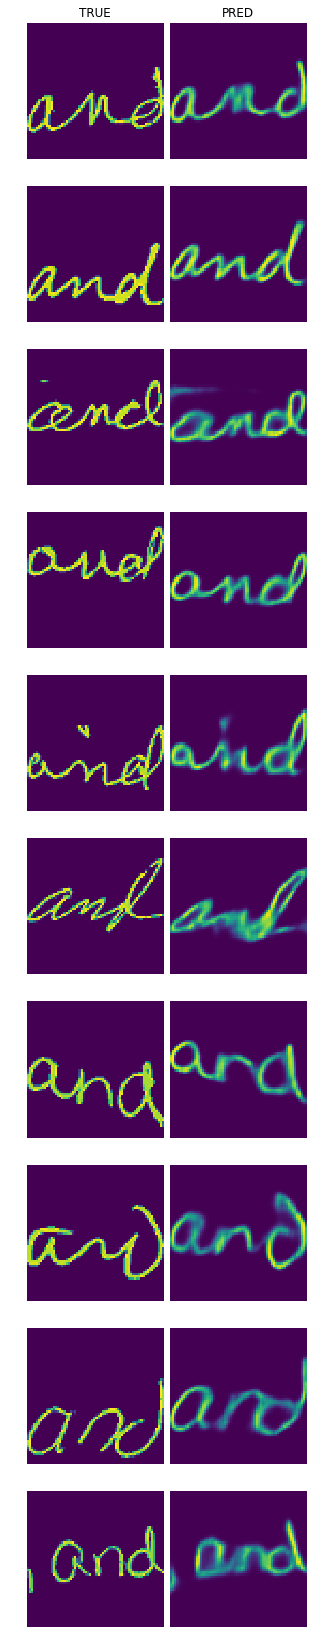

In [19]:

print(vx.shape,vy[0].shape)
py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')


In [20]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)


In [21]:
# df_val = pd.DataFrame(vy).T
# df_val.columns = ['identity','id','imagename']
# df_val = df_val.sort_values(by=['identity','imagename'])
# df_val = df_val.drop_duplicates()
# df_val = df_val.drop(columns=['id'])
# df_val

In [22]:
ids = vy[0].reshape(-1,1)
imagenames = vy[1].reshape(-1,1)
preds = encoder.predict(vx).reshape((-1,512))
# print(ids.shape,preds.shape)
# 
data=[]
for i in range(len(vx)):
    data.append([ids[i][0],imagenames[i][0],preds[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.shape

(9855, 4)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [24]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [32]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.6
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 10
prev_query = ''
prev_given = ''
given_count = 0
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [33]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity').reset_index().drop(columns=['index'])
df_cos_dist_out.head(50)

,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,0001,0001b_num3.png,44,44,9361,450,0,0.089069,1.000000,0.163569,0.954338,9855,"[0005/0005b_num5.png, 0005/0005b_num5.png, 000...",[]
1,0001,0001c_num1.png,44,44,9135,676,0,0.061111,1.000000,0.115183,0.931405,9855,"[0002/0002b_num2.png, 0002/0002c_num2.png, 000...",[]
2,0001,0001b_num2.png,44,44,9242,569,0,0.071778,1.000000,0.133942,0.942263,9855,"[0002/0002b_num2.png, 0002/0002c_num2.png, 000...",[]
3,0001,0001c_num3.png,44,39,9514,297,5,0.116071,0.886364,0.205263,0.969356,9855,"[0006/0006b_num5.png, 0006/0006b_num5.png, 000...","[0001/0001a_num3.png, 0001/0001a_num3.png, 000..."
4,0001,0001a_num4.png,44,44,9345,466,0,0.086275,1.000000,0.158845,0.952714,9855,"[0002/0002b_num2.png, 0002/0002b_num2.png, 000...",[]
5,0001,0001c_num1.png,44,44,9168,643,0,0.064047,1.000000,0.120383,0.934754,9855,"[0002/0002b_num2.png, 0002/0002c_num2.png, 000...",[]
6,0001,0001b_num2.png,44,44,9240,571,0,0.071545,1.000000,0.133536,0.942060,9855,"[0002/0002b_num2.png, 0002/0002c_num2.png, 000...",[]
7,0001,0001b_num2.png,44,44,9284,527,0,0.077058,1.000000,0.143089,0.946525,9855,"[0002/0002b_num2.png, 0002/0002c_num2.png, 000...",[]
8,0001,0001b_num2.png,44,44,9298,513,0,0.078995,1.000000,0.146423,0.947945,9855,"[0002/0002b_num2.png, 0002/0002c_num2.png, 000...",[]
9,0001,0001a_num3.png,44,40,9367,444,4,0.082645,0.909091,0.151515,0.954541,9855,"[0002/0002b_num2.png, 0002/0002c_num2.png, 000...","[0001/0001c_num3.png, 0001/0001c_num3.png, 000..."


In [35]:
df_cos_dist_out.to_csv('results-DL_AE_Maxpool_1x1x512_Shuffled.csv')

In [34]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.03786479353507051 
recall: 0.7426308819727658 
f1: 0.07205565873345769
Intra Writer Accuracy (Type 1): 0.7820224826264299
Inter Writer Accuracy (Type 2):: 0.961221651027674
acc: 0.9626709664565423


Text(0.5, 1.0, 'Right Input')

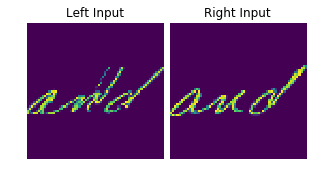

In [28]:
# test_im_shifted=test_im_normal
# test_im_shifted = vx[-2]
# rand = np.random.randint(-12,12)
# test_im_shifted=np.roll(axis=0,a=test_im_shifted,shift=-10)
# test = np.zeros((64,64,1))
# test[0:45]=test_im_shifted
# test_im_normal = vx[1]
# test_im_shifted = vx[2]
# plt.imshow(test_im_shifted.reshape((64,64)))
test_im_normal = 255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num2.png',0)
test_im_shifted = 255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num1.png',0)
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
ax[0].imshow(test_im_normal.reshape((64,64)))
ax[0].axis('off')

ax[1].imshow(test_im_shifted.reshape((64,64)))
ax[1].axis('off')
ax[0].set_title('Left Input')
ax[1].set_title('Right Input')

In [29]:
py1 = encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = encoder.predict(test_im_shifted.reshape((1,64,64,1)))
py1[py1==0].shape,py2[py2==0].shape

((261,), (287,))

In [30]:
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

(1, 512) (1, 512)


(array([[0.7553907]], dtype=float32),
 array([[0.2446093]], dtype=float32),
 array([[2239.3992]], dtype=float32))

In [31]:
val_list_of_writers[:2]

['0270c_num4.png', '1165aa_num1.png']